# Introduction

The following is an analysis of the data collected through a survey of participants in [RocDev](https://rocdev.org/), a community of professionals in disciplines related to software development in the greater Rochester area.  The information collected concerned (1) employment (2) compensation, (3) demographics, and (4) current events/trends in the tech labor market. Thank you to everyone who took the time to complete the survey.  We hope that the information will be useful.

## Open Analysis

While we no longer make the raw data publicly available due to privacy concerns, the analysis script we use to generate this report is publicly available in the GitHub repository [here](https://github.com/rocdev-foundation/annual-compensation-survey). If you would like to run additional analysis on this data not included below, you may submit a pull request with changes made to this notebook and/or get in touch with us via the RocDev Slack instance.

## Limitations

Before diving into the data itself, we should discuss some of its limitations.  First, it's important to note that this data is what's known as _convenience sample,_ focused on the RocDev community itself, rather than an attempt to randomly sample from all software professionals in the Rochester area (technically it's a _snowball_ sample as well).  This limits the type of statistical inferences that can be drawn, because RocDev participants (and others who may have learned of the survey through word of mouth) may differ from the broader population in systematic ways.  Or, put another way, making inferences about the _entire_ software development community in and around Rochester requires making assumptions that unlikely to be completely accurate, because the likelihood that people responded to the survey could be correlated with the questions we asked about.

We had 106 responses again this year, which is back to the typical level we'd seen in most previous years.  Thank you!  However, it's important to keep in mind that this is still a rather small sample size.  This is particularly true in making comparisons across different categories--some of them only contain a handful of people! These data limitations prevent statistically reliable cross-group comparisons in many cases.

## Software Dependencies

As software development professionals, it's appropriate to say a quick "thank you" to colleagues in the open source and data science communities for the software used to do this analysis!  For this small-time analysis project, we used Python, Pandas, MatPlotLib, Seaborn, and Jupyter. Thank you to all the developers who contributed to these projects!

In [78]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import statsmodels.formula.api as sm
from IPython.display import SVG, display

# Importing and Processing Data

First, we'll import the data and give the columns shorter mnemonic names that are more practical to refer to in source code.  Then we'll prepare the data for statistical analysis by coercing data into the correct types (i.e., numbers, categories, and yes/no questions).

The "cleaned" version of the data just removes a few errors and outliers.  For example, it's not physically possible to work more than 168 hours in a week (24x7=168), so we can be confident data that violates this constraint was entered in error.

In [79]:
as_imported = pd.read_table("2022.tsv")
data = pd.read_table("2022.tsv")
descriptions = data.columns

In [80]:
data.columns = [
    # Meta
    'timestamp', # When the survey was completed (from Google Forms)
    'consent', # important for data consent, irrelevant for analysis

    # Basic Employment Information
    'org_type', # Public, private, or self-employed?
    'job_type', # Regular (i.e., W-2) employee or contractor?
    'org_size', # Approximately how many people work for your employer worldwide?
    'org_where', # Where is your employer located?
    'job_title', # What is your official job title?
    'job_role', # which of the following best describes your role?
    'job_description', # Please write a short description of what you do.
    'job_tenure', # How many years have you been with your current employer?
    'job_supervisor', # Do people report directly to you?
    'remote', # Do you work remotely?  (Likert Scale)
    'remote_ly', # Same question, but for previous year
    'remote_where', # If you work remotely, where do you do most of your work?
    'side_job', # Do you have a second job or side business?
    'tech_tenure', # How many years have you worked in the technology industry?
    'tech_jobs', # How many jobs have you had in that time?
    'tech_jobs_py', # How many jobs have you had in the _past year_? (churn)
    'org_hiring', # Descrition of organization's current hiring practices.

    # Compensation and Benefits
    'job_pay', # What is your approximate annual salary (in thousands) including bonuses?
    'job_when_negotiated', # What year was your current pay set?
    'job_hours', # How many yours do you work in an average week?
    'job_benefits', # What other kinds of compensation and benefits does your employer provide?
    'job_equity', # If your employer offers equity or options, how much do you expect they're worth?
    'job_vacation', # If your employer offers paid vacation, how many paid days off per year?
    'side_job_pay', # If you have a second job or do outside contract work, approx. how much do you make on the side?

    # Opinions and Expectations
    'inflation_expect', # Expectation that employer will raise salaries for inflation (likert)
    'remote_sat', # Satisfaction with current remote work policies
    'layoffs_worry', # Worried about layoffs at their employer
    'unhappy_lfg', # Dissatisfied with compensation, looking for alternatives?
    'rocdev_irl', # Would like RocDev to go back to holding more in-person events
    'cont_ed_sat', # Satisfaction with employer's continuing education policies

    # Demographics
    'domicile', # Where do you live?  (Multiple choice general areas)
    'education', # What is the highest degree you have received?
    'school', # At which School/University did you receive this degree?
    'gender', # Gender
    'race', # Race
    'misc', # Do you identify with any of the following?
    'comments' # Do you have anything else to add?
]
as_imported.columns = data.columns

In [81]:
# This is just changing the types of a few columns from text to discrete categories.
data['job_type'] = data['job_type'].astype('category')
data['org_where'] = data['org_where'].astype('category')
data['org_hiring'] = data['org_hiring'].astype('category')
data['job_role'] = data['job_role'].astype('category')
data['job_supervisor'] = data['job_supervisor'].astype('category')
data['side_job'] = data['side_job'].astype('category')
data['domicile'] = data['domicile'].astype('category')
data['education'] = data['education'].astype('category')
data['gender'] = data['gender'].astype('category')
data['race'] = data['race'].astype('category')
data['remote_where'] = data['remote_where'].astype('category')

In [82]:
# This code pulls out binary yes/no values (sometimes called "dummy variables"
# in statistics) from the Google Forms answer encoding.
def map_benefits_dummies(input):
    if isinstance(input, str):
        benefits = []
        if "Health Insurance" in input:
            benefits.append("benefits_health")
        if "Dental" in input:
            benefits.append("benefits_dental")
        if "Vision" in input:
            benefits.append("benefits_vision")
        if "HSA" in input:
            benefits.append("benefits_hsa")
        if "401k" in input:
            benefits.append("benefits_retirement_matching")
        if "Equity" in input:
            benefits.append("benefits_equity_options")
        if "Profit Sharing" in input:
            benefits.append("benefits_profit_sharing")
        if "Tuition" in input:
            benefits.append("benefits_tuition")
        return benefits
    return ['benefits_na']

In [83]:
def map_misc_dummies(input):
    if isinstance(input, str):
        changes = []
        if "LGBT" in input:
            changes.append("misc_lgbt")
        if "disability" in input:
            changes.append("misc_disability")
        if "veteran" in input:
            changes.append("misc_veteran")
        if "Citizen" in input:
            changes.append("misc_foreigner")
        if "Parent" in input:
            changes.append("misc_parent")
        return changes
    return ['misc_none']

In [84]:
# Map dummy variables and add the resulting binaries to the data frame
benefits_dummies = pd.get_dummies(data['job_benefits'].map(map_benefits_dummies).apply(pd.Series).stack()).groupby(level=0).sum()
misc_dummies = pd.get_dummies(data['misc'].map(map_misc_dummies).apply(pd.Series).stack()).groupby(level=0).sum()
data = data.join(benefits_dummies).join(misc_dummies)

/var/folders/dx/ktwxxqzd0zv22cvqd2f2qtpc0000gn/T/ipykernel_78699/3742245627.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  misc_dummies = pd.get_dummies(data['misc'].map(map_misc_dummies).apply(pd.Series).stack()).groupby(level=0).sum()


In [85]:
# Average Job Tenure is a composite of total tenure in tech divided by the number of jobs in that time.
data.tech_tenure.replace(0, np.nan, inplace=True) # Zeroes are really non-responses in this context...
data.tech_jobs.replace(0, np.nan, inplace=True)
data['job_avg_tenure'] = data.apply(lambda row: row.tech_tenure / row.tech_jobs, axis = 1)

# Put lower bound of 1 on organization size; calculate log
data['org_size'] = data['org_size'].apply(lambda x: np.maximum(x, 1.0))
data['log_org_size'] = data['org_size'].apply(lambda x: np.log10(x))

# Place upper bound on allowed vacation days
def max_vac_func(days):
    if days > 100:
        return None
    return days
data['job_vacation'] = data['job_vacation'].apply(max_vac_func)

In [86]:
# This is just a function to get consistent pie charts without repeating
# formatting code, etc...
def mmpie(data,col_name,title,start_angle,legend_position,pie_labels):
    cats = data[col_name].value_counts().to_dict()
    x = list(cats.keys())
    if not pie_labels:
        pie_labels = list(cats.keys())
    y = data[col_name].value_counts().to_numpy()
    percent = 100.0 * y / y.sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(pie_labels, percent)]
    fig1, ax1 = plt.subplots()
    plt.figure(figsize=(6,6), dpi=200)
    patches, texts = ax1.pie(y,
        labels=pie_labels,
        shadow=False,
        startangle=start_angle,
        pctdistance=0,
        labeldistance=1.05)
    sort_legend = True
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                  key=lambda x: x[2],
                                  reverse=True))
    ax1.legend(patches, labels, loc=legend_position, fontsize=8)
    ax1.axis('equal')
    ax1.set(title=title)
    fn = "figures/" + col_name + ".svg"
    fig1.savefig(fn)
    plt.show()
    plt.close(fig1)
    # display(SVG(filename=fn))

# Analysis

## About Us

The survey was circulated in the RocDev Slack and newsletter, which also asked people to distribute the survey link to other software and related technology professionals in the Rochester Area.  Unsurprisingly, the result was that 94% of responses came from people living in Rochester NY (34%) and its suburbs (55%).  The remainder are from people who live a bit further away but still retain some ties to the Rochester area.

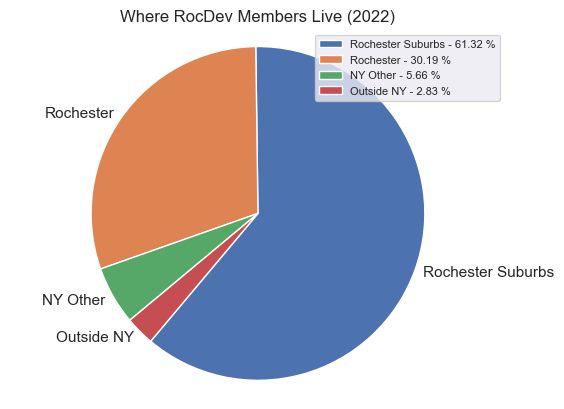

<Figure size 1200x1200 with 0 Axes>

In [87]:
# display(SVG(filename="../2020/figures/domicile.svg")) # Uncomment to compare with 2021
# display(SVG(filename="../2021/figures/domicile.svg")) # Uncomment to compare with 2021
mmpie(data, "domicile", "Where RocDev Members Live (2022)", 230, "upper right", ["Rochester Suburbs", "Rochester", "NY Other", "Outside NY"])

Most people who responded to the survey are primarily software developers (57%), but quite a few also work in adjacent areas.  This includes DevOps (16%) and testing (12%) as well as a few in management, HR, IT, and other roles.  The proportion of those in the software-adacent areas has expanded somewhat in the past several years, from 27% in 2020 to 43% in 2022.

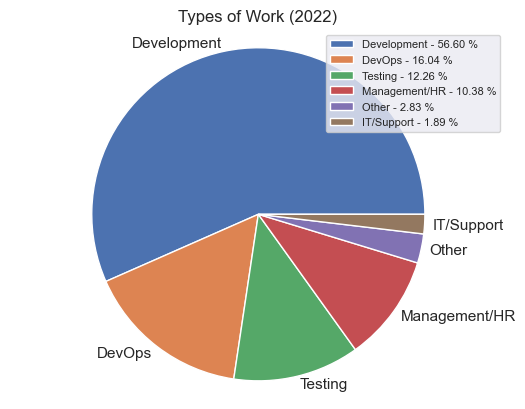

<Figure size 1200x1200 with 0 Axes>

In [88]:
#display(SVG(filename="../2020/figures/job_role.svg")) # Uncomment to compare with 2020
#display(SVG(filename="../2021/figures/job_role.svg")) # Uncomment to compare with 2021
mmpie(data, "job_role", "Types of Work (2022)", 0, "upper right", ["Development", "DevOps", "Testing", "Management/HR", "Other", "IT/Support"])

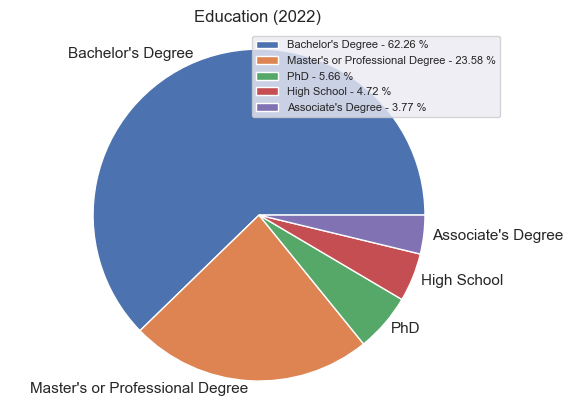

<Figure size 1200x1200 with 0 Axes>

In [89]:
#display(SVG(filename="../2020/figures/education.svg")) # Uncomment to compare with 2021
#display(SVG(filename="../2021/figures/education.svg")) # Uncomment to compare with 2021
mmpie(data, "education", "Education (2022)", 0, "upper right", [])

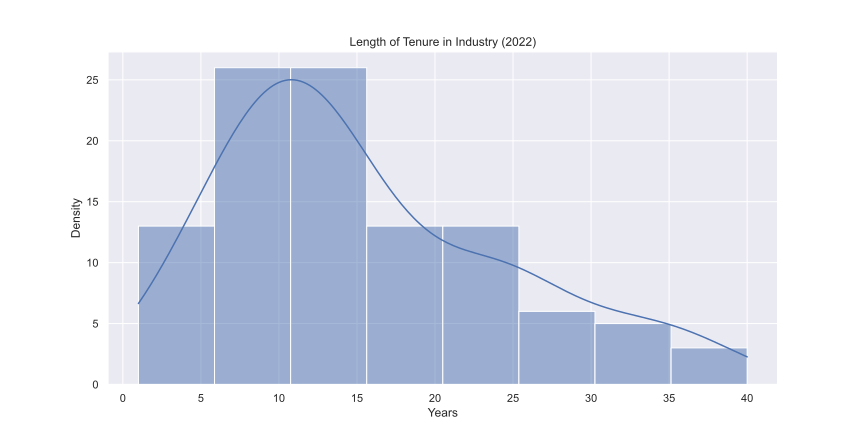

In [90]:
#display(SVG(filename="../2020/figures/tech_tenure.svg")) # Uncomment to compare with 2020
#display(SVG(filename="../2021/figures/tech_tenure.svg")) # Uncomment to compare with 2021
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(data, x="tech_tenure", kde=True)
plot.set(
    xlabel="Years",
    ylabel="Density",
    title="Length of Tenure in Industry (2022)"
)
fn = "figures/tech_tenure.svg"
plot.get_figure().savefig(fn)
plt.close('all')
display(SVG(fn))

Participants in RocDev are predominately white and male.  This is roughly consistent with the broader demographic trends in software development overall, given the demographic composition of the greater Rochester area and the inherent uncertainty with small sample sizes.

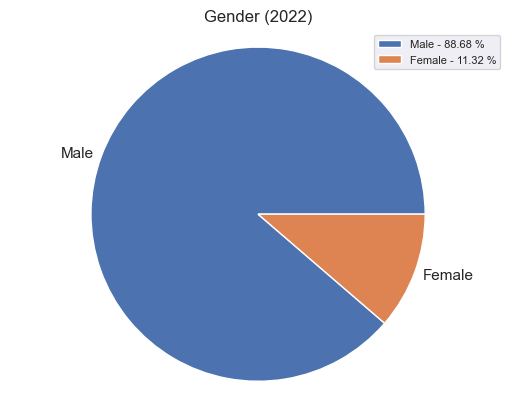

<Figure size 1200x1200 with 0 Axes>

In [91]:
# display(SVG(filename="../2020/figures/gender.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/gender.svg")) # Uncomment to compare with 2021
mmpie(data, "gender", "Gender (2022)", 0, "upper right", [])

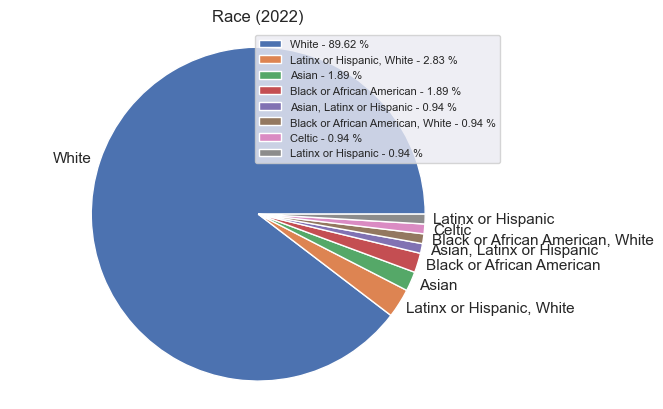

<Figure size 1200x1200 with 0 Axes>

In [92]:
# display(SVG(filename="../2020/figures/race.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/race.svg")) # Uncomment to compare with 2021
mmpie(data, "race", "Race (2022)", 0, "upper right", [])

Other demographic variables of interest were the proportion of RocDev participants who (1) are parents (or expecting), (2) have some mental or physical disability, (3) identify as an LGBT person, or (4) are non-citizens.

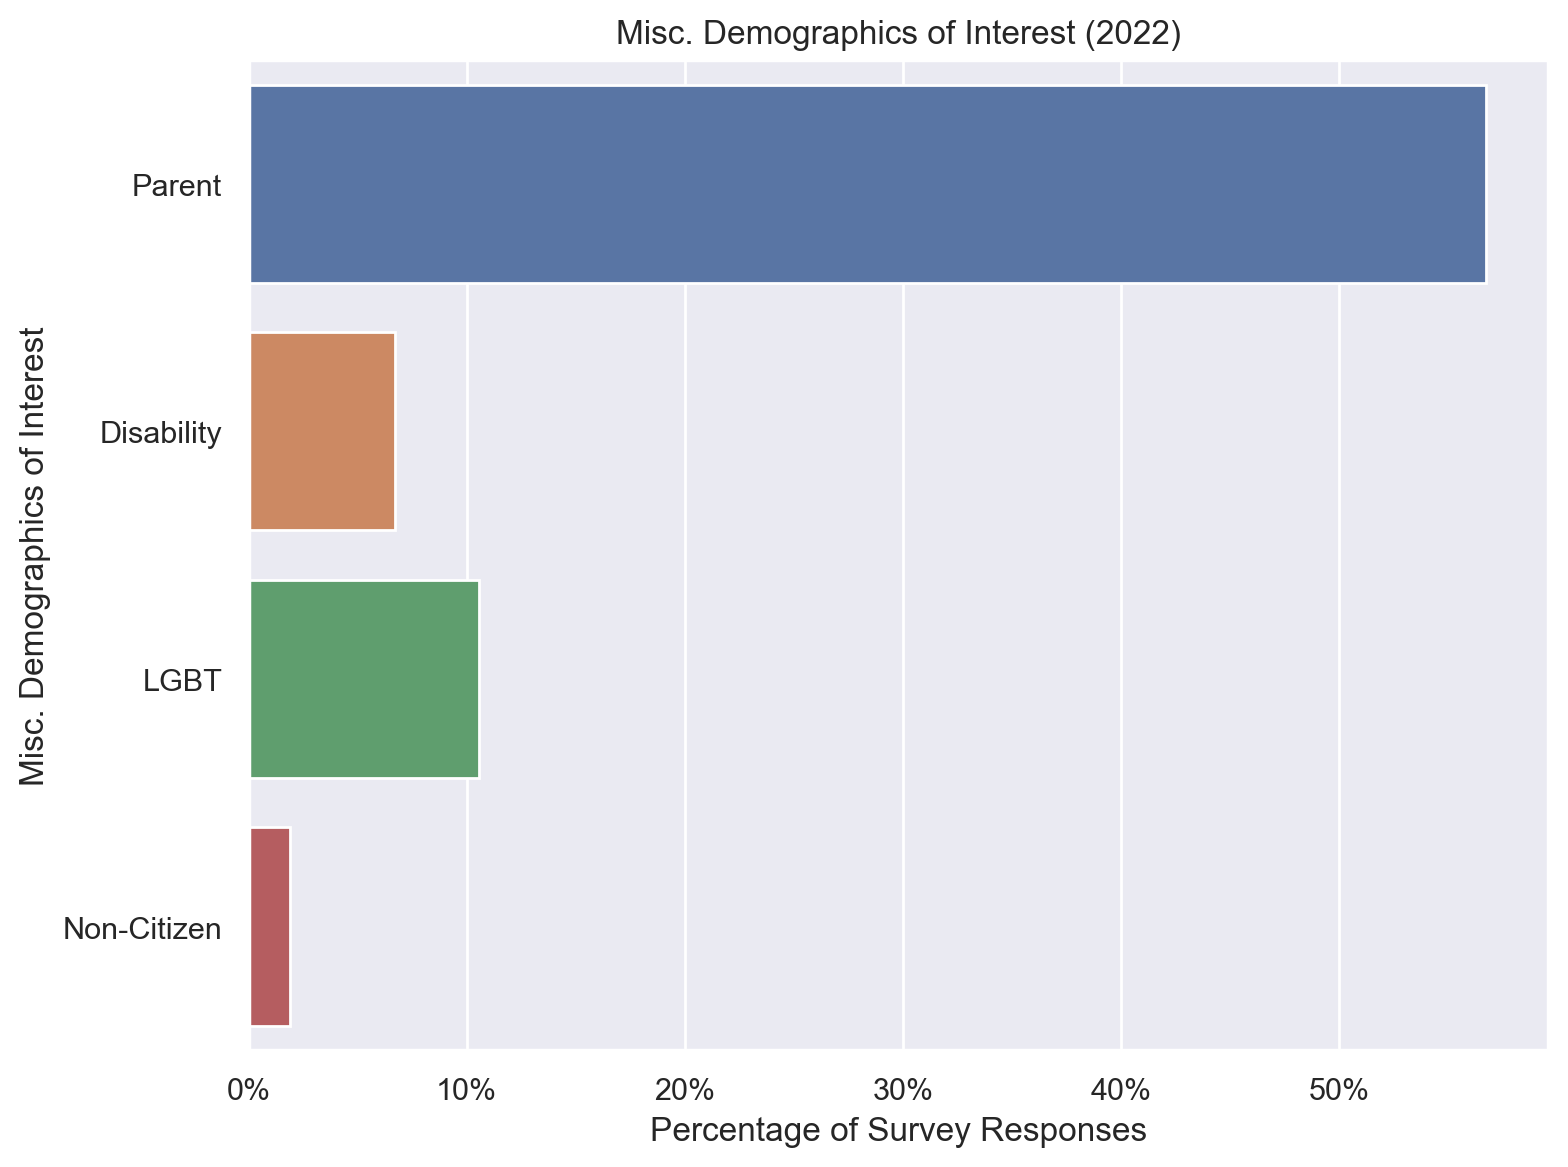

In [93]:
# display(SVG(filename="../2020/figures/misc.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/misc.svg")) # Uncomment to compare with 2021

misc_labels = [
    "Parent",
    "Disability",
    "LGBT",
    "Non-Citizen",
]
misc_percentages = [
    data['misc_parent'].mean() * 100,
    data['misc_disability'].mean() * 100,
    data['misc_lgbt'].mean() * 100,
    data['misc_foreigner'].mean() * 100,
]
misc_df = pd.DataFrame({'Misc': misc_labels, 'Percentage':misc_percentages })

plt.figure(figsize=(8,6), dpi=200)
plot = sns.barplot(y="Misc", x="Percentage", data=misc_df)
plot.xaxis.set_major_formatter(mtick.PercentFormatter())
plot.set(
    xlabel="Percentage of Survey Responses",
    ylabel="Misc. Demographics of Interest",
    title="Misc. Demographics of Interest (2022)"
)
plt.tight_layout()
fn = "figures/misc.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close()

# About Employers and Jobs
Employers are roughly split between those that are primarily located in Rochester
and those that are primarily located elsewhere.  This is likely to have some overlap
with the portion of people do primarily do remote / telecommuting work.

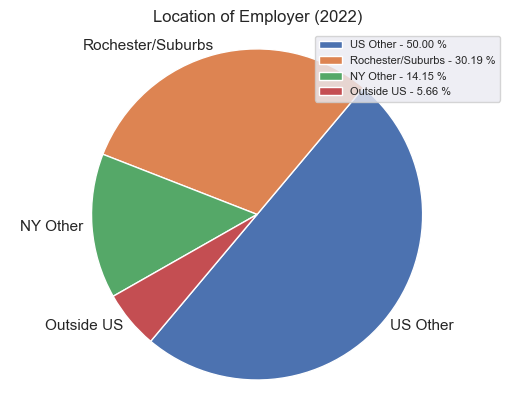

<Figure size 1200x1200 with 0 Axes>

In [94]:
# display(SVG(filename="../2020/figures/org_where.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/org_where.svg")) # Uncomment to compare with 2021

mmpie(data, "org_where", "Location of Employer (2022)", 230, "upper right", ["US Other", "Rochester/Suburbs", "NY Other", "Outside US"])

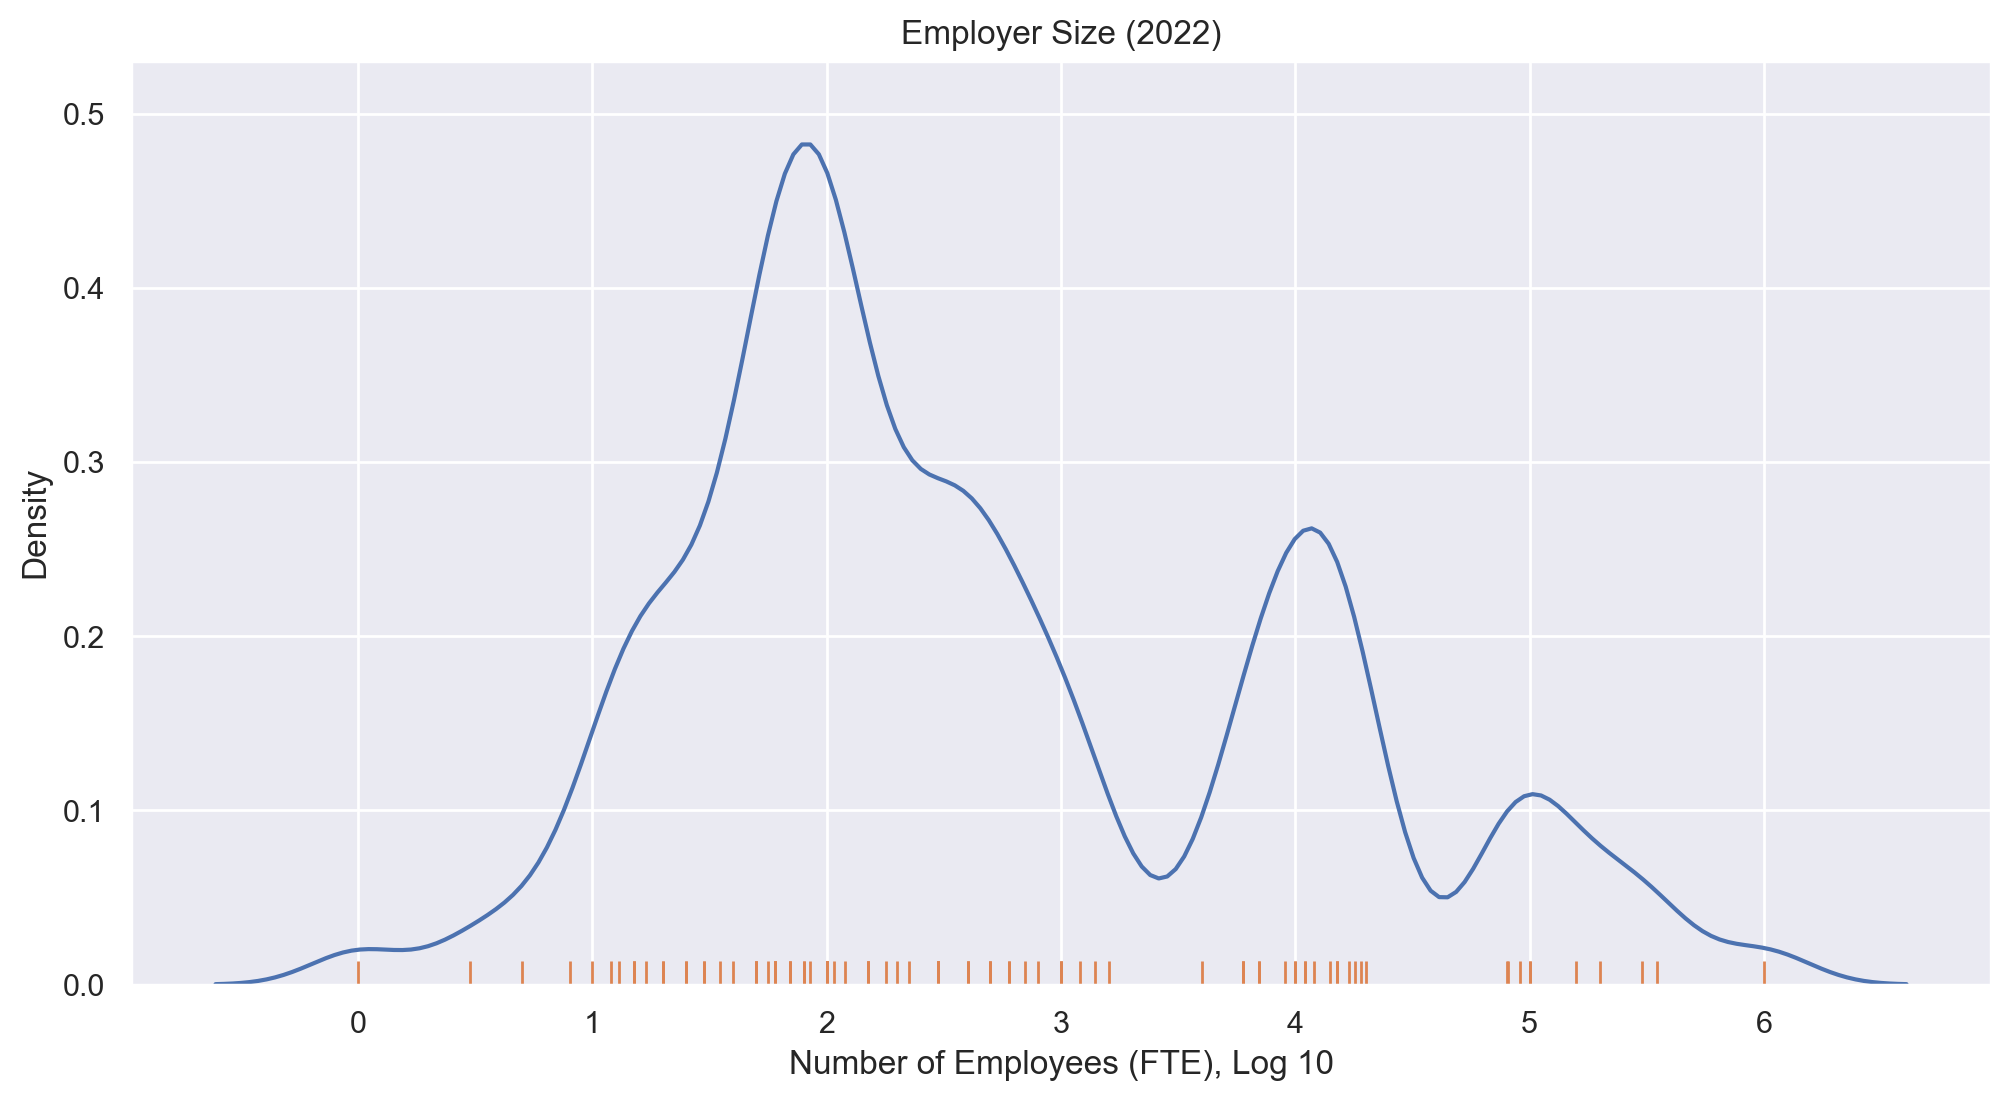

In [95]:
# display(SVG(filename="../2020/figures/org_size.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/org_size.svg")) # Uncomment to compare with 2021

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['log_org_size'].dropna(), bw_adjust=0.4)
sns.rugplot(data=data, x="log_org_size")
plot.set(
    xlabel="Number of Employees (FTE), Log 10",
    ylabel="Density",
    title="Employer Size (2022)"
)
fn = "figures/org_size.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')

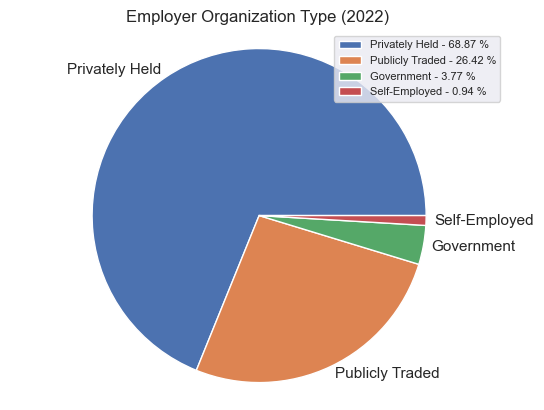

<Figure size 1200x1200 with 0 Axes>

In [96]:
# display(SVG(filename="../2020/figures/org_type.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/org_type.svg")) # Uncomment to compare with 2021

mmpie(data, "org_type", "Employer Organization Type (2022)", 0, 'upper right', ["Privately Held", "Publicly Traded", "Government", "Self-Employed"])

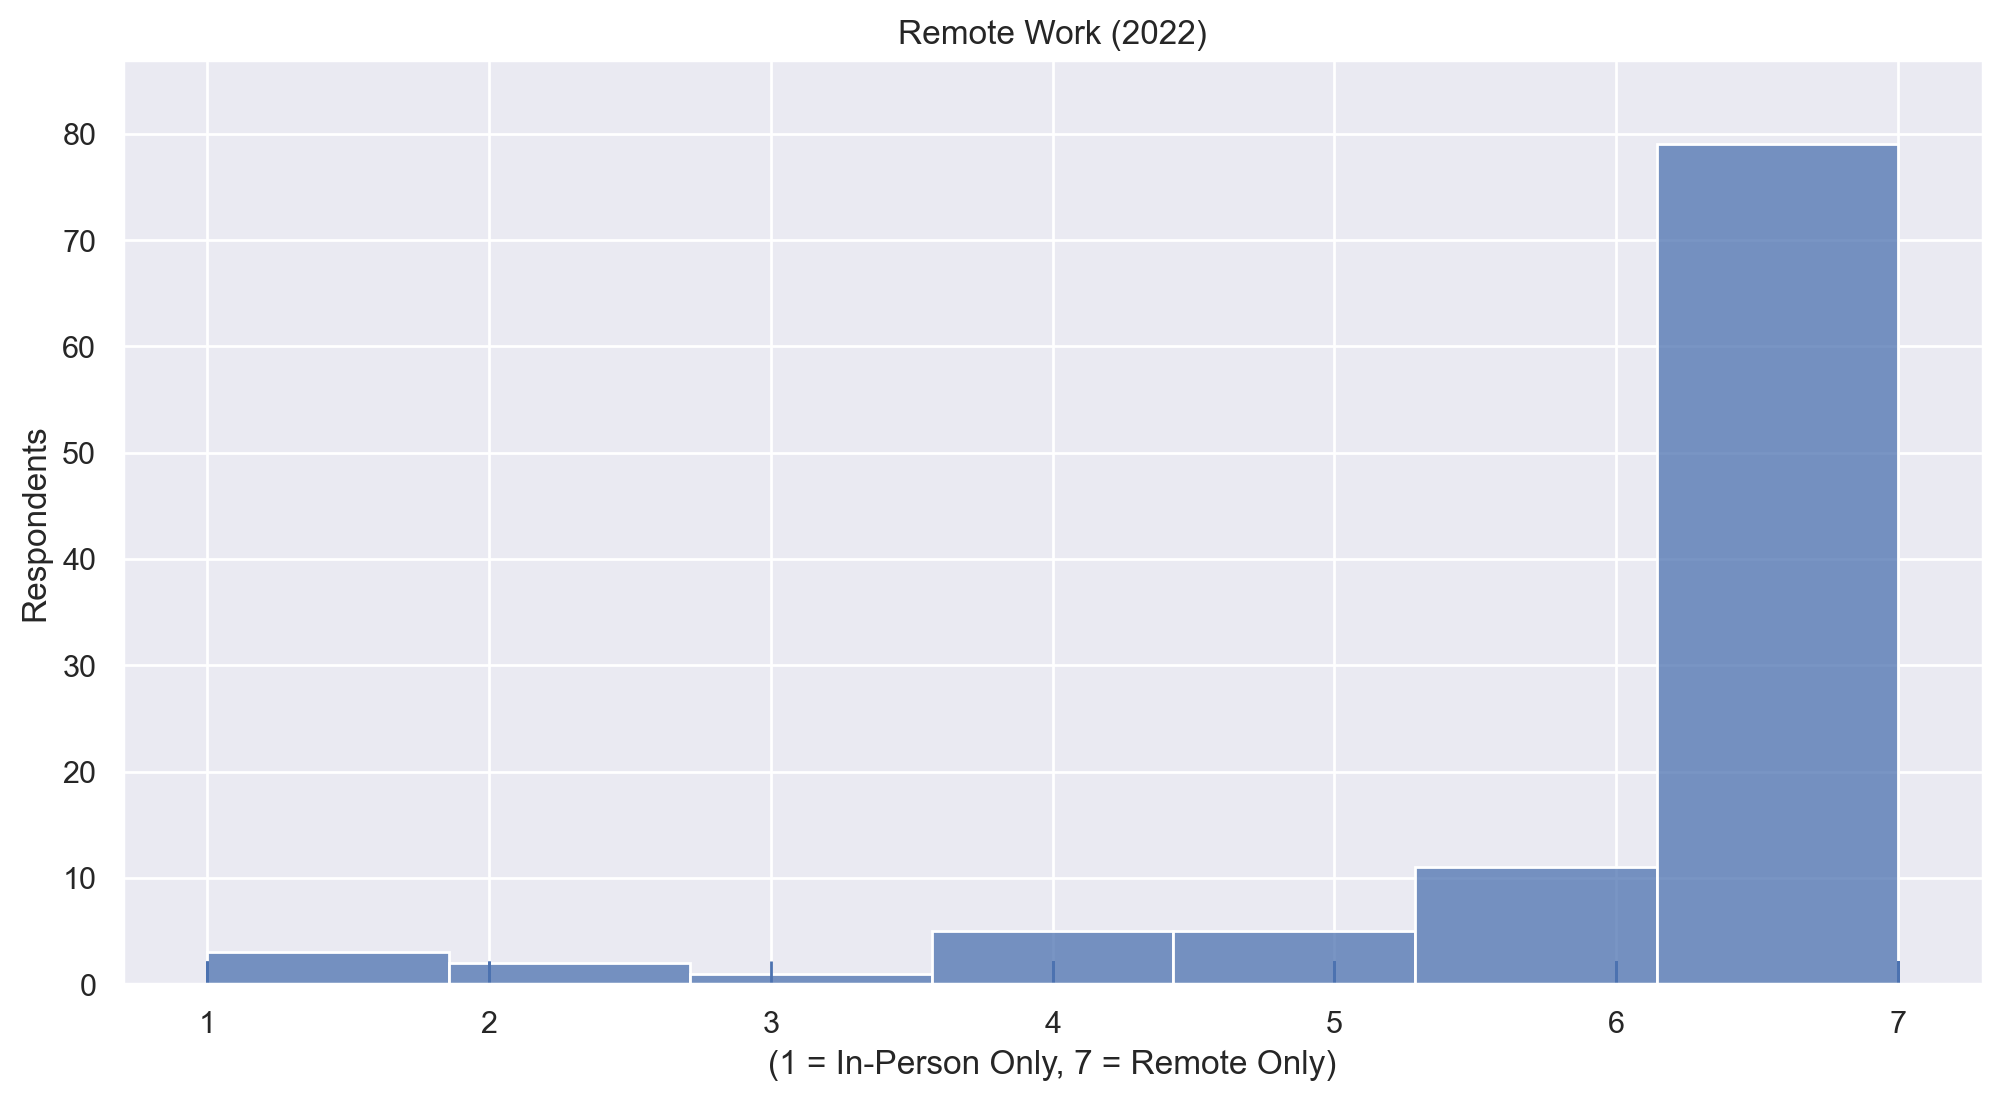

In [97]:
# mmpie(data2019, "job_remote", "Job Remote Status for 2019", 0, 'upper left', ["Yes", "No"])

# sns.set(color_codes=True)
# plt.figure(figsize=(12,6), dpi=200)
# plot = sns.histplot(x = "remote_ly", bins=7, data=data)
# # plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
# sns.rugplot(data=data, x="remote_ly")
#
# plot.set(
#     xlabel="(1 = In-Person Only, 7 = Remote Only)",
#     ylabel="Respondents",
#     title="Remote Work (2021)"
# )
# fn = "figures/remote_2021.svg"
# plot.get_figure().savefig(fn)
# plt.show()
# plt.close('all')
# # display(SVG(fn))

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "remote", bins=7, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="remote")

plot.set(
    xlabel="(1 = In-Person Only, 7 = Remote Only)",
    ylabel="Respondents",
    title="Remote Work (2022)"
)
fn = "figures/remote_2022.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

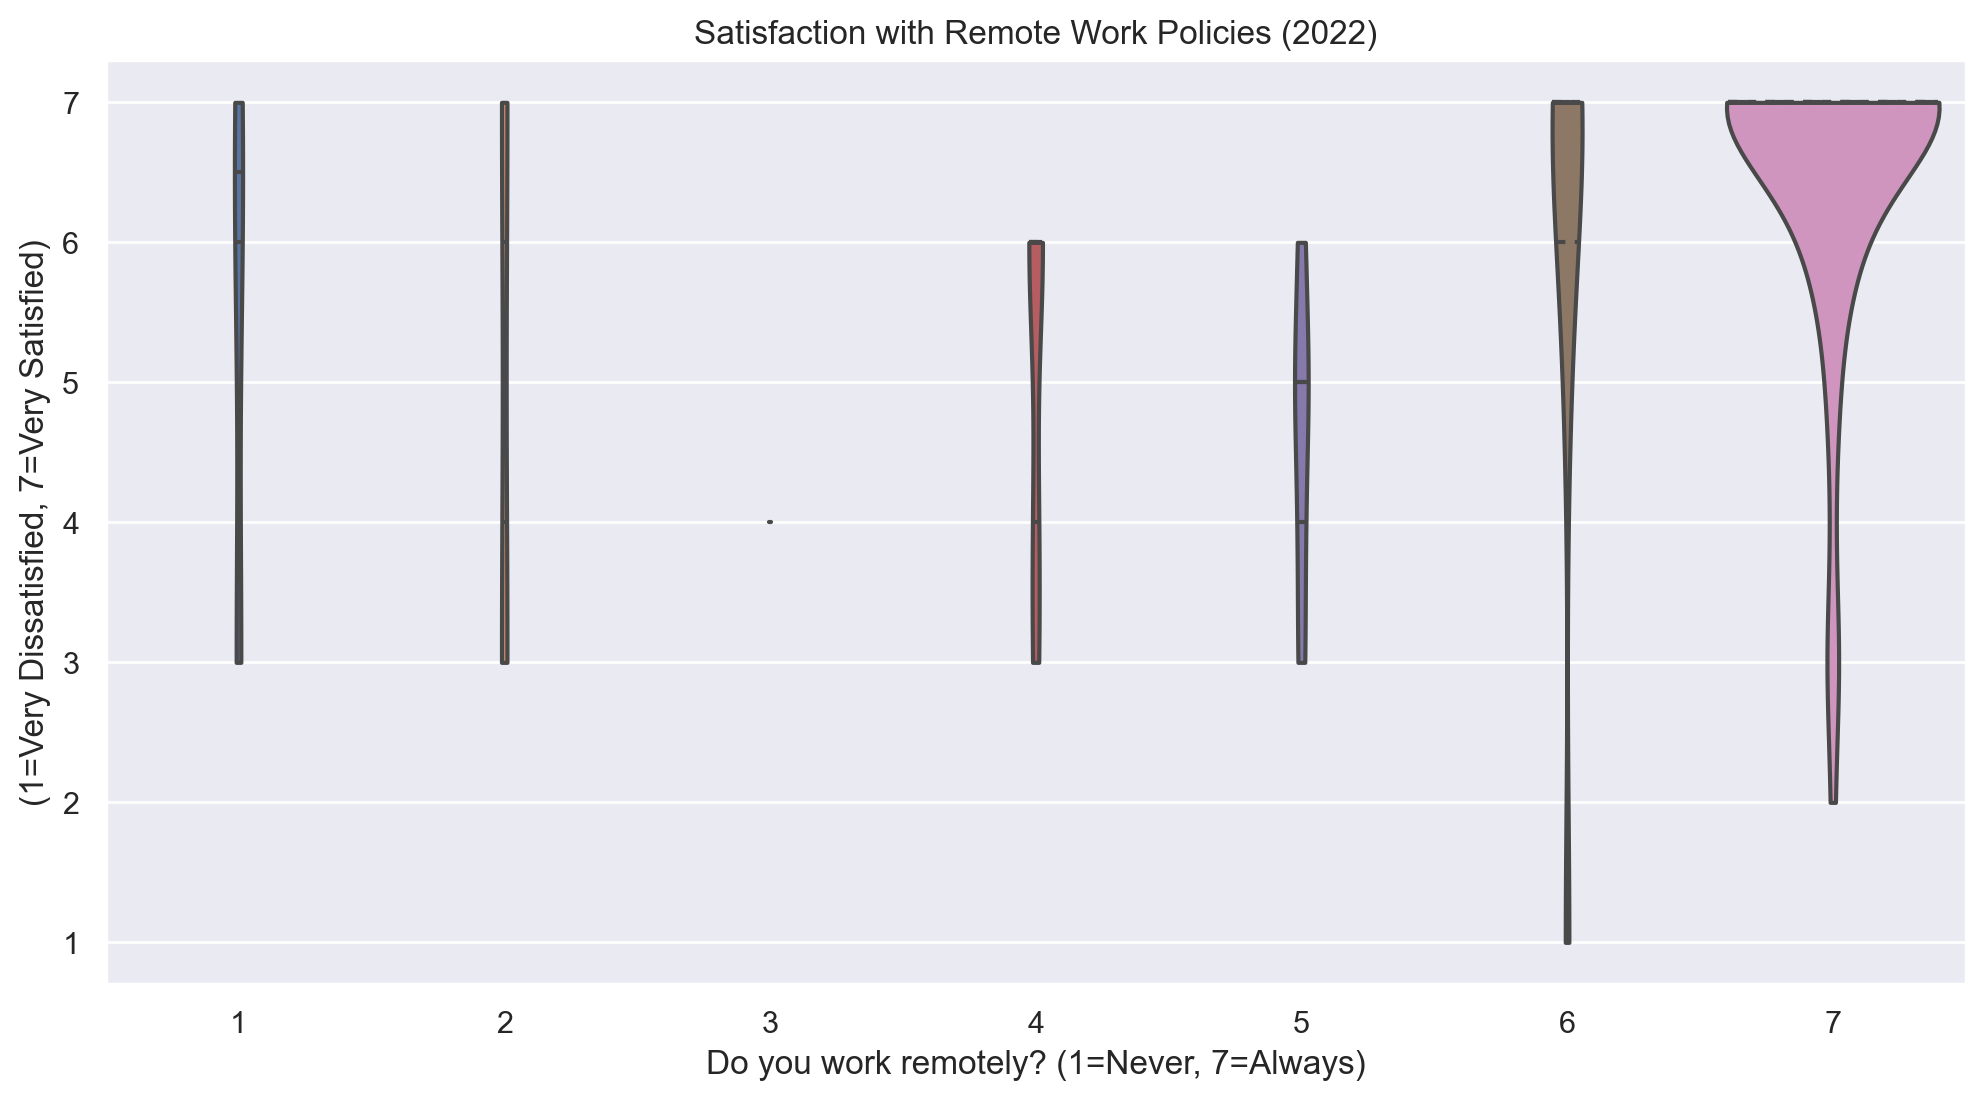

In [98]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "remote",
    y = "remote_sat",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Do you work remotely? (1=Never, 7=Always)",
    ylabel="(1=Very Dissatisfied, 7=Very Satisfied)",
    title="Satisfaction with Remote Work Policies (2022)"
)
plot.get_figure().savefig("figures/remote_vs_remote_sat.svg")
plt.show()

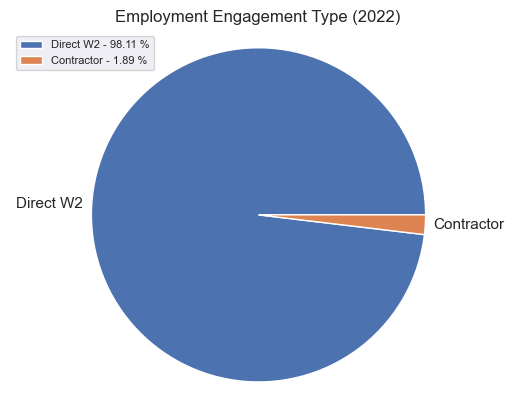

<Figure size 1200x1200 with 0 Axes>

In [99]:
# display(SVG(filename="../2020/figures/job_type.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/job_type.svg")) # Uncomment to compare with 2021

mmpie(data, "job_type", "Employment Engagement Type (2022)", 0, 'upper left', ["Direct W2", "Contractor"])

This year, 17% of respondents have direct reports, which is a bit higher than was reported last year (~10%).

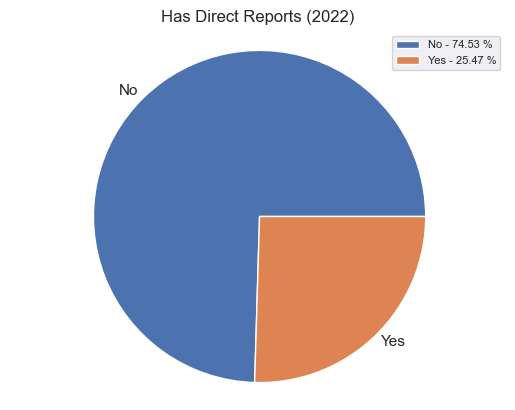

<Figure size 1200x1200 with 0 Axes>

In [100]:
# display(SVG(filename="../2020/figures/job_supervisor.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/job_supervisor.svg")) # Uncomment to compare with 2021

mmpie(data, "job_supervisor", "Has Direct Reports (2022)", 0, "upper right", [])

A considerable portion (23%) also have some kind of second job or are involved in side projects in addition to their primary employment.

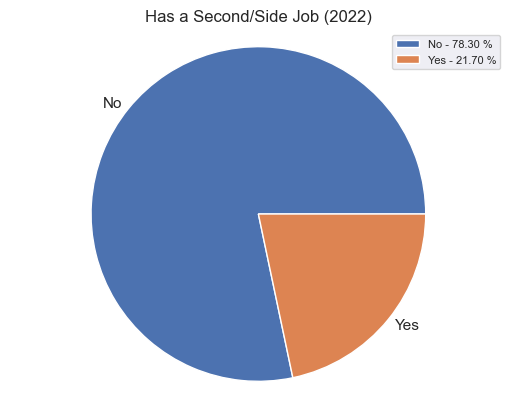

<Figure size 1200x1200 with 0 Axes>

In [101]:
# display(SVG(filename="../2020/figures/side_job.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/side_job.svg")) # Uncomment to compare with 2021
mmpie(data, "side_job", "Has a Second/Side Job (2022)", 0, "upper right", [])

Another interesting aspect of the technology industry is the relatively short length of time that people will stay in the same job before moving on. Across _all_ respondents, the average amount of time in a job was around 3.4 years.  However, it's also important to note that the distribution has some right skew, so the more typical length of time people stay in the same job is closer to 2.5 years.

The 2021 distribution was similar to that in 2020.

In [102]:
data['job_avg_tenure'].mean()

3.2907569460454074

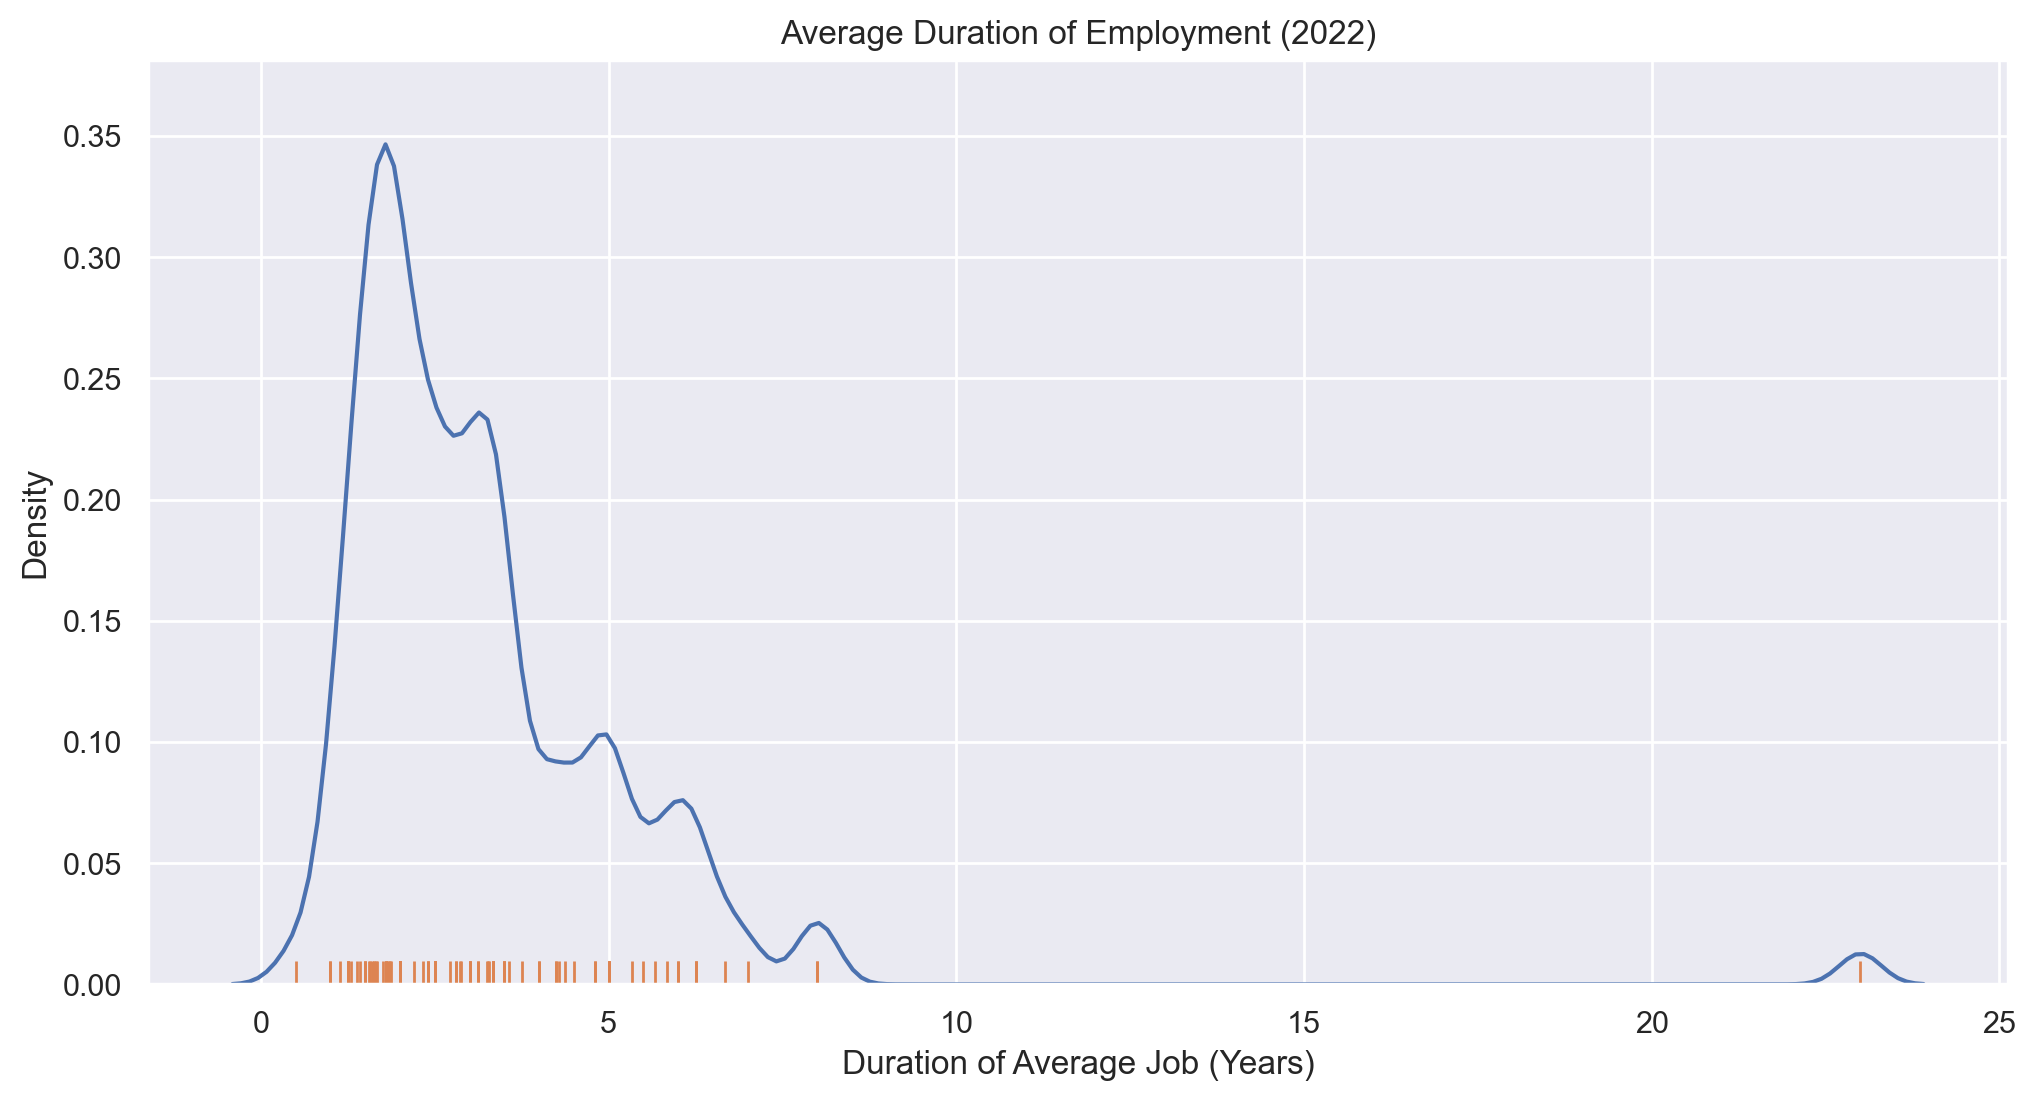

In [103]:
# display(SVG(filename="../2020/figures/job_avg_tenure.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/job_avg_tenure.svg")) # Uncomment to compare with 2021

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['job_avg_tenure'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_avg_tenure")
plot.set(
    xlabel="Duration of Average Job (Years)",
    ylabel="Density",
    title="Average Duration of Employment (2022)"
)
fn = "figures/job_avg_tenure.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))


The substantial majority of respondents reported working standard 40-hour weeks, while the remainder skewed towards slightly longer weeks.

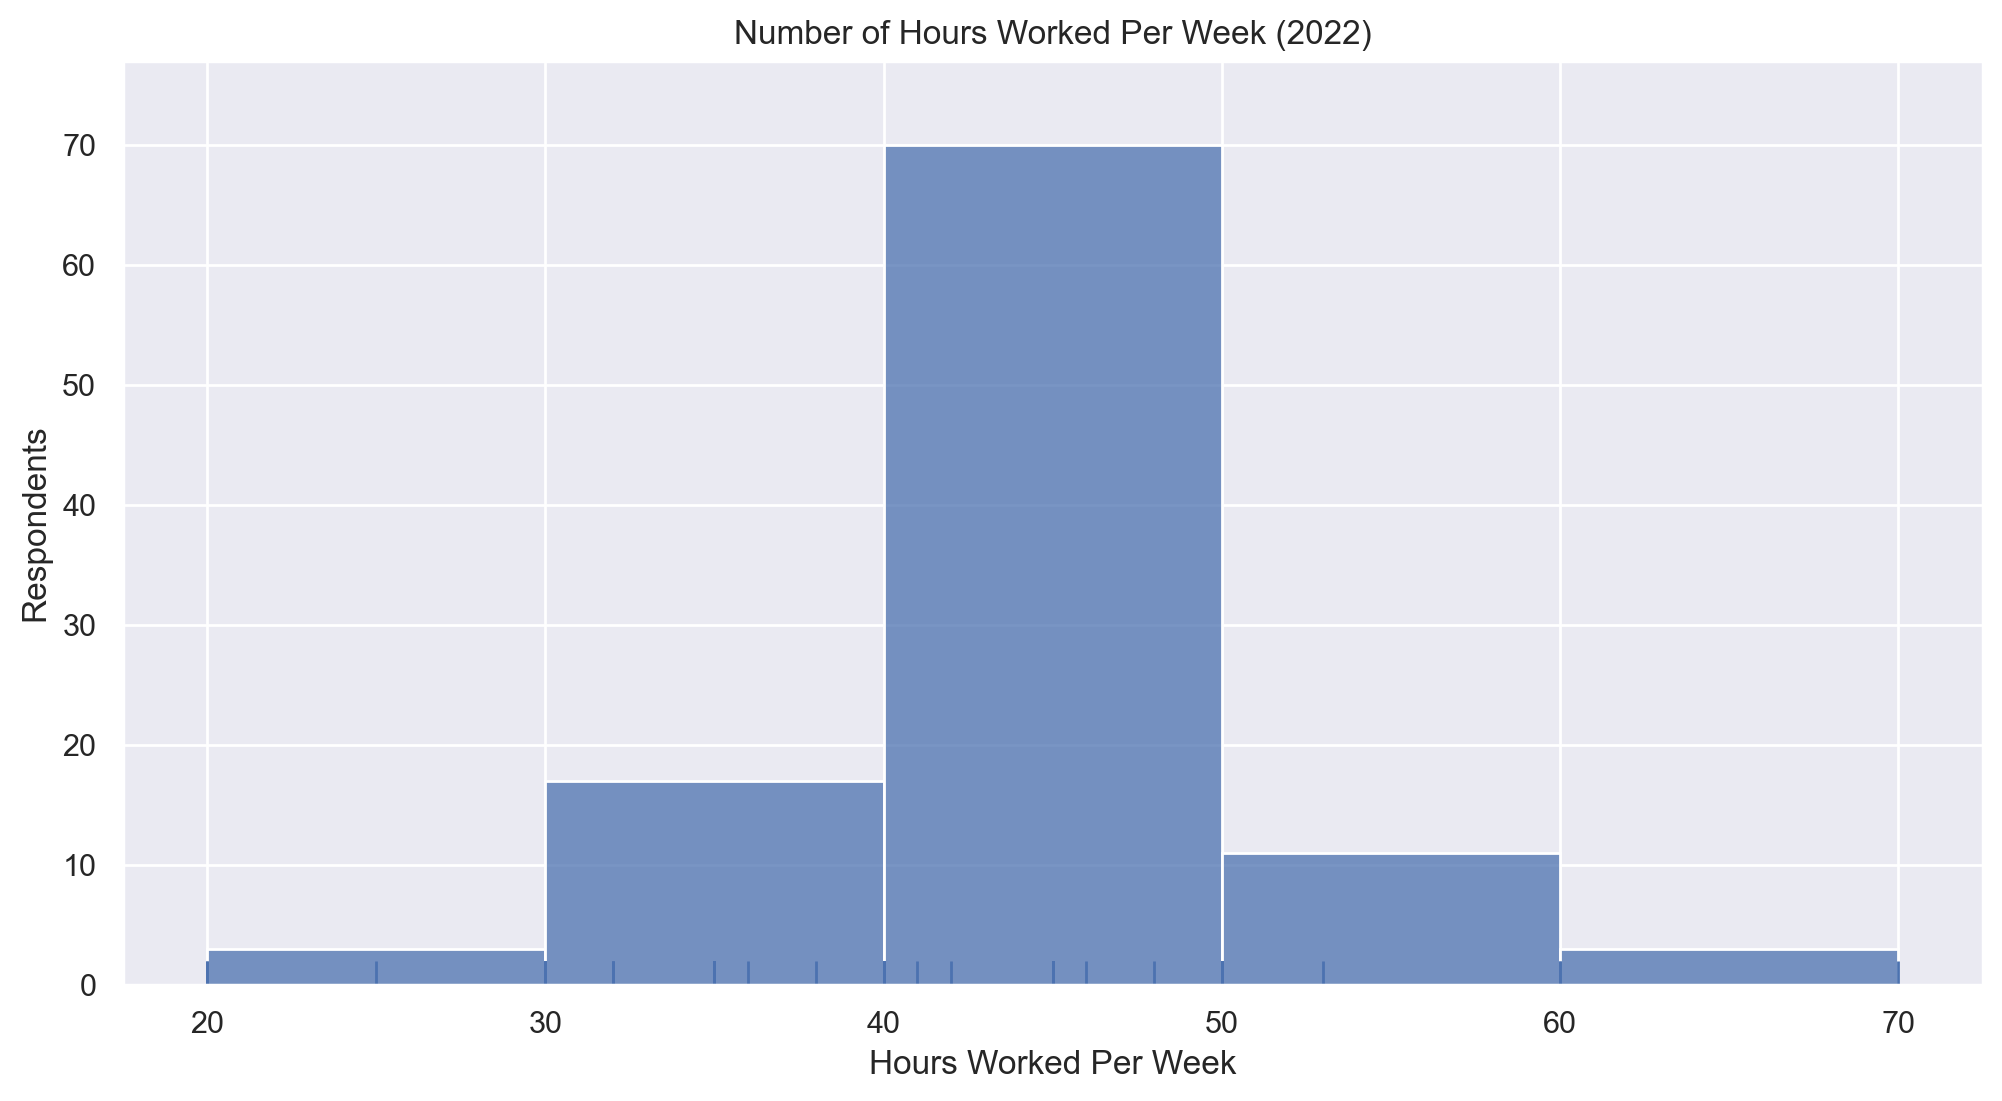

In [104]:
# display(SVG(filename="../2020/figures/job_hours.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/job_hours.svg")) # Uncomment to compare with 2021

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "job_hours", bins=5, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_hours")

plot.set(
    xlabel="Hours Worked Per Week",
    ylabel="Respondents",
    title="Number of Hours Worked Per Week (2022)"
)
fn = "figures/job_hours.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

# Compensation

Salaries for software professionals in the Rochester area continued their strong growth over the past year, up 13% to an average of $158,000.  This is _slightly_ slower growth than the 15% increase in 2021, but is still significantly outpacing inflation.

In [105]:
data['job_pay'].describe()

count    106.000000
mean     157.978774
std       55.347238
min       55.000000
25%      121.250000
50%      155.000000
75%      180.000000
max      400.000000
Name: job_pay, dtype: float64

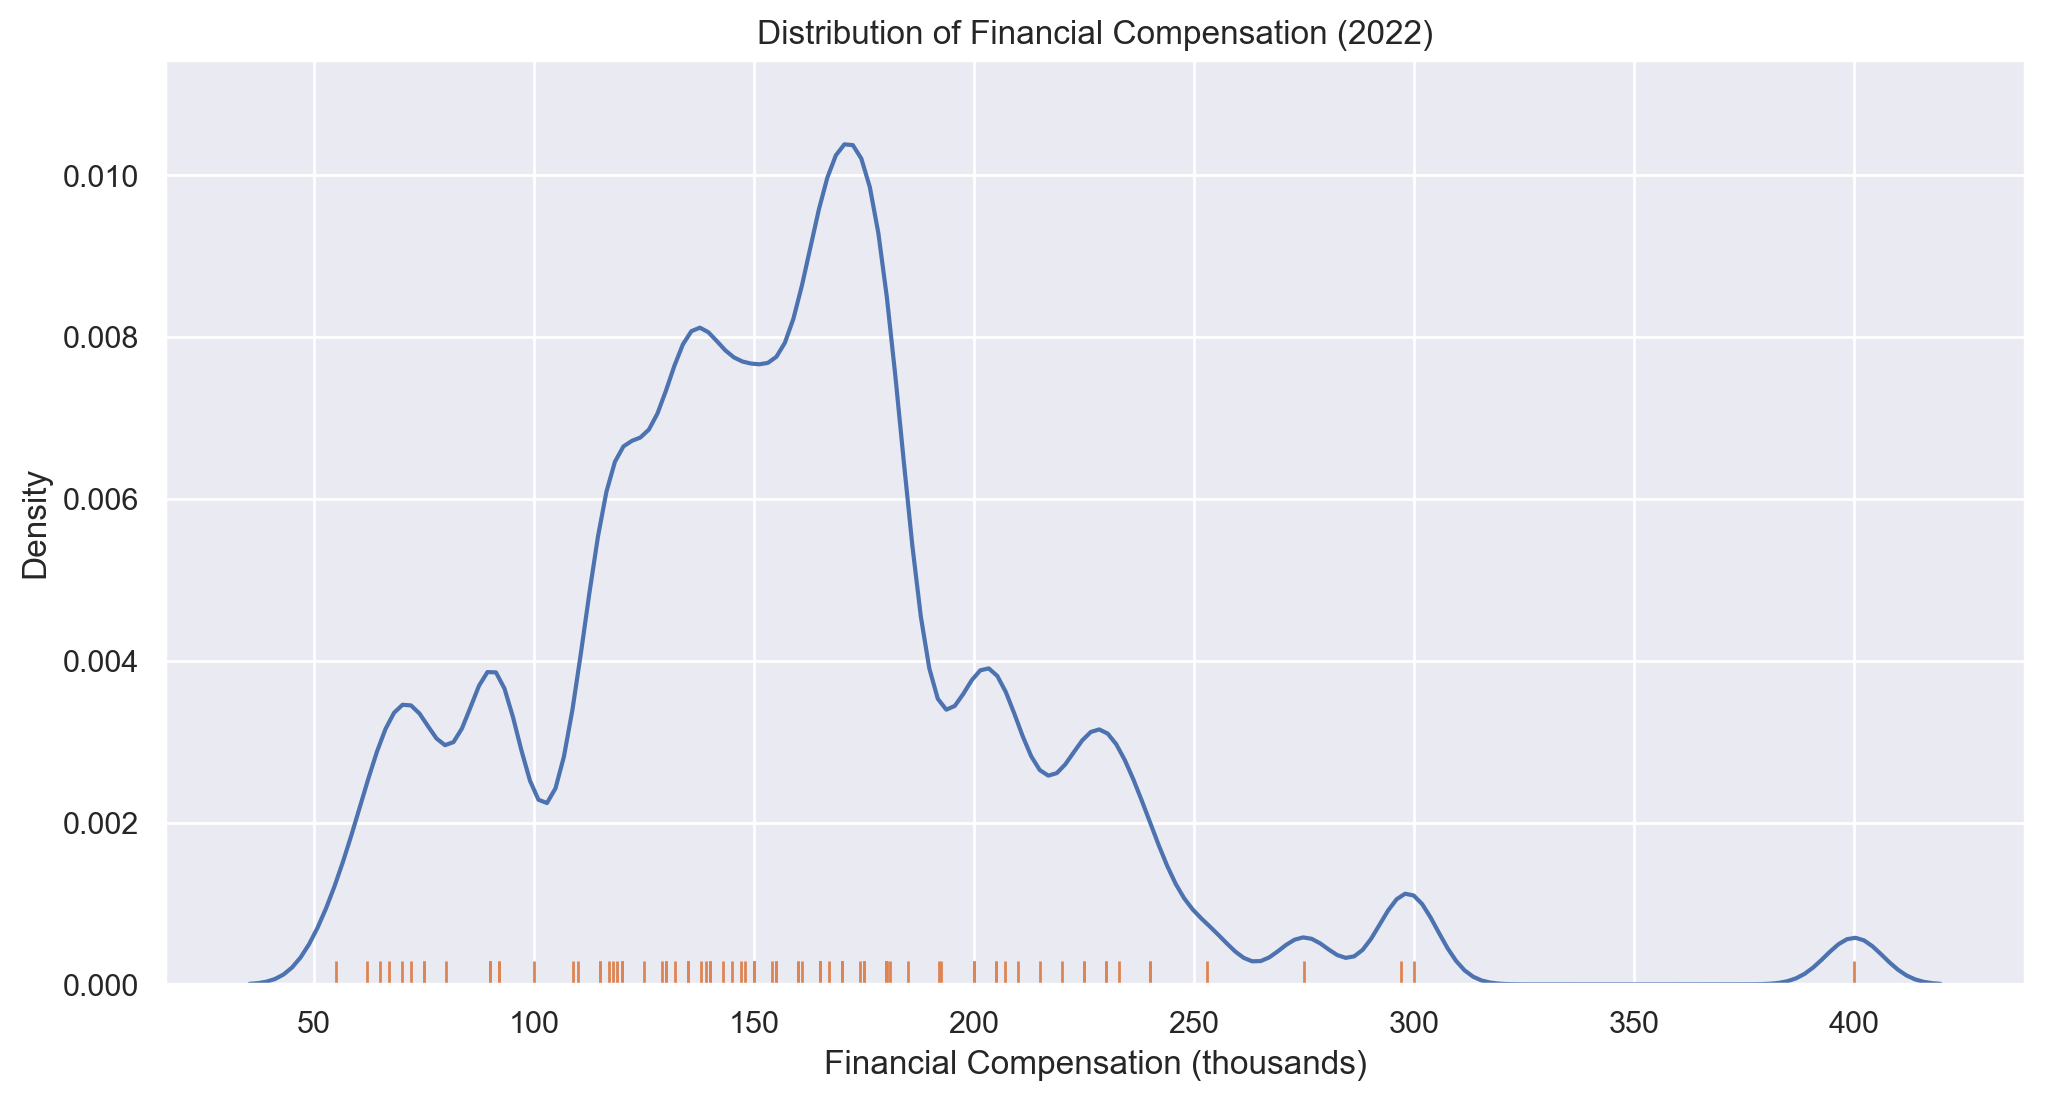

In [106]:
# display(SVG(filename="../2020/figures/job_pay.svg")) # Uncomment to compare with 2020
# display(SVG(filename="../2021/figures/job_pay.svg")) # Uncomment to compare with 2021

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['job_pay'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_pay")
plot.set(
    xlabel="Financial Compensation (thousands)",
    ylabel="Density",
    title="Distribution of Financial Compensation (2022)"
)
fn = "figures/job_pay.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))
# display(SVG("../2020/figures/job_pay.svg")) # uncomment for comparison with 2020
# display(SVG("../2019/figures/compensation.svg")) # uncomment for comparison with 2020

One of the things we're interested in this year is how average compensation has changed from previous years.

In [107]:
# Comparison with Previous Years
data2019 = pd.read_csv("../2019/2019.csv")
data2019.columns = [
    'consent_1', # important for data consent, irrelevant for analysis
    'extra', # Too sparse for stats
    'consent_2', # important for data consent, irrelevant for analysis
    'job_title', # Too sparse for stats
    'job_role', # Too sparse for stats
    'benefits_salary',
    'benefits_salary_year',
    'benefits_paid_vac_days', # many erroneous values (365)
    'benefits_bonus',
    'job_reports',
    'job_type',
    'employer_dept', # Too sparse for stats
    'employer_ownership',  # Shortened names
    'employer_fte', # Too few data points per category; not
    'loc', # Not enough diversity for stats
    'experience', # good spread
    'job_remote', # binary
    'employer_loc', # Not enough data for anything but ROC/Other
    'benefits_other', # Too sparse for stats
    'gender',
    'education',
    'identity', # multiple y/n variables requires further parsing, data sparse except for parents
    'race',
    'universities',  # Too sparse for useful stats
    'job_description',  # Too sparse for useful stats
    'job_tenure',
    'outside_income']

data2019['benefits_salary'] = data2019['benefits_salary'].replace('[\$,]', '', regex=True).astype(float)
data2019['benefits_bonus'] = data2019['benefits_bonus'].replace('[\$,]', '', regex=True).astype(float)
bonus = data2019['benefits_bonus'].to_numpy()
bonus_nas = np.isnan(data2019['benefits_bonus'])
bonus[bonus_nas] = 0
data2019['job_income'] = data2019['benefits_salary'].to_numpy() + bonus
data2019['job_pay'] = data2019['job_income'] / 1000
data2019['Year'] = pd.Series([2019 for x in range(len(data2019.index))])

data2020 = pd.read_csv("../2020/2020-cleaned.csv")
data2020.columns = [
    'timestamp', # When the survey was completed (from Google Forms)
    'consent', # important for data consent, irrelevant for analysis
    'org_type', # Public, private, or self-employed?
    'job_type', # Regular (i.e., W-2) employee or contractor?
    'org_size', # Approximately how many people work for your employer worldwide?
    'org_where', # Where is your employer located?
    'job_title', # What is your official job title?
    'job_role', # which of the following best describes your role?
    'job_description', # Please write a short description of what you do.
    'job_tenure', # How many years have you been with your current employer?
    'job_supervisor', # Do people report directly to you?
    'job_remote', # Did you work remotely (Pre-COVID)?
    'side_job', # Do you have a second job or side business?
    'tech_tenure', # How many years have you worked in the technology industry?
    'tech_jobs', # How many different jobs have you had in that time?
    'job_pay', # What is your approximate annual salary (in thousands) including bonuses?
    'job_when_negotiated', # What year was your current pay set?
    'job_hours', # How many yours do you work in an average week?
    'job_benefits', # What other kinds of compensation and benefits does your employer provide?
    'job_vacation', # If your employer offers paid vacation, how many paid days off per year?
    'side_job_pay', # If you have a second job or do outside contract work, approx. how much do you make on the side?
    'covid_actions', # What action(s) did your employer(s) take in response to COVID?
    'covid_return', # If you work(ed) remotely in response to COVID, when do you expect to be "back in the office?"
    'covid_satisfied', # How satisfied are you with your employer's response to the COVID-19 pandemic?
    'covid_changes', # Which of the following describe your personal experience with employment and COVID-19?
    'domicile', # Where do you live?  (Multiple choice general areas)
    'education', # What is the highest degree you have received?
    'school', # At which School/University did you receive this degree?
    'gender', # Gender
    'race', # Race
    'misc', # Do you identify with any of the following?
    'comments' # Do you have anything else to add?
]
data2020['Year'] = pd.Series([2020 for x in range(len(data2020.index))])

data2021 = pd.read_csv("../2021/2021.csv")
data2021.columns = [
    # Meta
    'timestamp', # When the survey was completed (from Google Forms)
    'consent', # important for data consent, irrelevant for analysis

    # Basic Employment Information
    'org_type', # Public, private, or self-employed?
    'job_type', # Regular (i.e., W-2) employee or contractor?
    'org_size', # Approximately how many people work for your employer worldwide?
    'org_where', # Where is your employer located?
    'job_title', # What is your official job title?
    'job_role', # which of the following best describes your role?
    'job_description', # Please write a short description of what you do.
    'job_tenure', # How many years have you been with your current employer?
    'job_supervisor', # Do people report directly to you?
    'remote', # Do you work remotely?  (Likert Scale)
    'remote_where', # If you work remotely, where do you do most of your work?
    'side_job', # Do you have a second job or side business?
    'tech_tenure', # How many years have you worked in the technology industry?
    'tech_jobs', # How many different jobs have you had in that time?

    # Compensation and Benefits
    'job_pay', # What is your approximate annual salary (in thousands) including bonuses?
    'job_when_negotiated', # What year was your current pay set?
    'job_hours', # How many yours do you work in an average week?
    'job_benefits', # What other kinds of compensation and benefits does your employer provide?
    'job_equity', # If your employer offers equity or options, how much do you expect they're worth?
    'job_vacation', # If your employer offers paid vacation, how many paid days off per year?
    'side_job_pay', # If you have a second job or do outside contract work, approx. how much do you make on the side?

    # Opinions on Remote Work Section
    'remote_unplug', # Remote work has made it more difficult to "unplug" after work.
    'remote_productive', # I am more productive when working from home.
    'remote_commute', # Avoiding the time and stress of a daily commute has been a big help.
    'remote_communicate', # Remote work has made communication and coordination with coworkers more difficult.
    'remote_distractions', # Distractions at home can be a significant problem.
    'remote_worklife', # Remote work has improved my work/life balance.
    'remote_focus', # It's more difficult to stay focused while working remotely.
    'remote_social', # I miss the in-person social connection of working at the office.
    'remote_different', # My employer treats remote and in-person workers differently.
    'remote_critical', # If my employer moved back to 100% in-person, I would strongly consider looking for a new job.
    'remote_permanent', # I expect the shift towards more remote work will be permanent.
    'remote_preferred', # Overall, I prefer remote work.
    'remote_ideal', # In your ideal job, how often would you come to the office in person?
    'remote_col', # Does your employer adjust pay for remote workers based on the local cost of living?

    # Demographics
    'domicile', # Where do you live?  (Multiple choice general areas)
    'education', # What is the highest degree you have received?
    'school', # At which School/University did you receive this degree?
    'gender', # Gender
    'race', # Race
    'misc', # Do you identify with any of the following?
    'vaxxed', # Are you vaccinated for COVID-19?
    'comments' # Do you have anything else to add?
]
data2021['Year'] = pd.Series([2021 for x in range(len(data2021.index))])

data2022 = data.copy()
data2022['Year'] = pd.Series([2022 for x in range(len(data2022.index))])
ts = [data2019[['job_pay', 'Year']], data2020[['job_pay', 'Year']], data2021[['job_pay', 'Year']], data2022[['job_pay', 'Year']]]
ts = pd.concat(ts)
ts['Year'] = ts['Year'].astype('category')

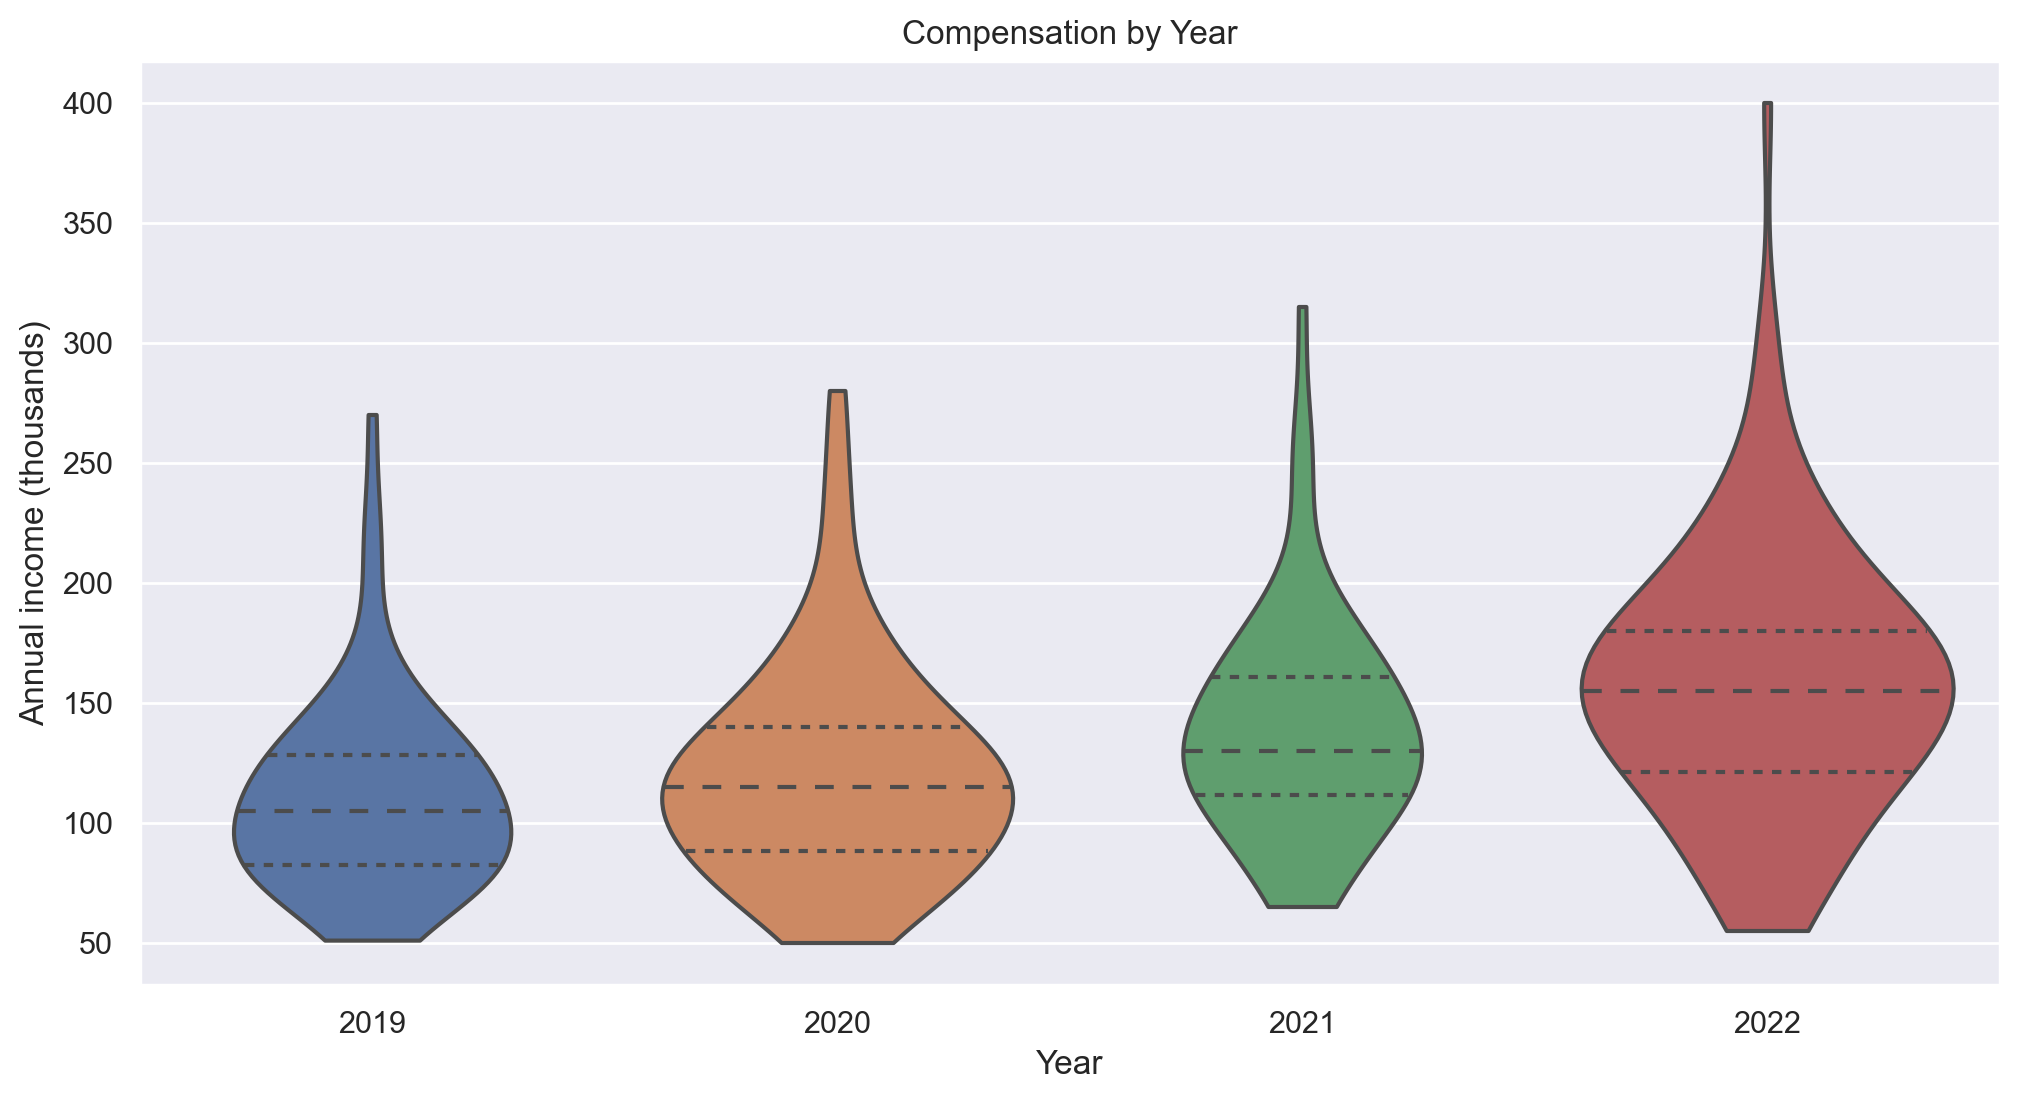

In [108]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "Year",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    data=ts
)
plot.set(
    xlabel="Year",
    ylabel="Annual income (thousands)",
    title="Compensation by Year"
)
plot.get_figure().savefig("figures/job_pay_vs_year.svg")
plt.show()

In [109]:
model = sm.ols(formula="job_pay ~ tech_tenure", data=data)
result = model.fit();
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     5.671
Date:                Tue, 07 Mar 2023   Prob (F-statistic):             0.0191
Time:                        17:55:19   Log-Likelihood:                -566.16
No. Observations:                 105   AIC:                             1136.
Df Residuals:                     103   BIC:                             1142.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     137.7613     10.293     13.384      

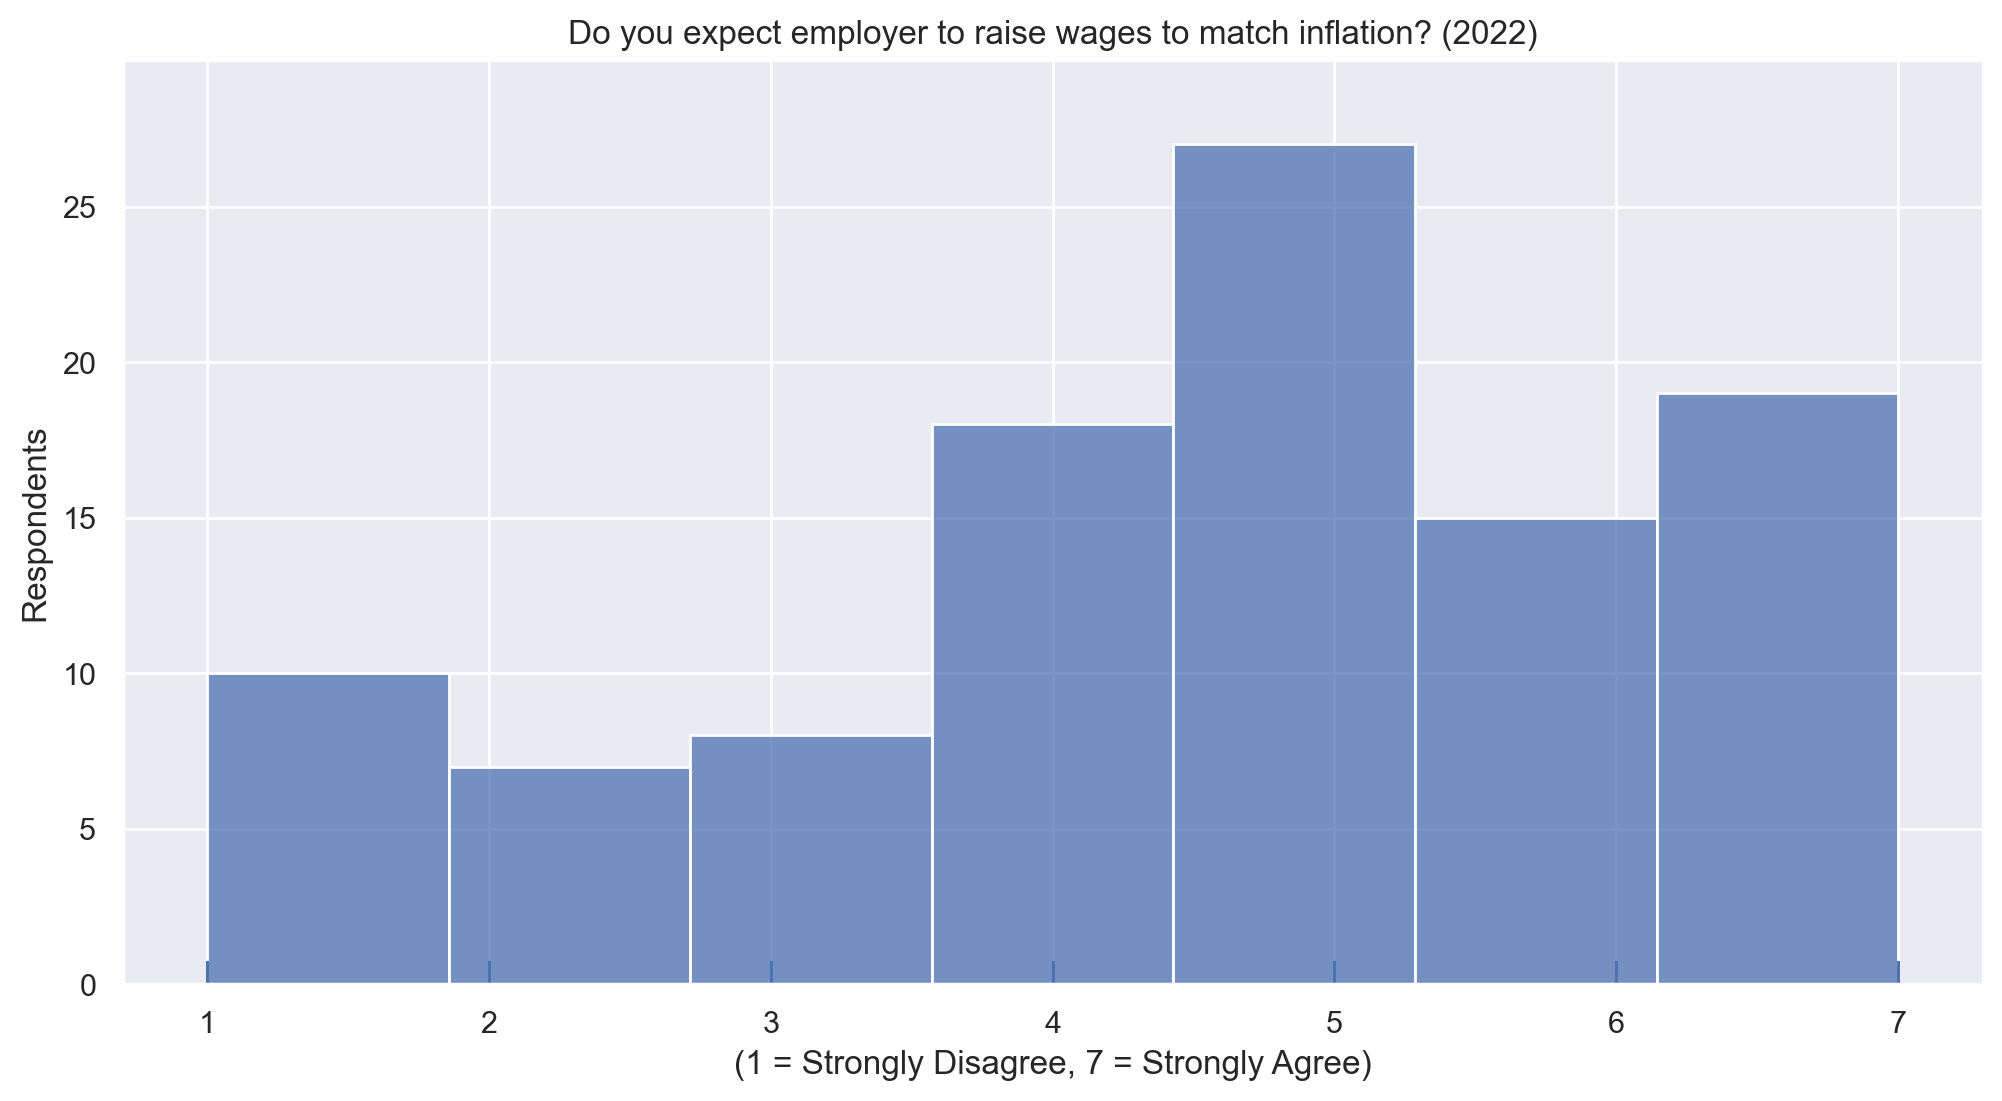

In [110]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "inflation_expect", bins=7, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="inflation_expect")

plot.set(
    xlabel="(1 = Strongly Disagree, 7 = Strongly Agree)",
    ylabel="Respondents",
    title="Do you expect employer to raise wages to match inflation? (2022)"
)
fn = "figures/inflation_expect_2022.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

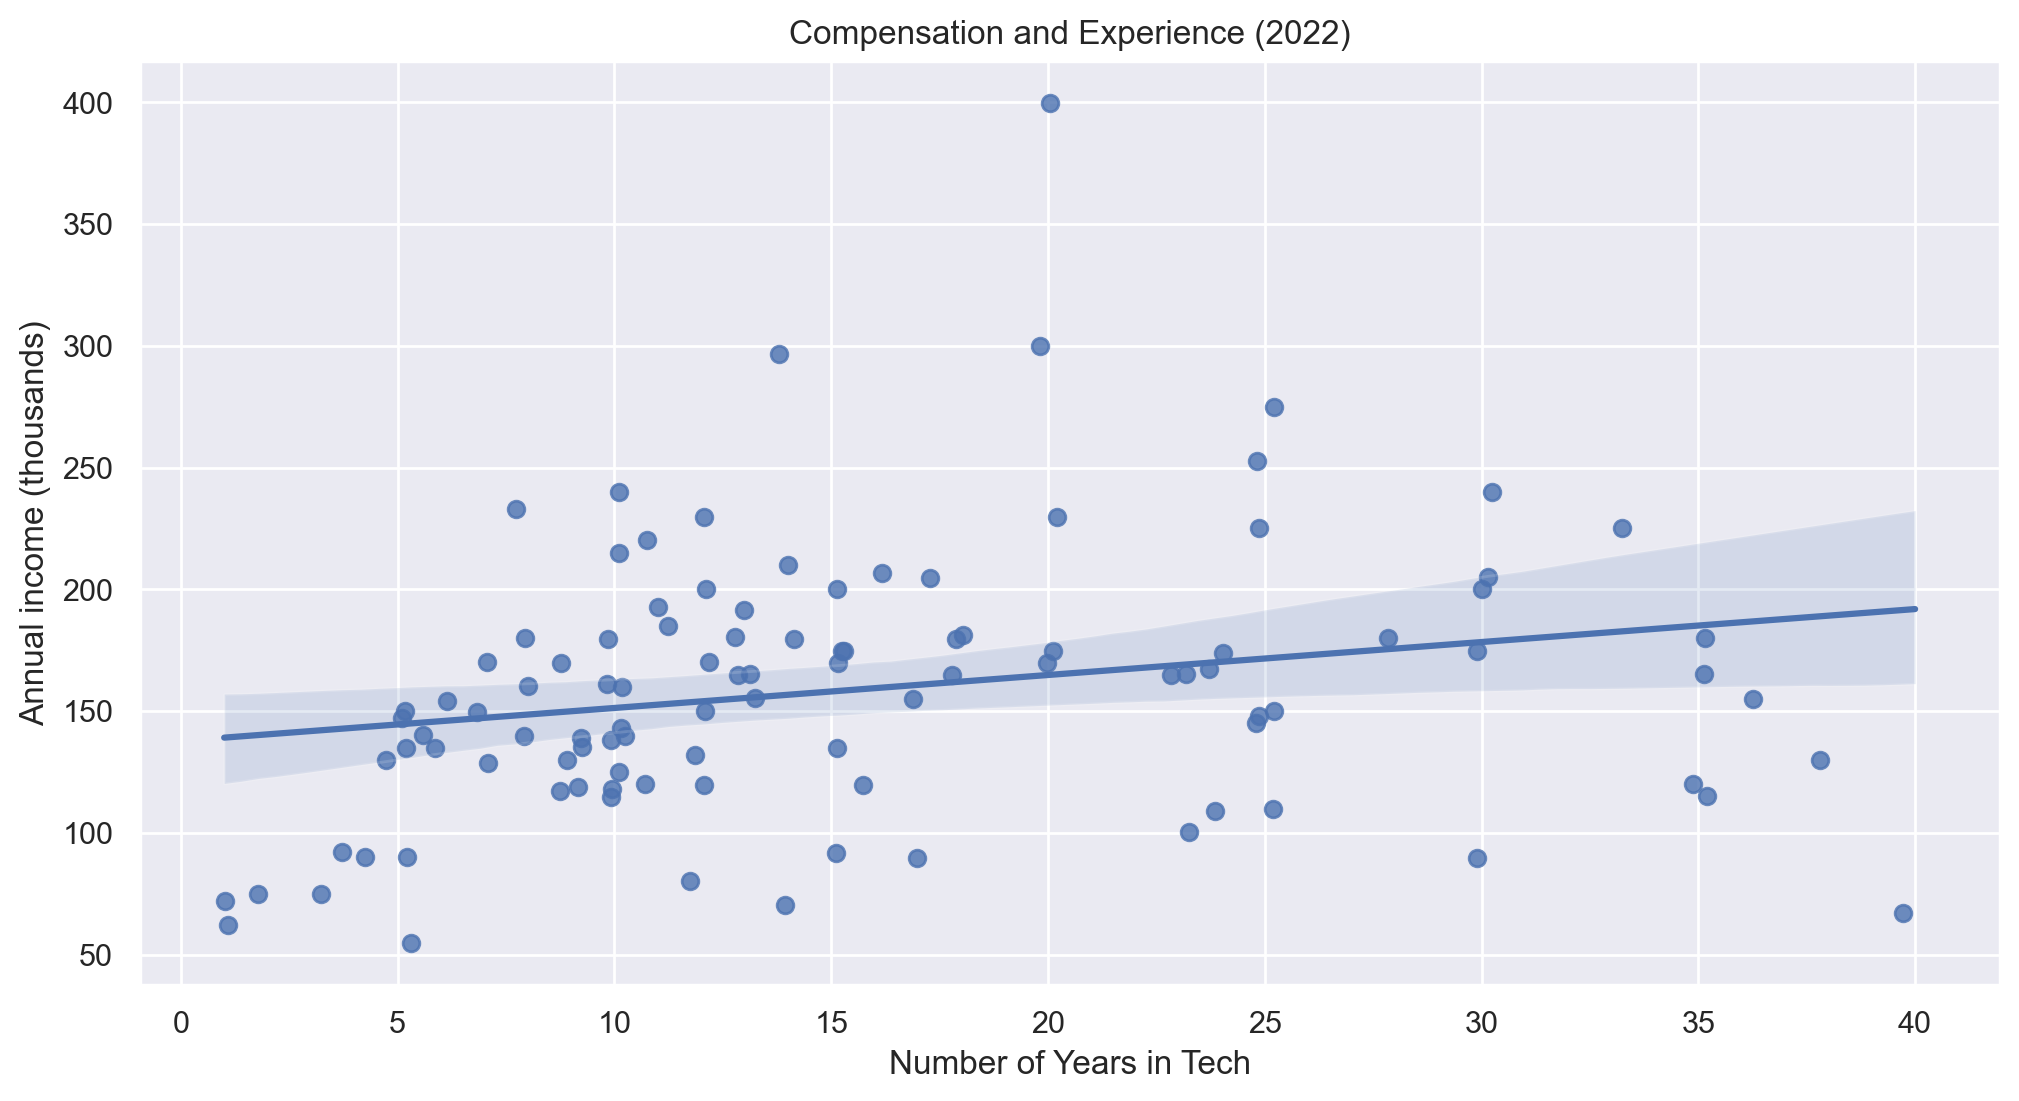

In [111]:

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "tech_tenure",
    y = "job_pay",
    x_jitter = .3,
    y_jitter = .3,
    data=data)
plot.set(
    xlabel="Number of Years in Tech",
    ylabel="Annual income (thousands)",
    title="Compensation and Experience (2022)"
)
fn = "figures/job_pay_vs_tech_tenure.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

While visualization of the data shows some apparent differences in the typical
salary across different education levels, the small number of respondents in
most categories and the large variation in salaries overall prevent making
reliable statistical inferences about these differences.

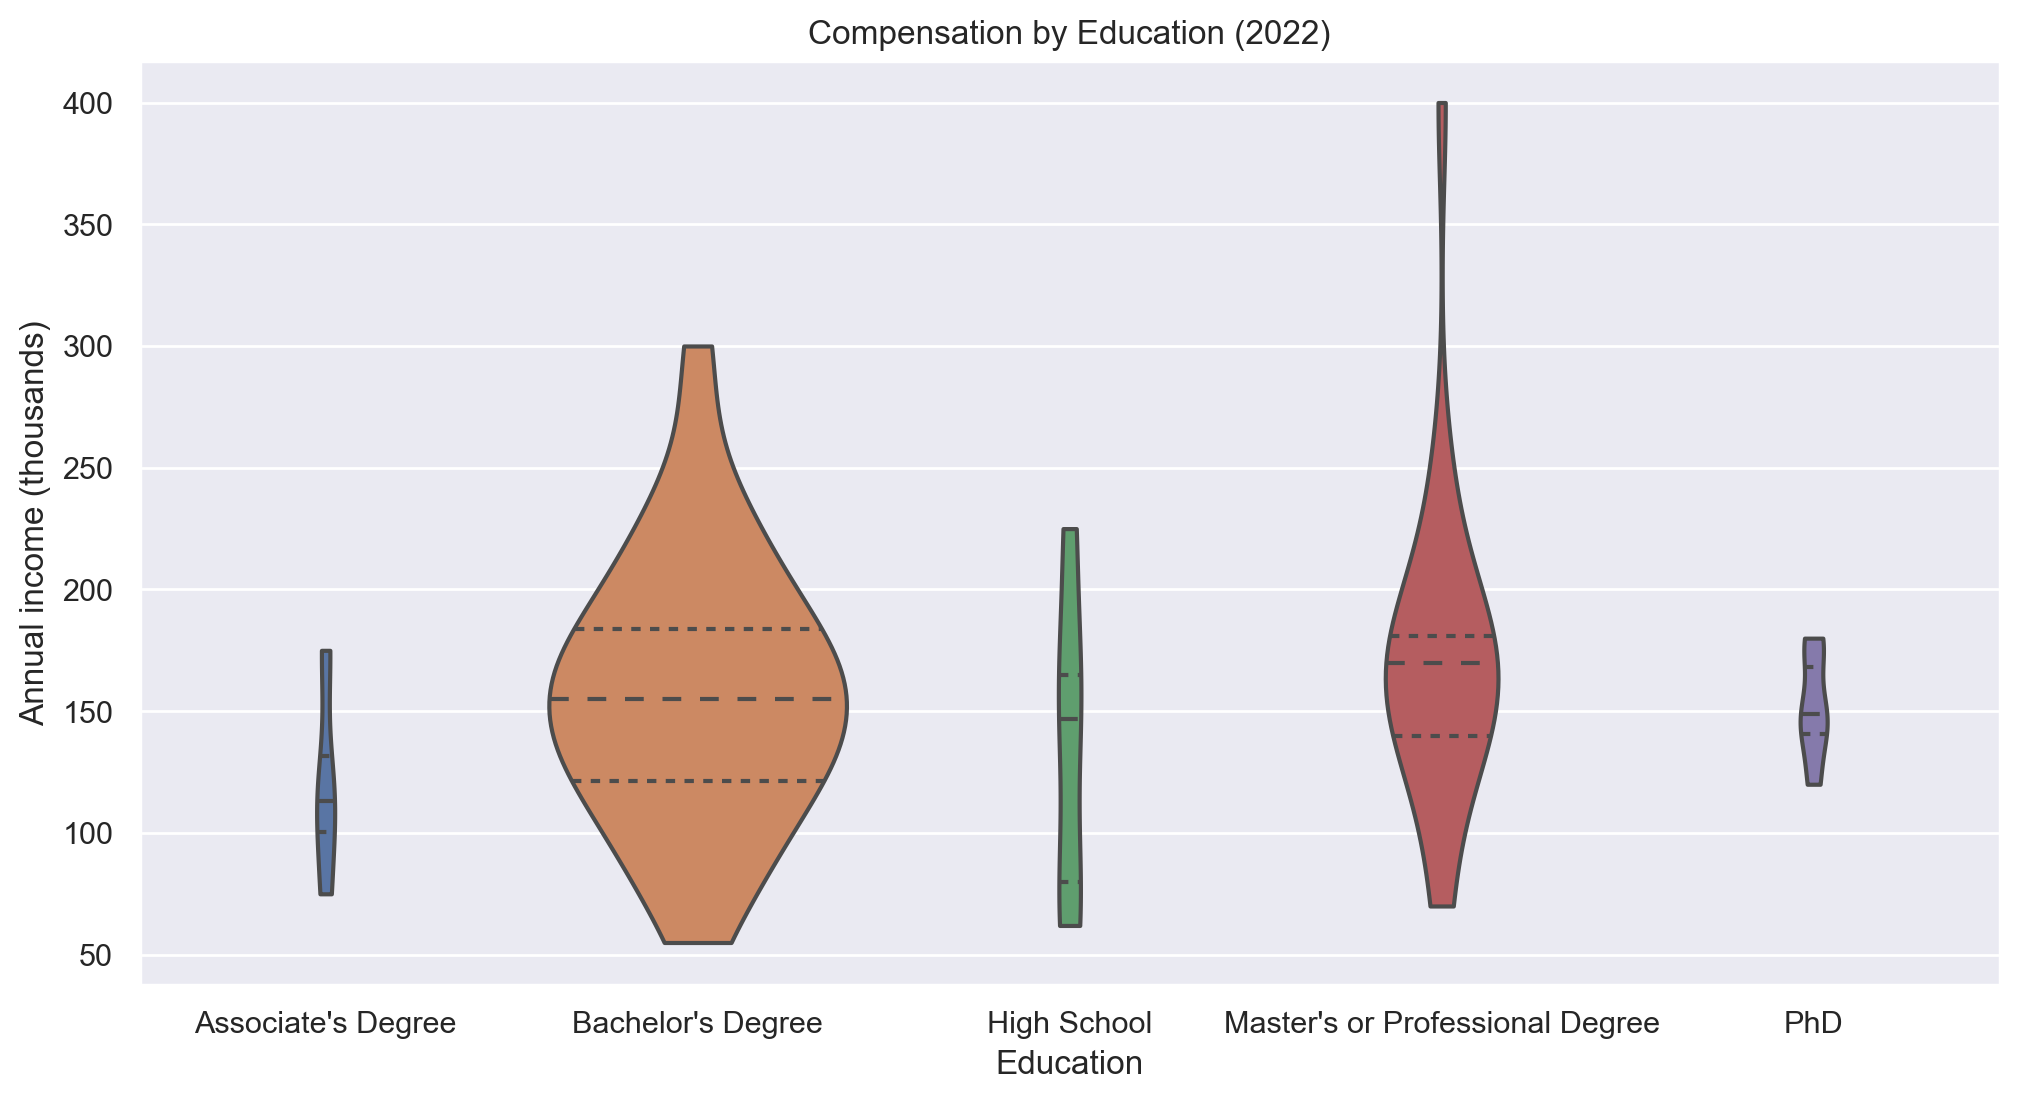

In [112]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "education",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Education",
    ylabel="Annual income (thousands)",
    title="Compensation by Education (2022)"
)
fn = "figures/job_pay_vs_education.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close("all")
# display(SVG(fn))


The same is true for comparisons between different types of work.

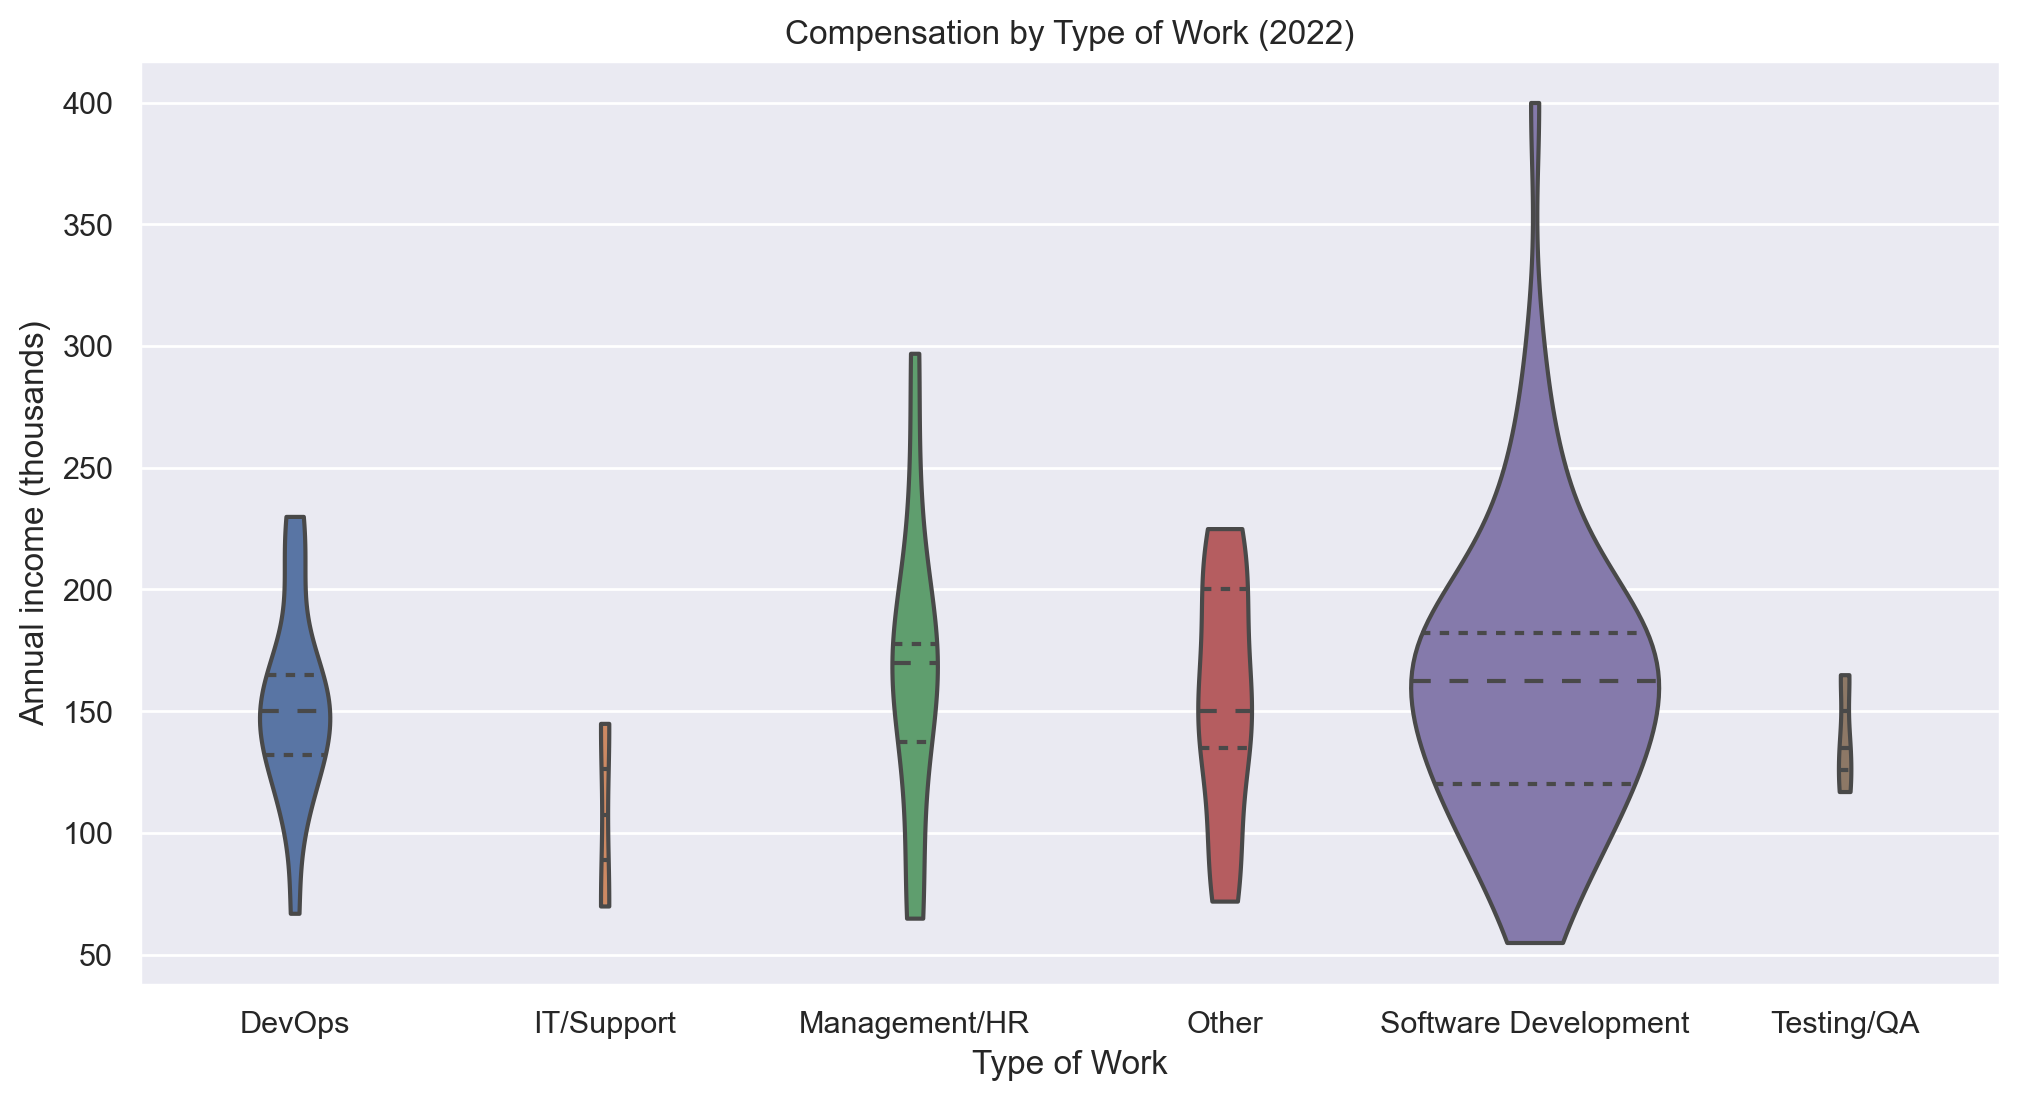

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.5265
Date:                Tue, 07 Mar 2023   Prob (F-statistic):              0.756
Time:                        17:55:20   Log-Likelihood:                -573.97
No. Observations:                 106   AIC:                             1160.
Df Residuals:                     100   BIC:                             1176.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [113]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "job_role",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Type of Work",
    ylabel="Annual income (thousands)",
    title="Compensation by Type of Work (2022)"
)
plot.get_figure().savefig("figures/job_pay_vs_job_role.svg")
plt.show()

model = sm.ols(formula="job_pay ~ job_role", data=data)
result = model.fit();
print(result.summary())

However, we can say with some confidence that, on average, remote work
pays more.

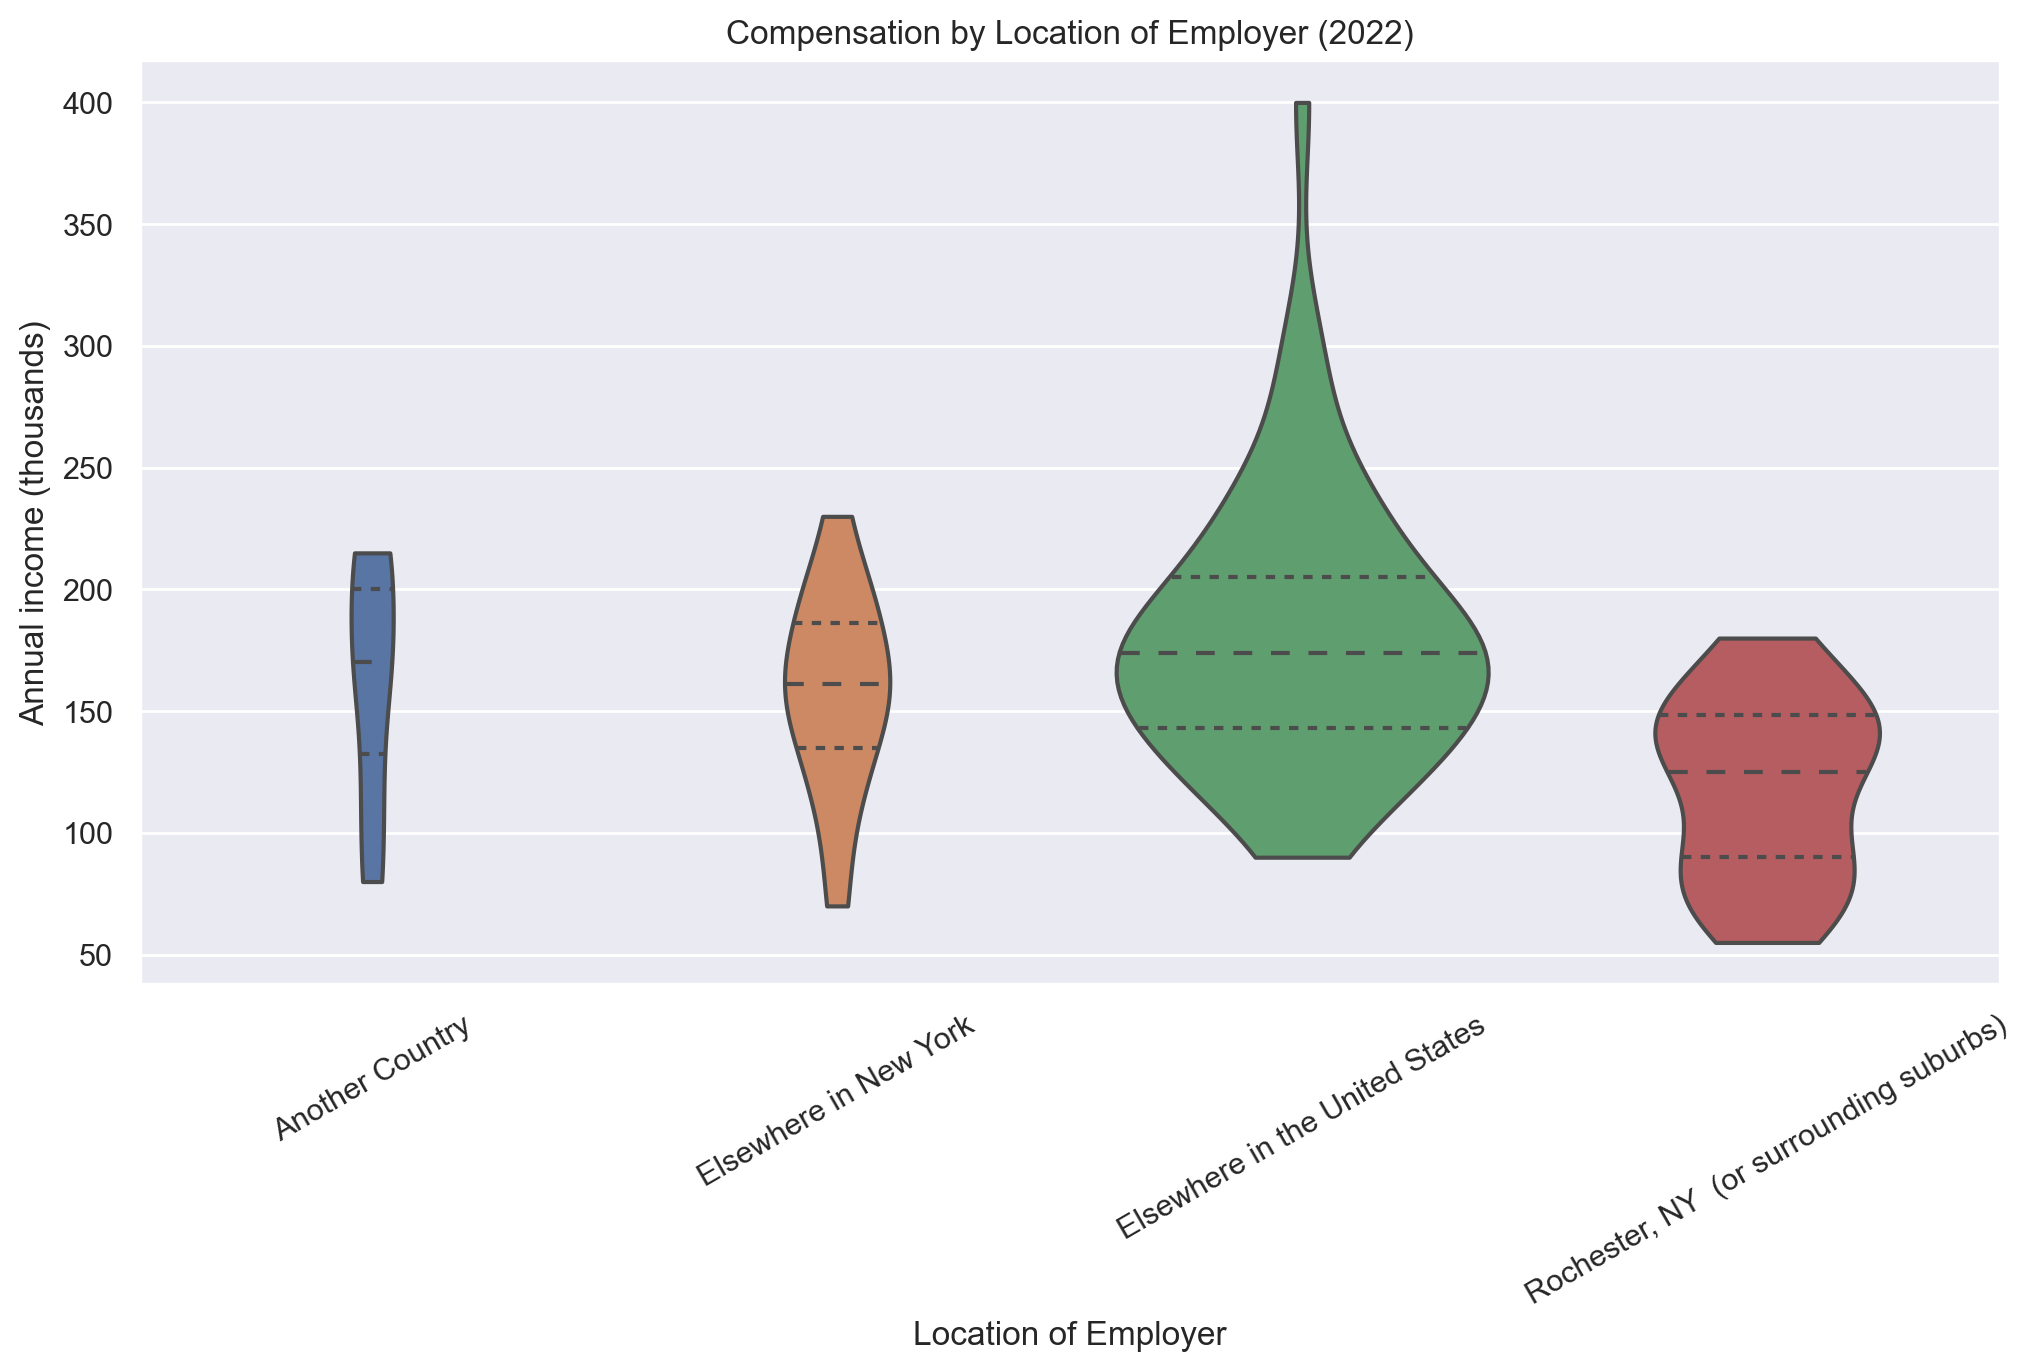

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     12.77
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           0.000535
Time:                        17:55:20   Log-Likelihood:                -569.21
No. Observations:                 106   AIC:                             1142.
Df Residuals:                     104   BIC:                             1148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.9594     23.782      3.152      0.0

In [114]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "org_where",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Location of Employer",
    ylabel="Annual income (thousands)",
    title="Compensation by Location of Employer (2022)"
)
plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
plot.get_figure().savefig("figures/job_pay_vs_org_where.svg")
plt.show()

model = sm.ols(formula="job_pay ~ remote", data=data)
result = model.fit();
print(result.summary())

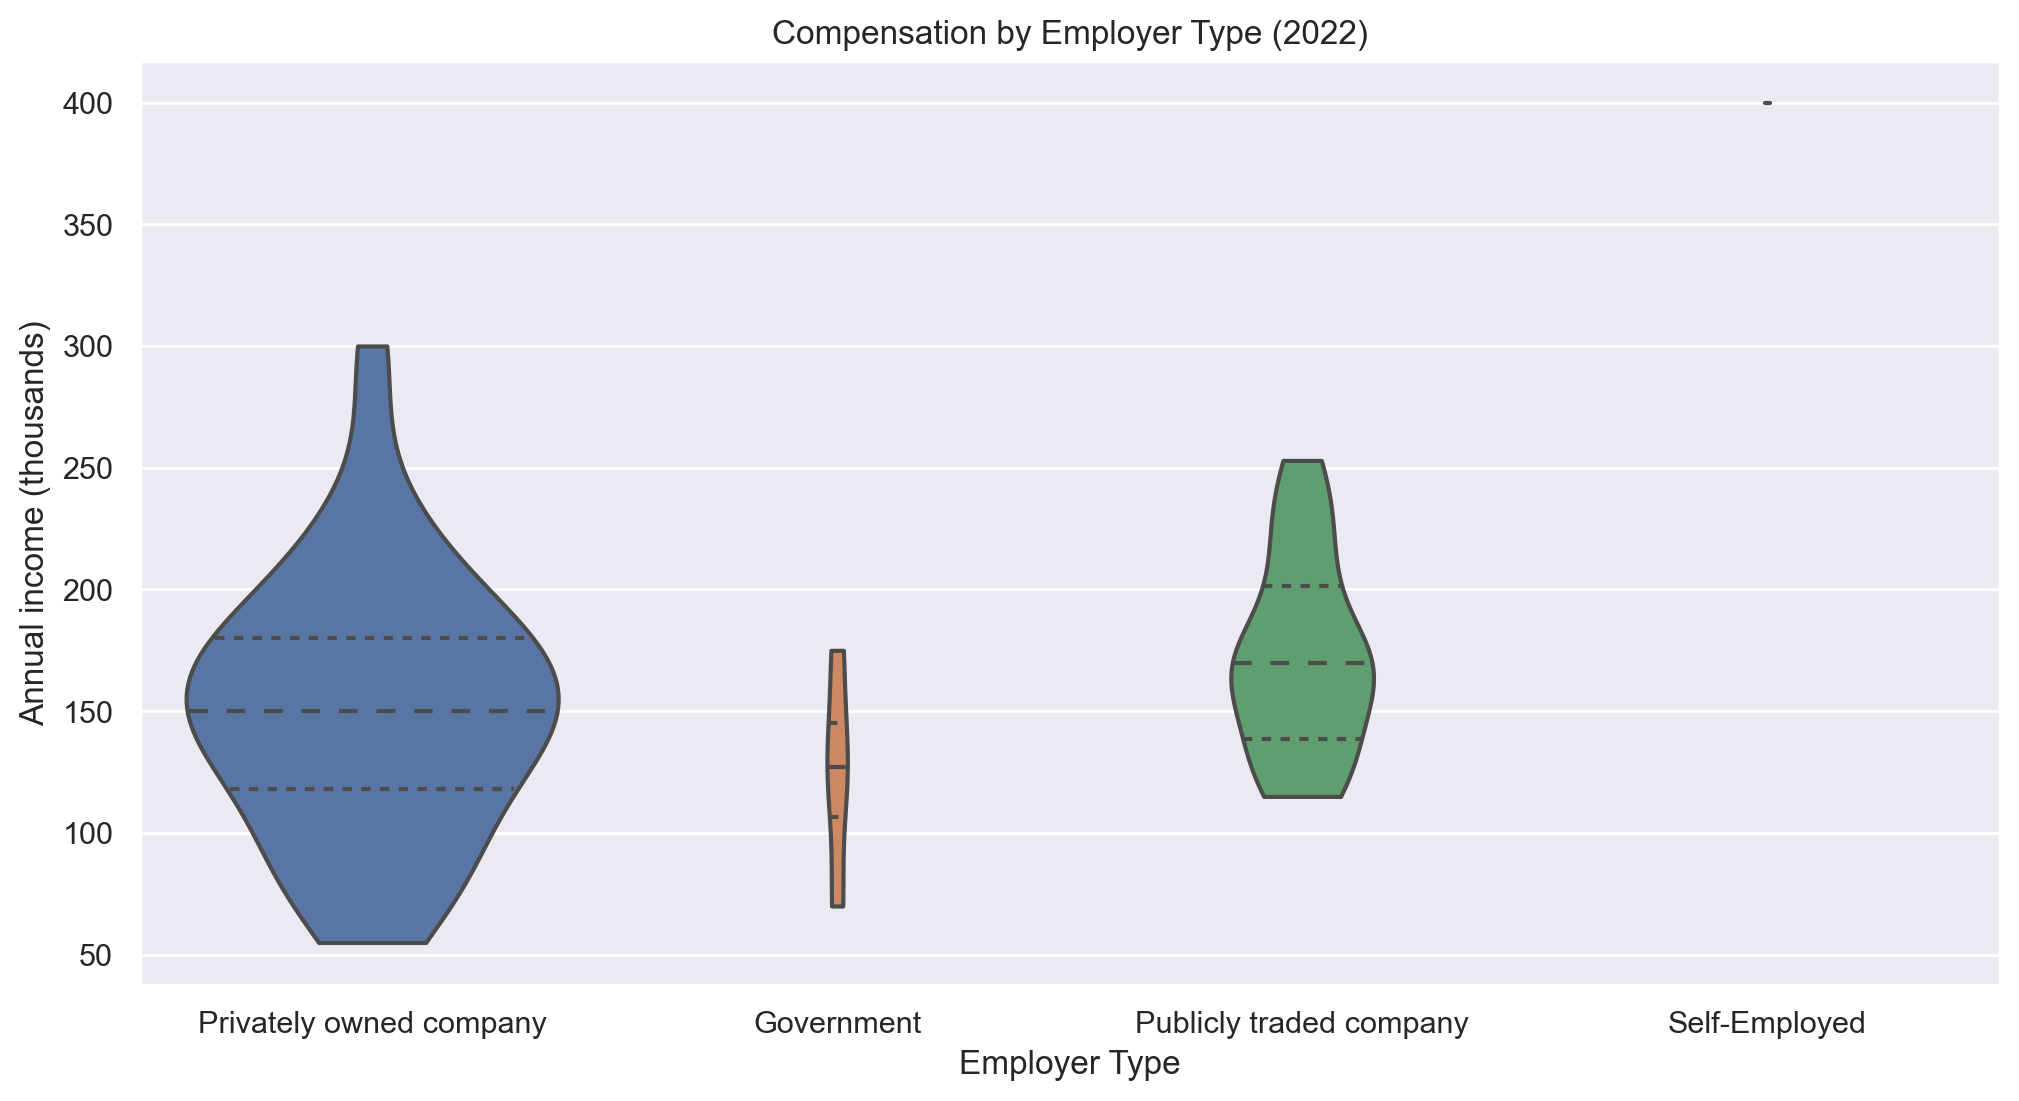

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     9.731
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           1.05e-05
Time:                        17:55:20   Log-Likelihood:                -562.01
No. Observations:                 106   AIC:                             1132.
Df Residuals:                     102   BIC:                             1143.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [115]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "org_type",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Employer Type",
    ylabel="Annual income (thousands)",
    title="Compensation by Employer Type (2022)"
)
plot.get_figure().savefig("figures/job_pay_vs_org_type.svg")
plt.show()

model = sm.ols(formula="job_pay ~ org_type", data=data)
result = model.fit();
print(result.summary())

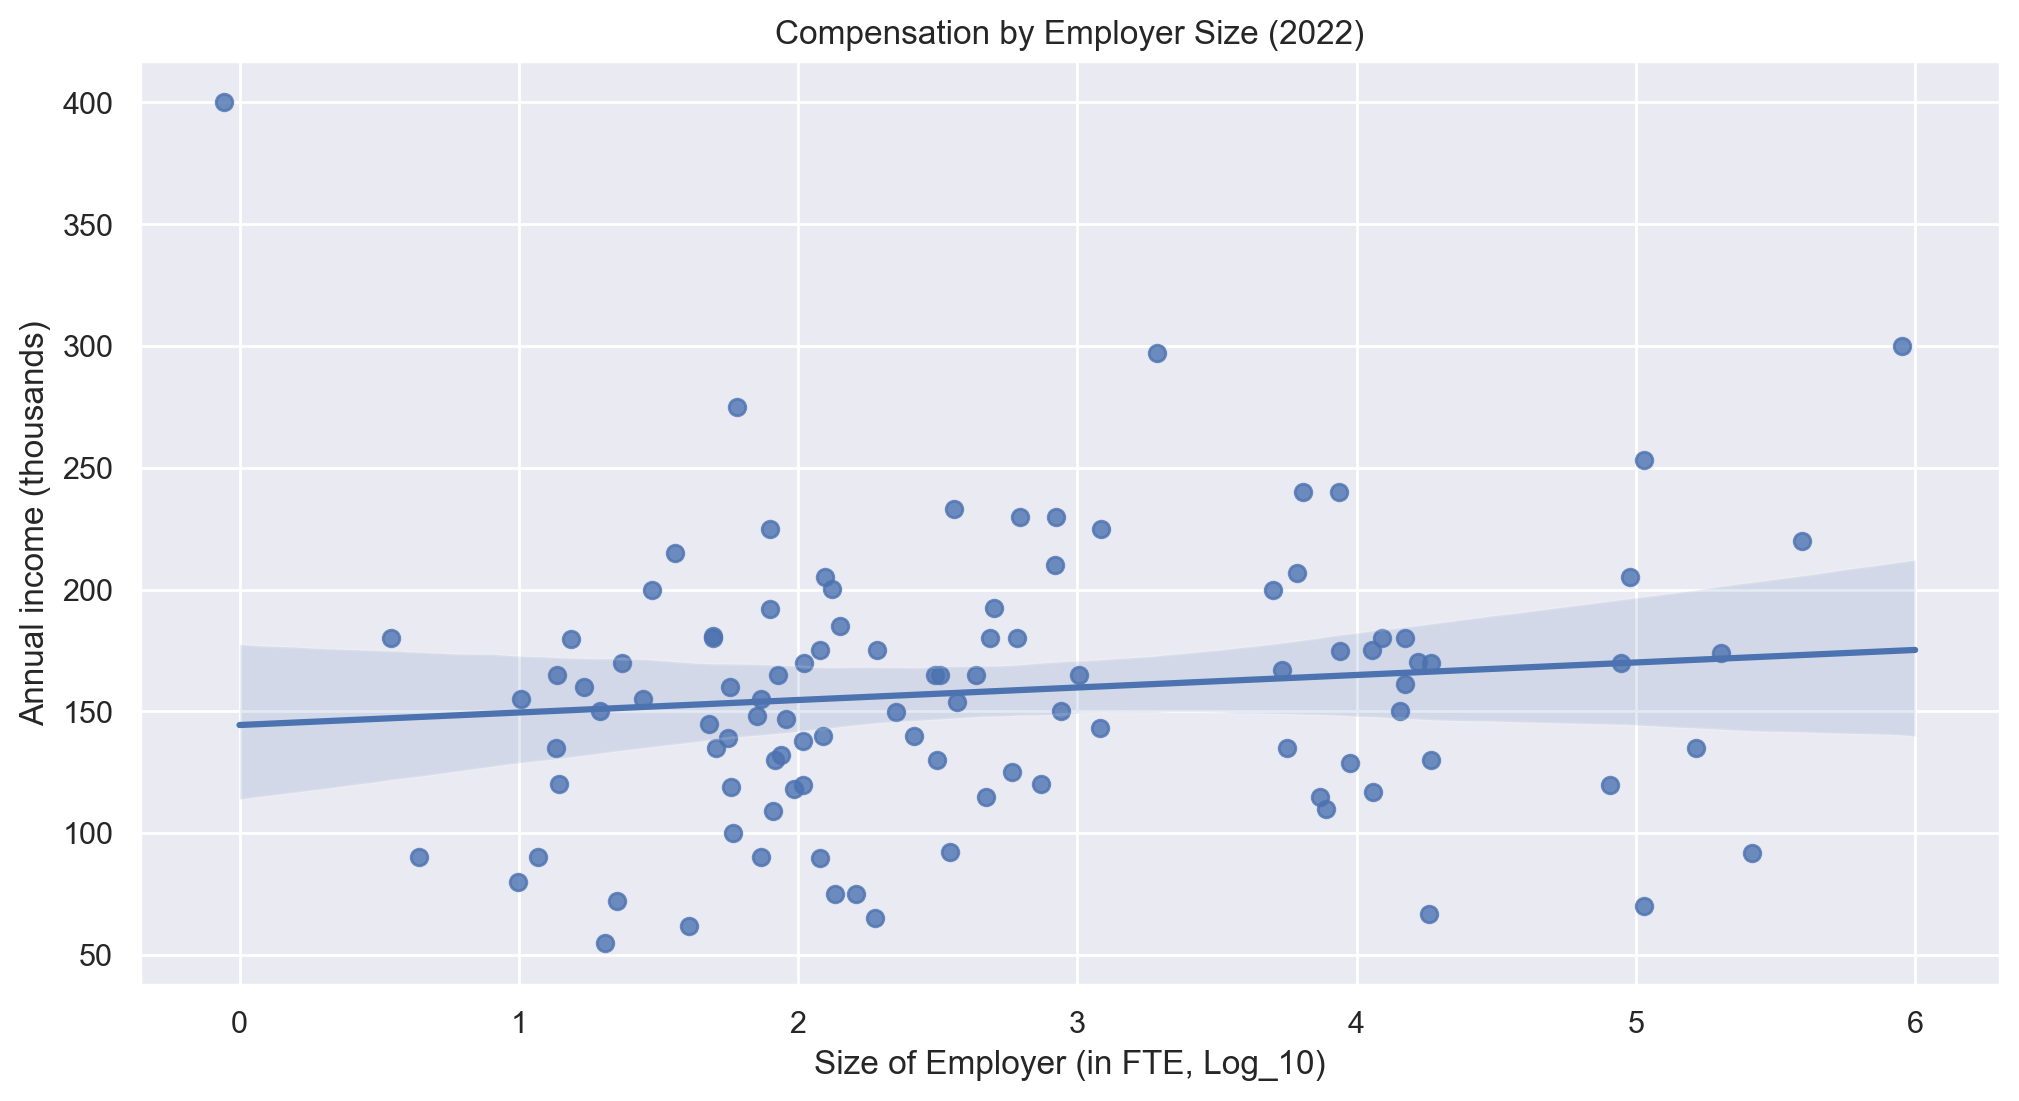

In [116]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "log_org_size",
    y = "job_pay",
    fit_reg=True,
    x_jitter = 0.1,
    y_jitter = 0.1,
    data=data)
plot.set(
    xlabel="Size of Employer (in FTE, Log_10)",
    ylabel="Annual income (thousands)",
    title="Compensation by Employer Size (2022)"
)
plot.get_figure().savefig("figures/job_pay_vs_org_size.svg")
plt.show()
plt.close('all')

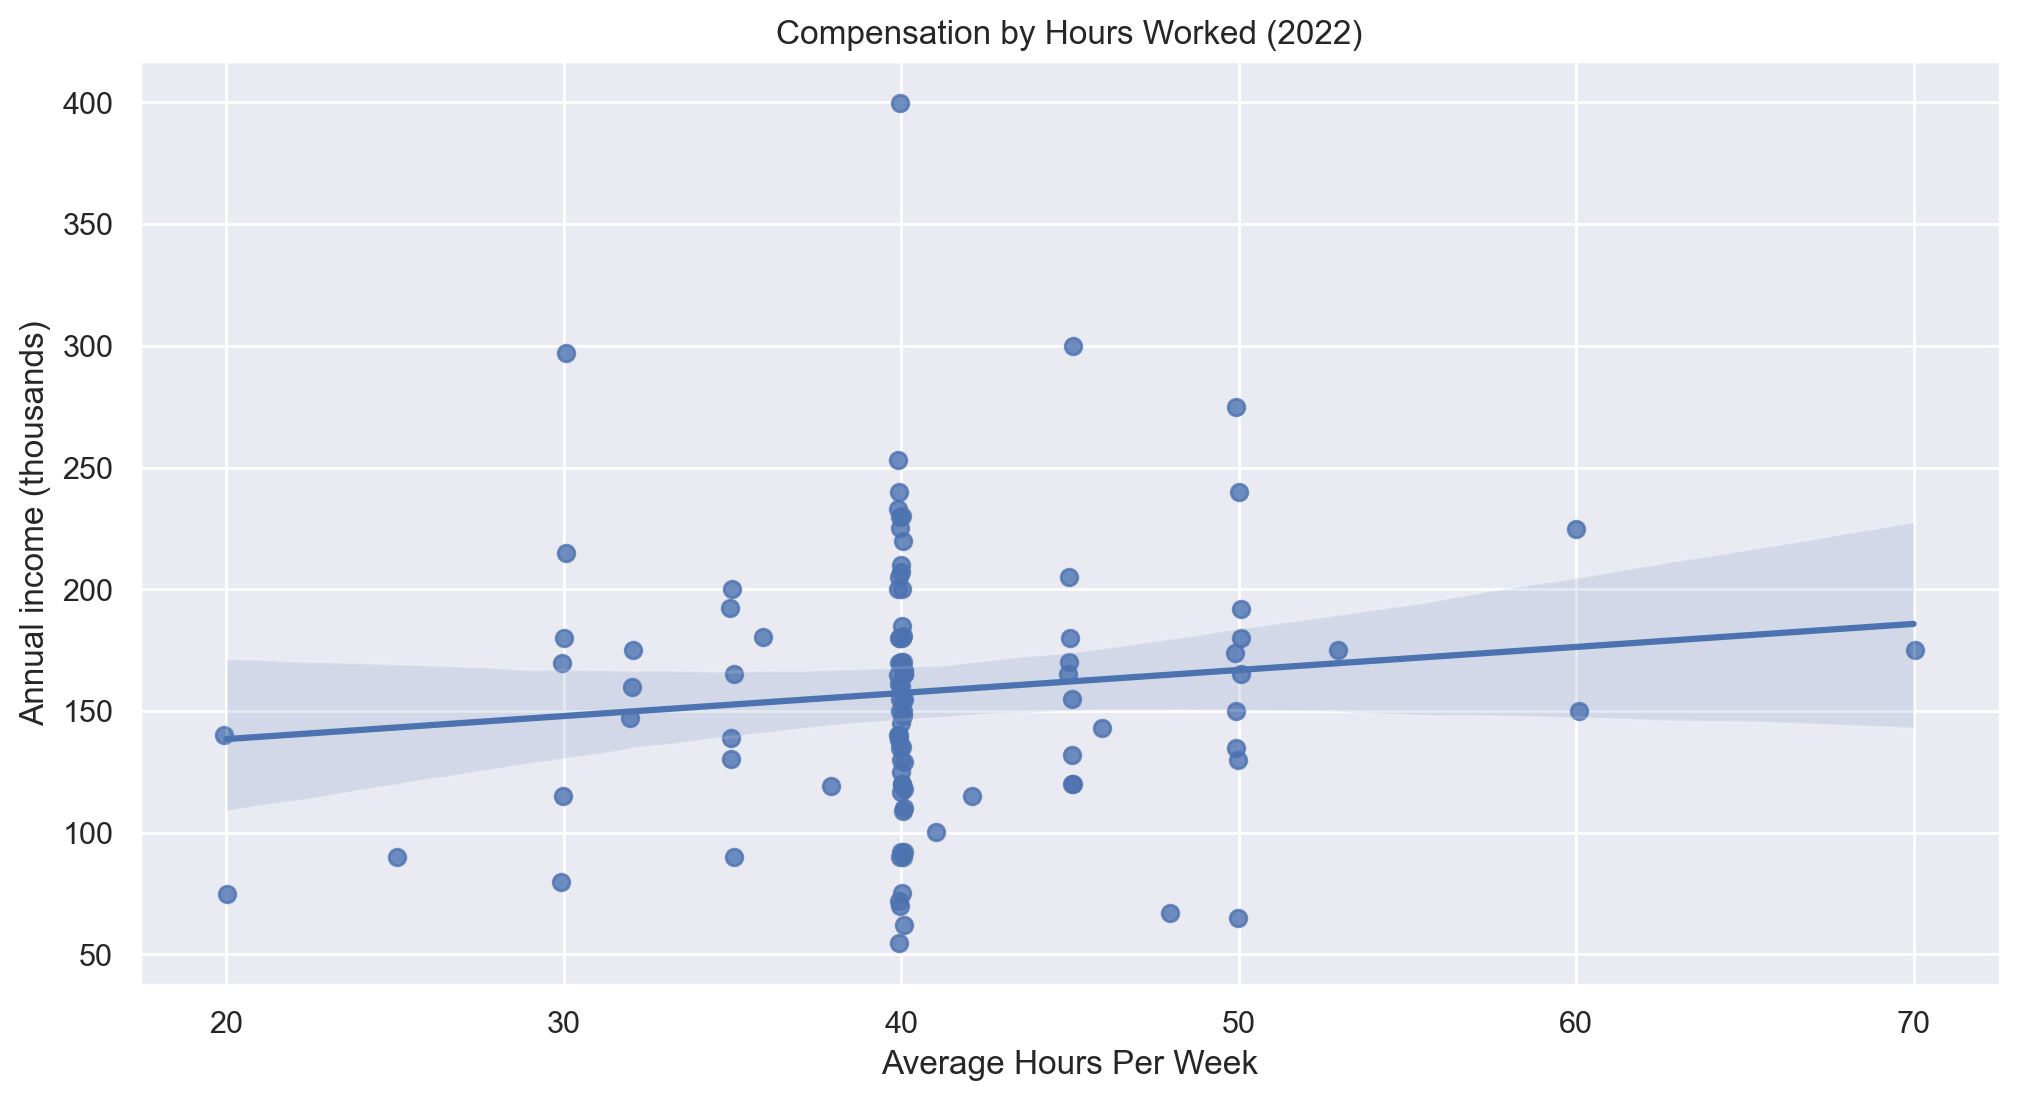

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.485
Date:                Tue, 07 Mar 2023   Prob (F-statistic):              0.226
Time:                        17:55:21   Log-Likelihood:                -564.60
No. Observations:                 104   AIC:                             1133.
Df Residuals:                     102   BIC:                             1138.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.5388     32.060      3.729      0.0

In [117]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "job_hours",
    y = "job_pay",
    fit_reg=True,
    x_jitter = 0.1,
    y_jitter = 0.1,
    data=data)
plot.set(
    xlabel="Average Hours Per Week",
    ylabel="Annual income (thousands)",
    title="Compensation by Hours Worked (2022)"
)
plot.get_figure().savefig("figures/job_hours_vs_pay.svg")
plt.show()
plt.close('all')

model = sm.ols(formula="job_pay ~ job_hours", data=data)
result = model.fit();
print(result.summary())

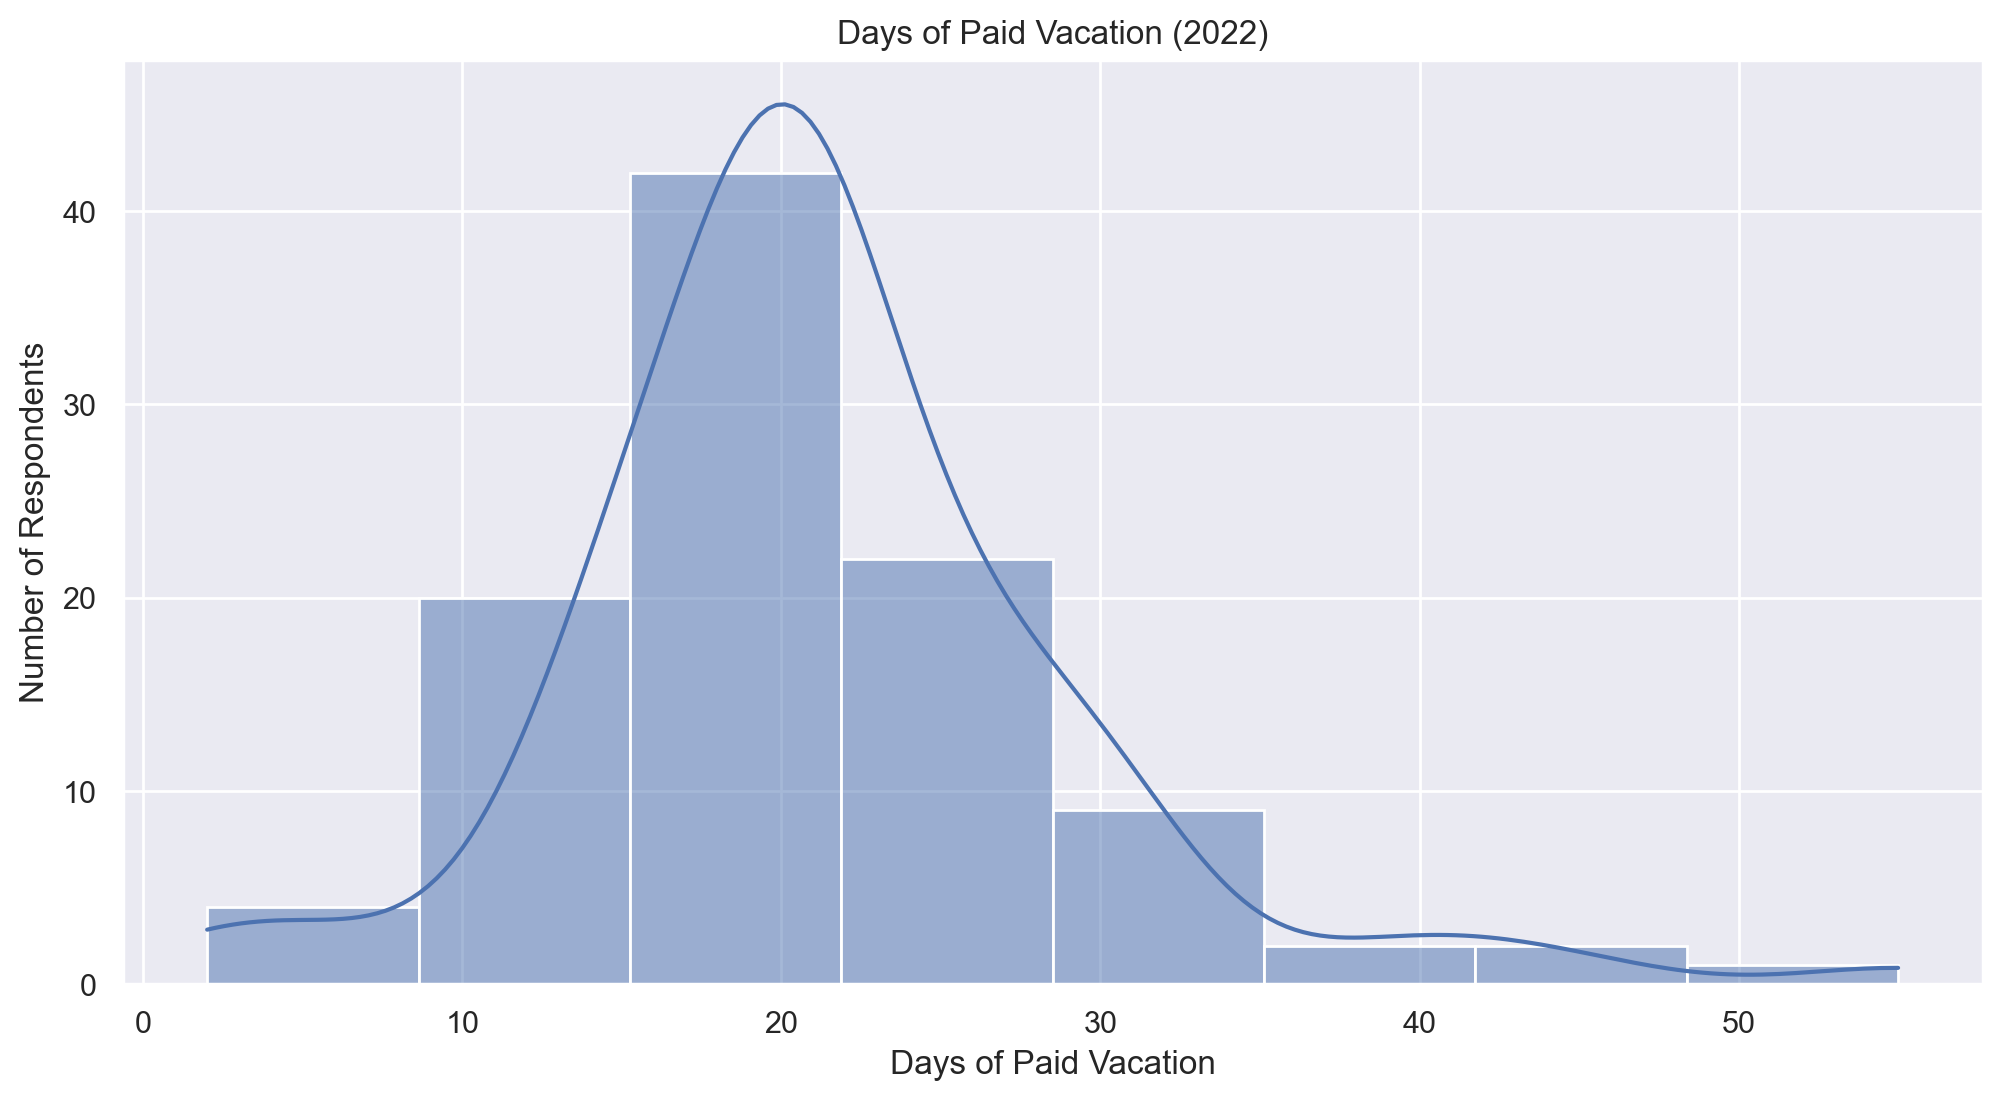

In [118]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "job_vacation", bins=8, kde=True, data=data)
plot.set(
    xlabel="Days of Paid Vacation",
    ylabel="Number of Respondents",
    title="Days of Paid Vacation (2022)"
)
plot.get_figure().savefig("figures/job_vacation.svg")
plt.show()

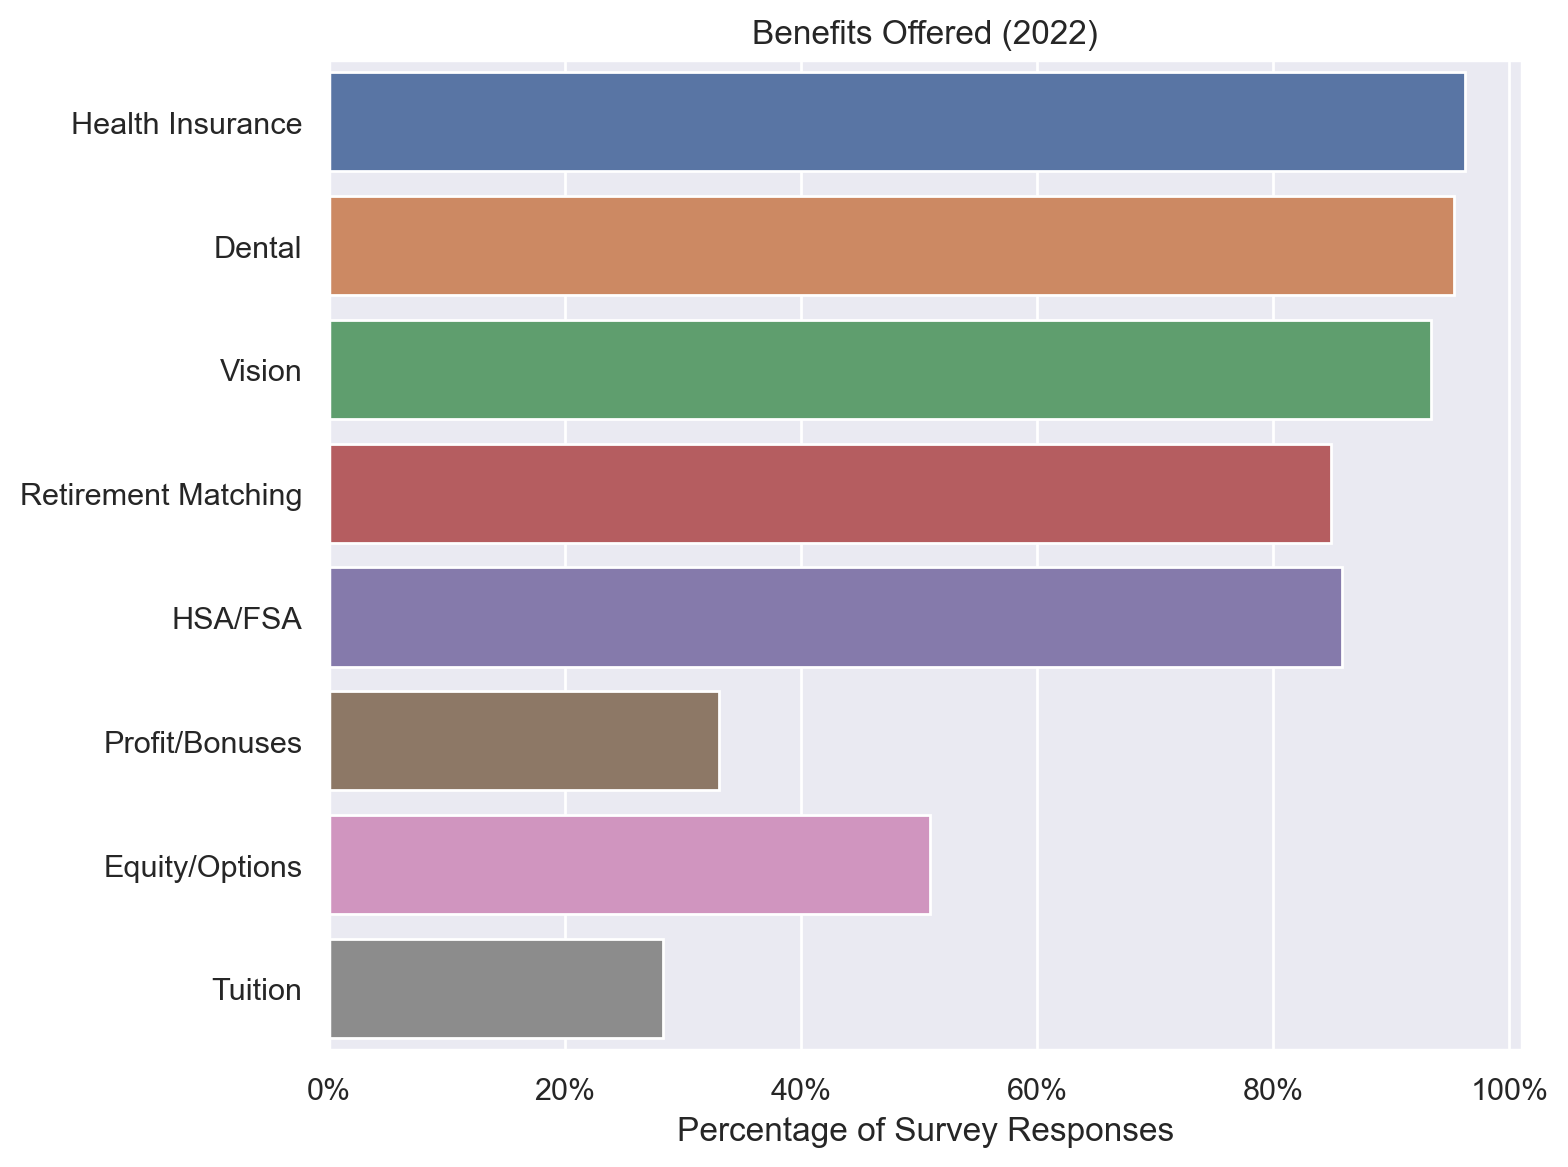

In [119]:
benefit_labels = [
    "Health Insurance",
    "Dental",
    "Vision",
    "Retirement Matching",
    "HSA/FSA",
    "Profit/Bonuses",
    "Equity/Options",
    "Tuition",
]
benefit_percentages = [
    data['benefits_health'].mean() * 100,
    data['benefits_dental'].mean() * 100,
    data['benefits_vision'].mean() * 100,
    data['benefits_retirement_matching'].mean() * 100,
    data['benefits_hsa'].mean() * 100,
    data['benefits_profit_sharing'].mean() * 100,
    data['benefits_equity_options'].mean() * 100,
    data['benefits_tuition'].mean() * 100,
]
benefits_df = pd.DataFrame({'Benefit': benefit_labels, 'Percentage':benefit_percentages })

plt.figure(figsize=(8,6), dpi=200)
plot = sns.barplot(y="Benefit", x="Percentage", data=benefits_df)
plot.xaxis.set_major_formatter(mtick.PercentFormatter())
plot.set(
    xlabel="Percentage of Survey Responses",
    ylabel="",
    title="Benefits Offered (2022)"
)
plt.tight_layout()
plot.get_figure().savefig("figures/benefits.svg")
plt.show()
plt.close('all')


# Misc

## Economic Conditions

Several high-profile technology companies have gone through layoffs in the past year.  We wanted to know if this reflected a broader trend in the industry among our employers.  Only a few people reported working for a company that had layoffs recently, though there was a substantial number of firms who were not doing any hiring.  However, over half of our employers were still hiring for growth, and another 25% were hiring to replace people who moved on to other opportunities.


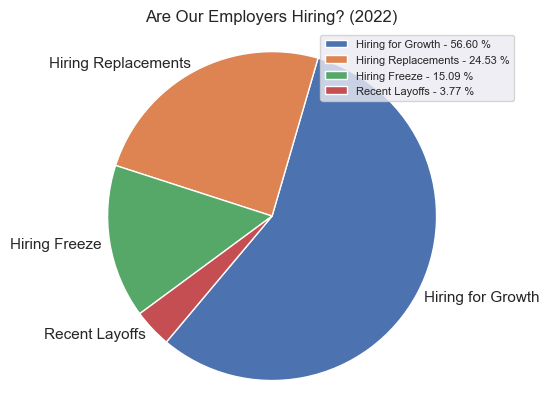

<Figure size 1200x1200 with 0 Axes>

In [120]:
mmpie(data, "org_hiring", "Are Our Employers Hiring? (2022)", 230, "upper right", ["Hiring for Growth", "Hiring Replacements", "Hiring Freeze", "Recent Layoffs"])

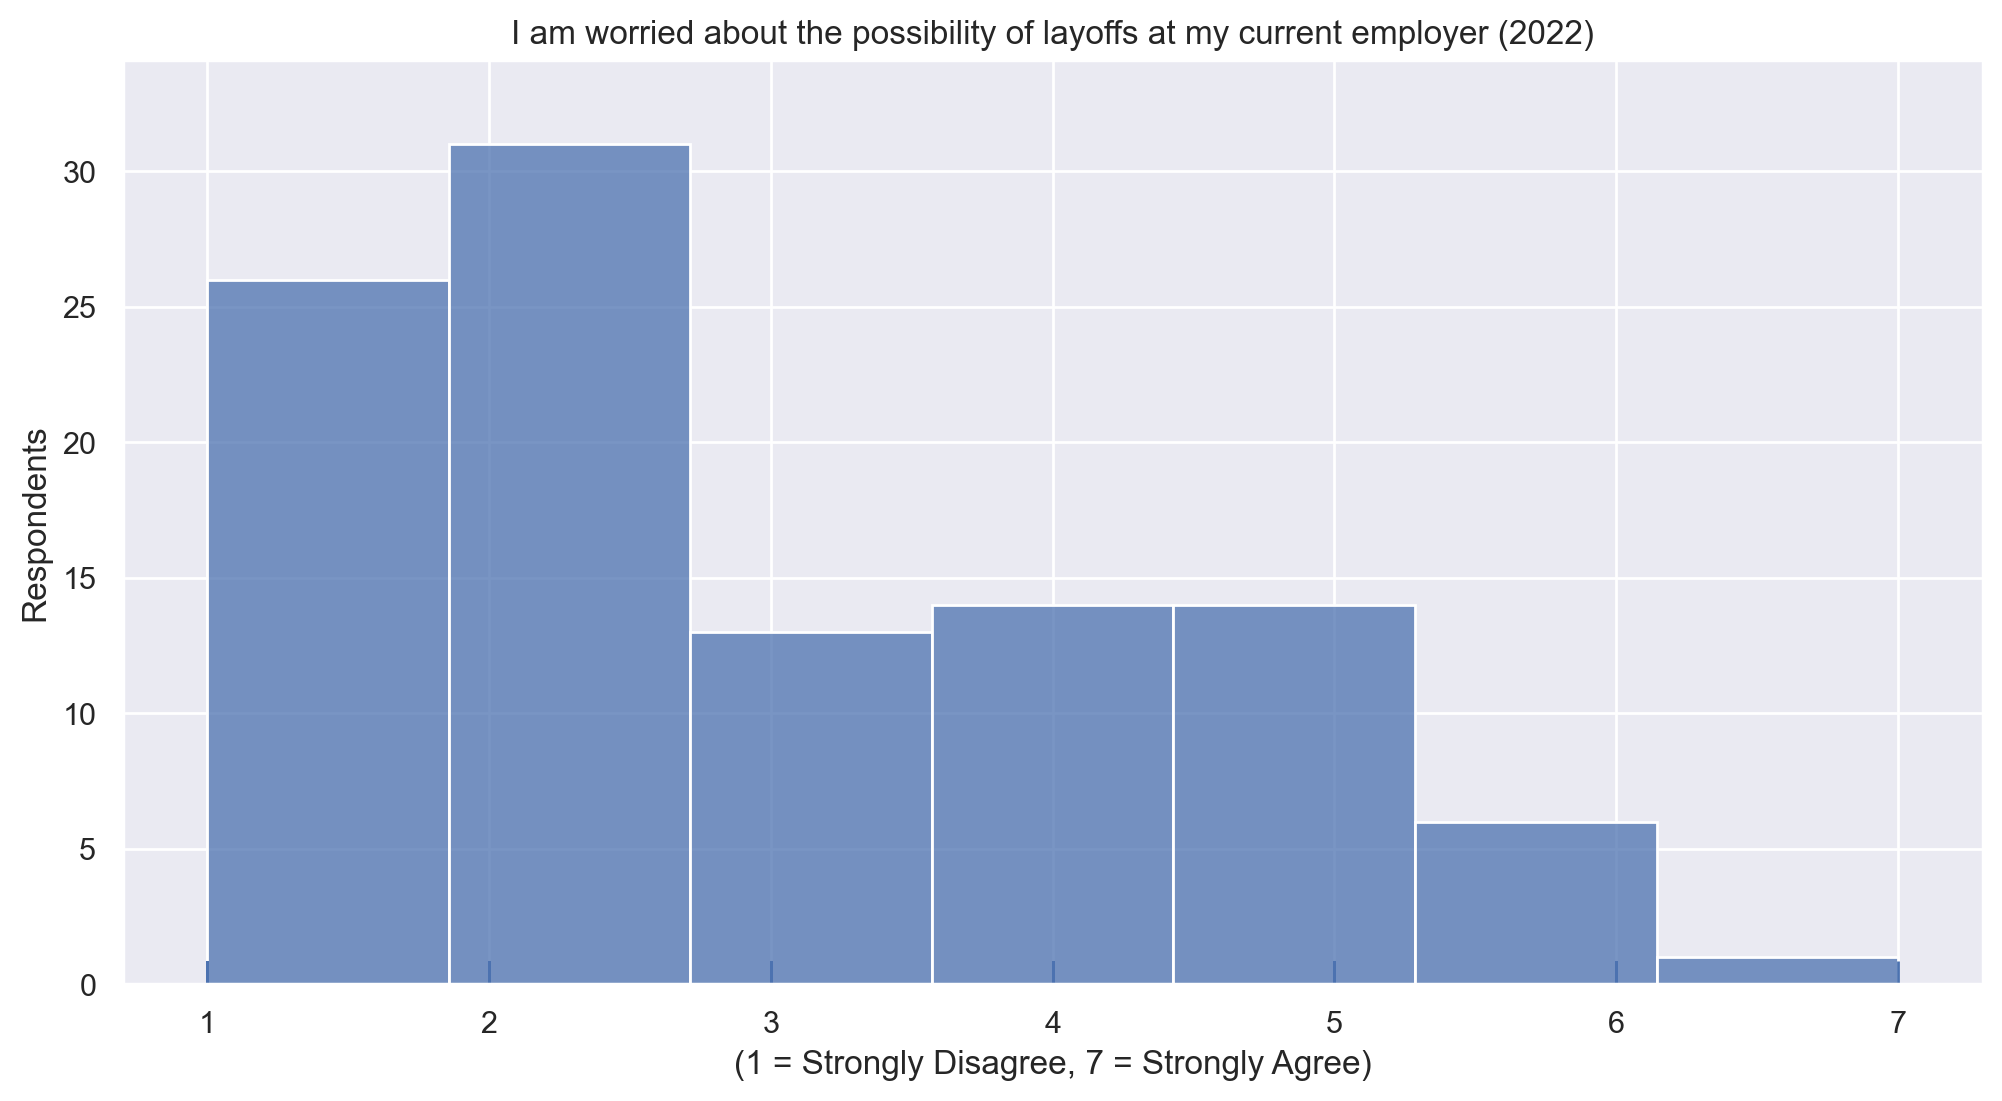

In [121]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "layoffs_worry", bins=7, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="layoffs_worry")

plot.set(
    xlabel="(1 = Strongly Disagree, 7 = Strongly Agree)",
    ylabel="Respondents",
    title="I am worried about the possibility of layoffs at my current employer (2022)"
)
fn = "figures/layoffs_worry_2022.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

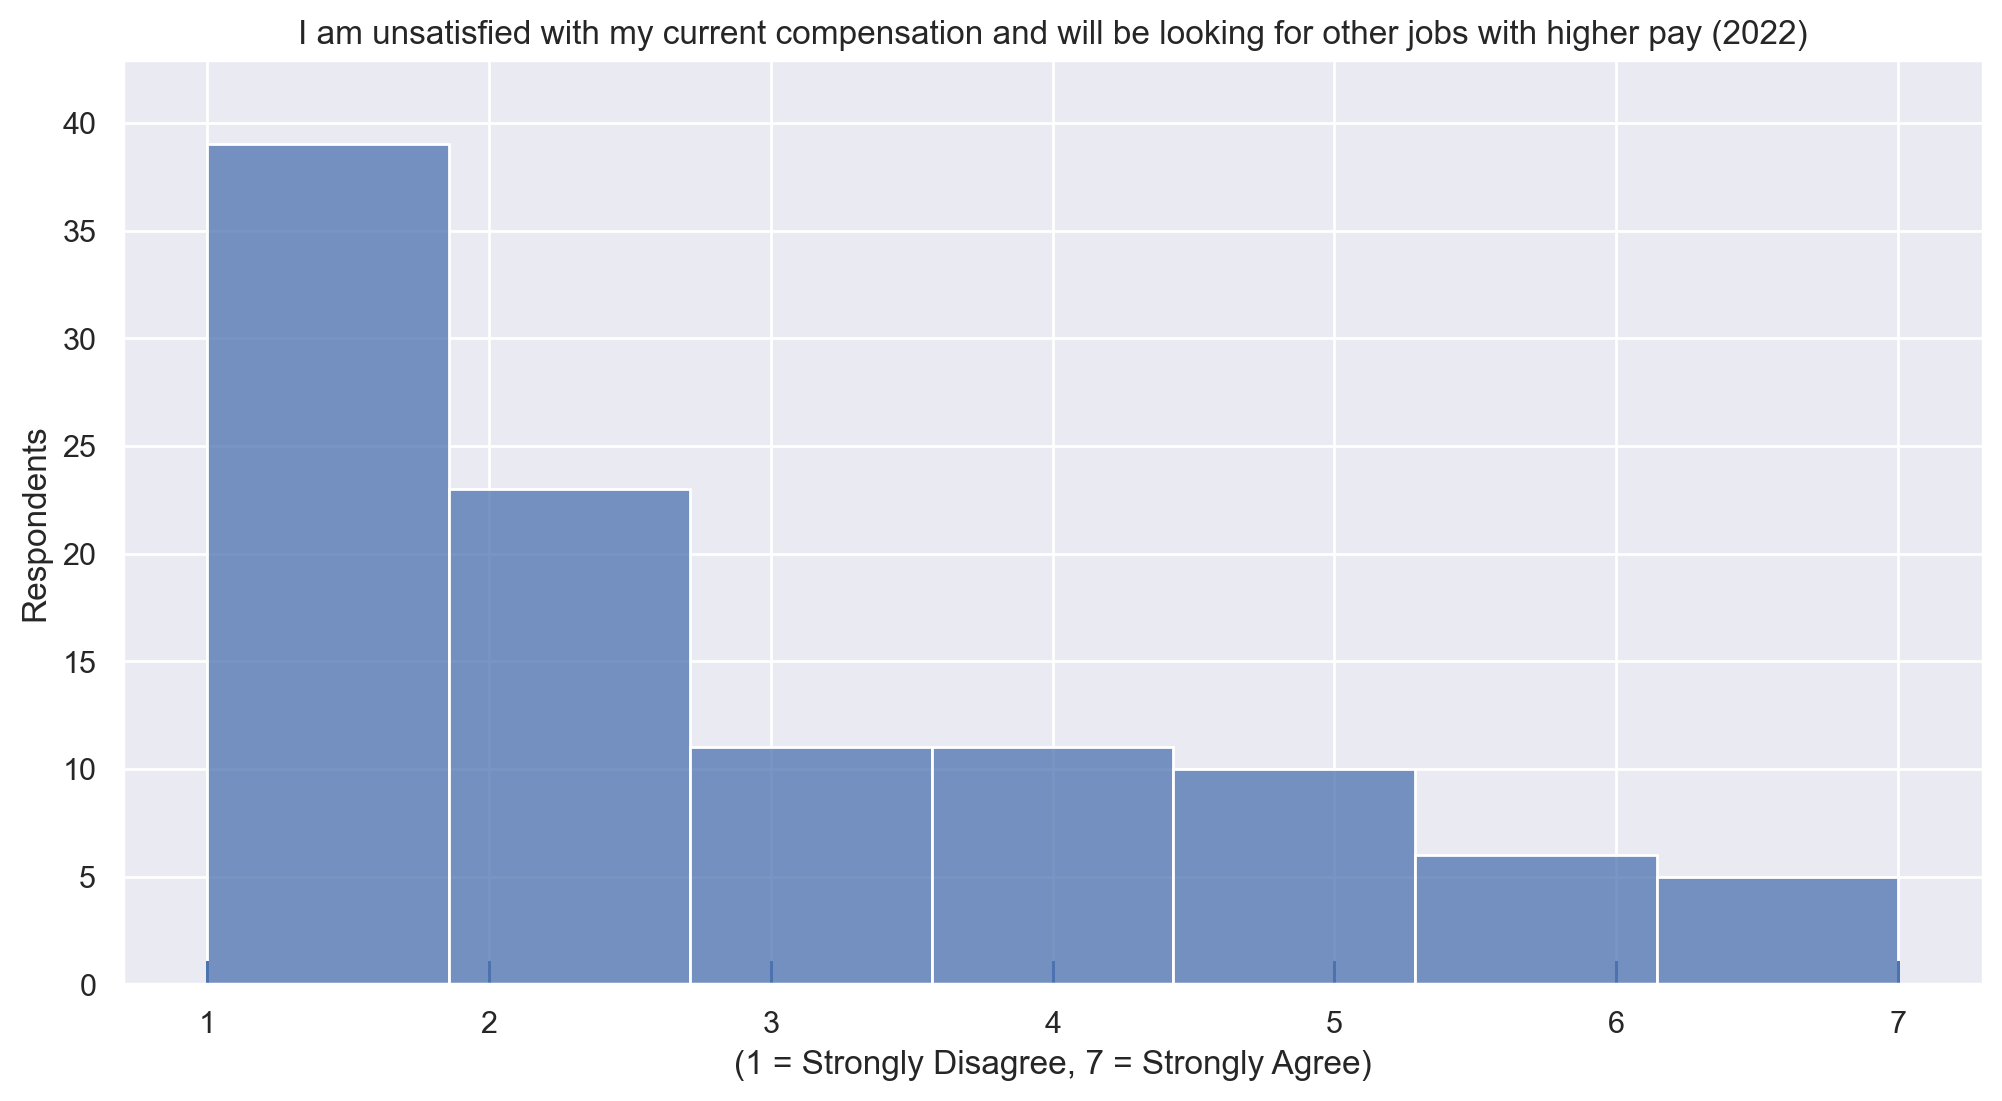

In [122]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "unhappy_lfg", bins=7, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="unhappy_lfg")

plot.set(
    xlabel="(1 = Strongly Disagree, 7 = Strongly Agree)",
    ylabel="Respondents",
    title="I am unsatisfied with my current compensation and will be looking for other jobs with higher pay (2022)"
)
fn = "figures/unhappy_lfg_2022.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

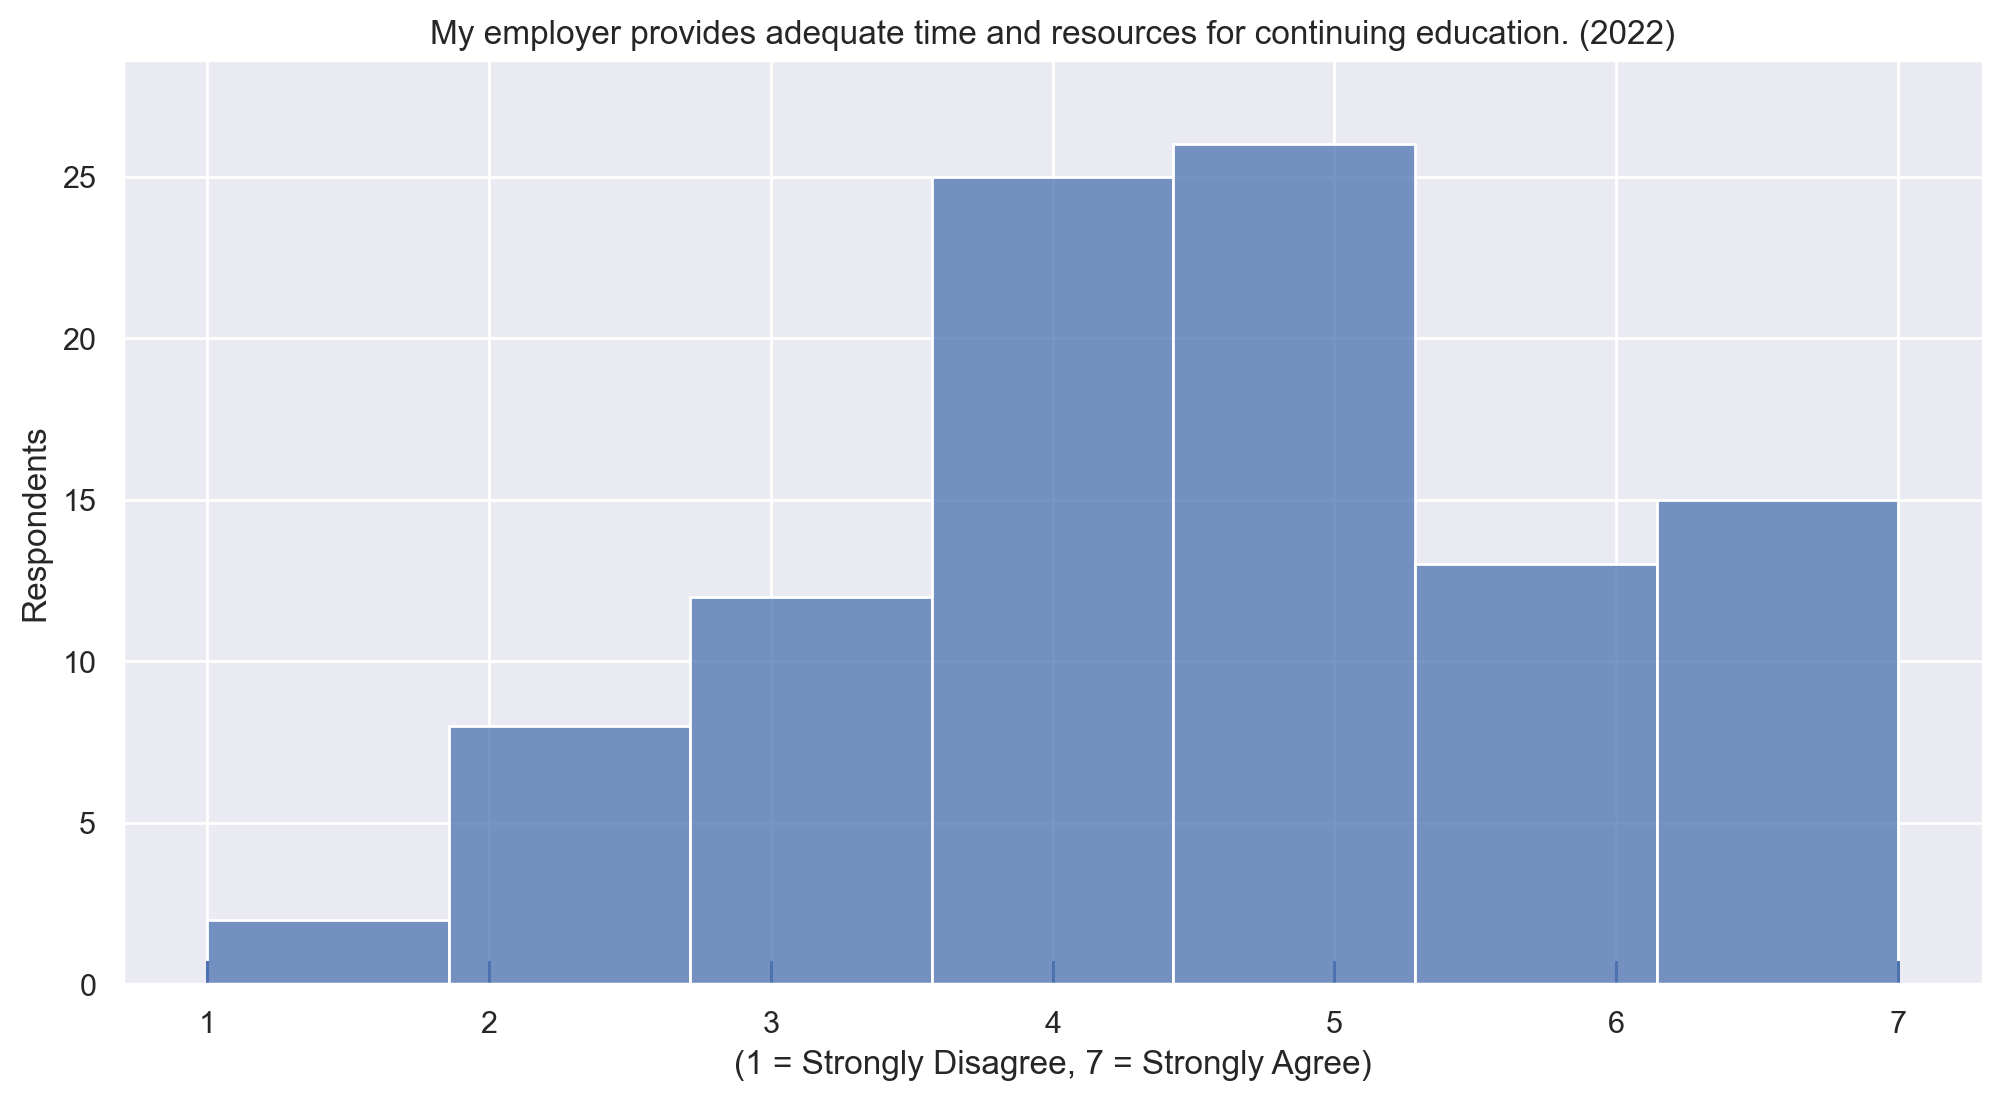

In [123]:
sns.set(color_codes=True)
plt.figure(figsize=(12, 6), dpi=200)
plot = sns.histplot(x="cont_ed_sat", bins=7, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="unhappy_lfg")

plot.set(
    xlabel="(1 = Strongly Disagree, 7 = Strongly Agree)",
    ylabel="Respondents",
    title="My employer provides adequate time and resources for continuing education. (2022)"
)
fn = "figures/cont_ed_sat_2022.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')

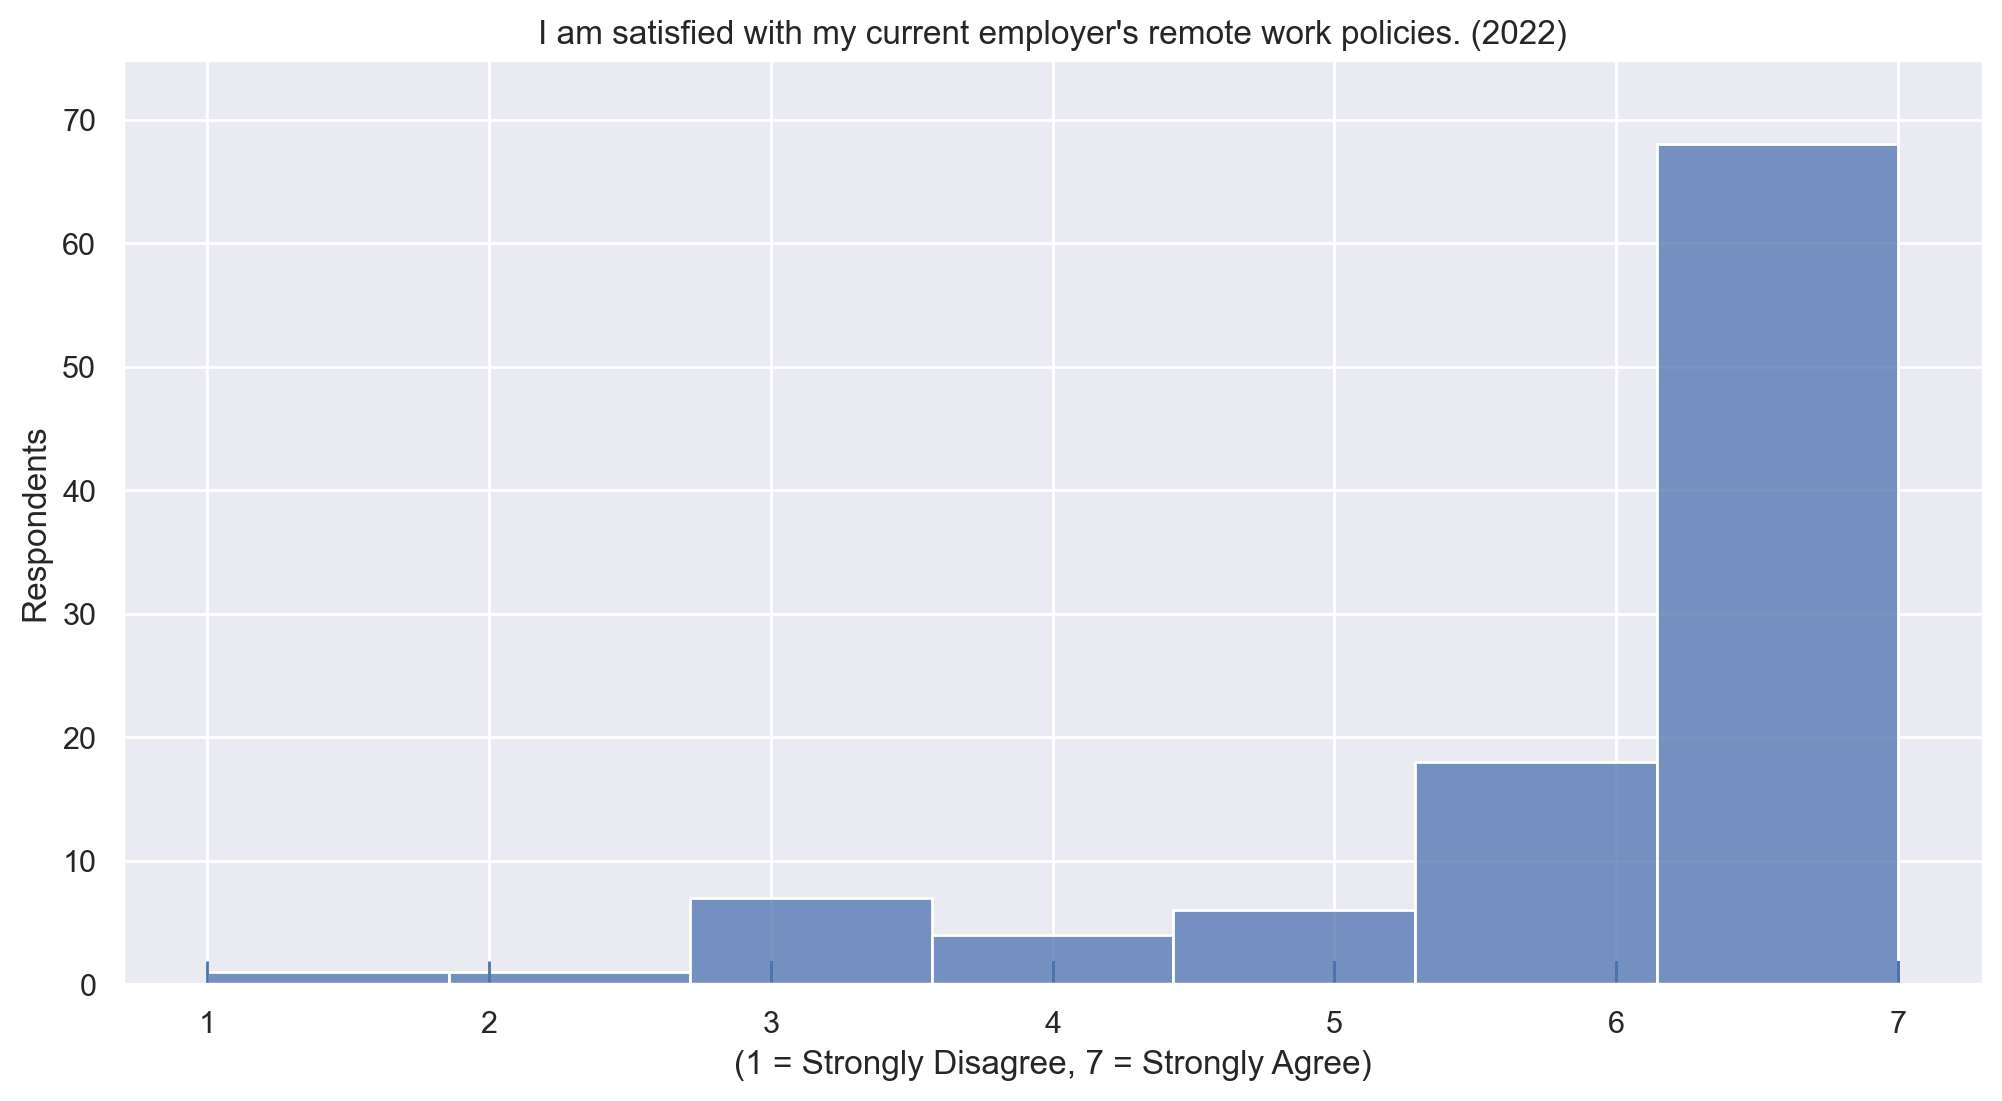

In [124]:
sns.set(color_codes=True)
plt.figure(figsize=(12, 6), dpi=200)
plot = sns.histplot(x="remote_sat", bins=7, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="remote_sat")

plot.set(
    xlabel="(1 = Strongly Disagree, 7 = Strongly Agree)",
    ylabel="Respondents",
    title="I am satisfied with my current employer's remote work policies. (2022)"
)
fn = "figures/remote_sat_2022.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')

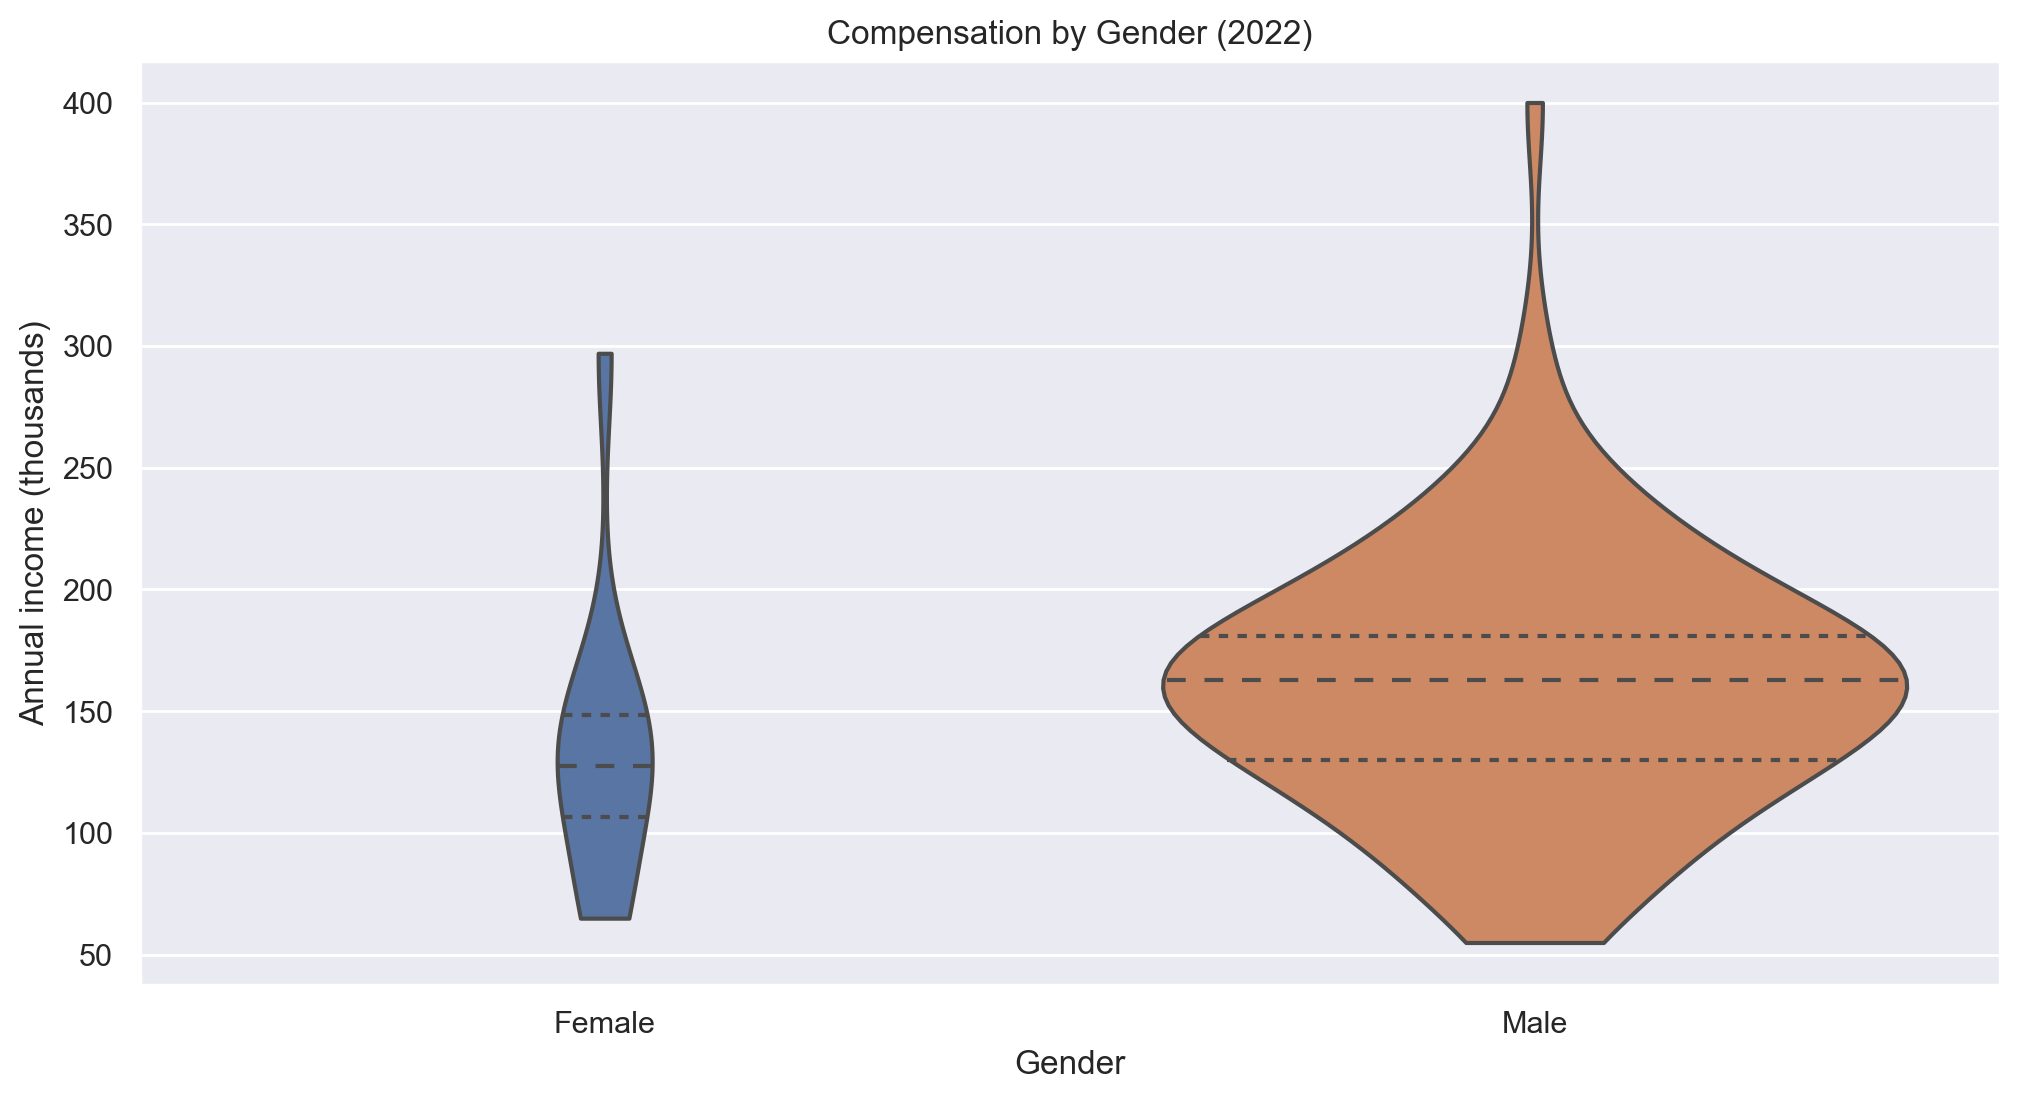

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.634
Date:                Tue, 07 Mar 2023   Prob (F-statistic):              0.108
Time:                        17:55:22   Log-Likelihood:                -574.02
No. Observations:                 106   AIC:                             1152.
Df Residuals:                     104   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        133.7500     15.855      8.

In [125]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "gender",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    data=data
)
plot.set(
    xlabel="Gender",
    ylabel="Annual income (thousands)",
    title="Compensation by Gender (2022)"
)
plot.get_figure().savefig("figures/job_pay_vs_gender.svg")
plt.show()

model = sm.ols(formula="job_pay ~ gender", data=data)
result = model.fit()
print(result.summary())


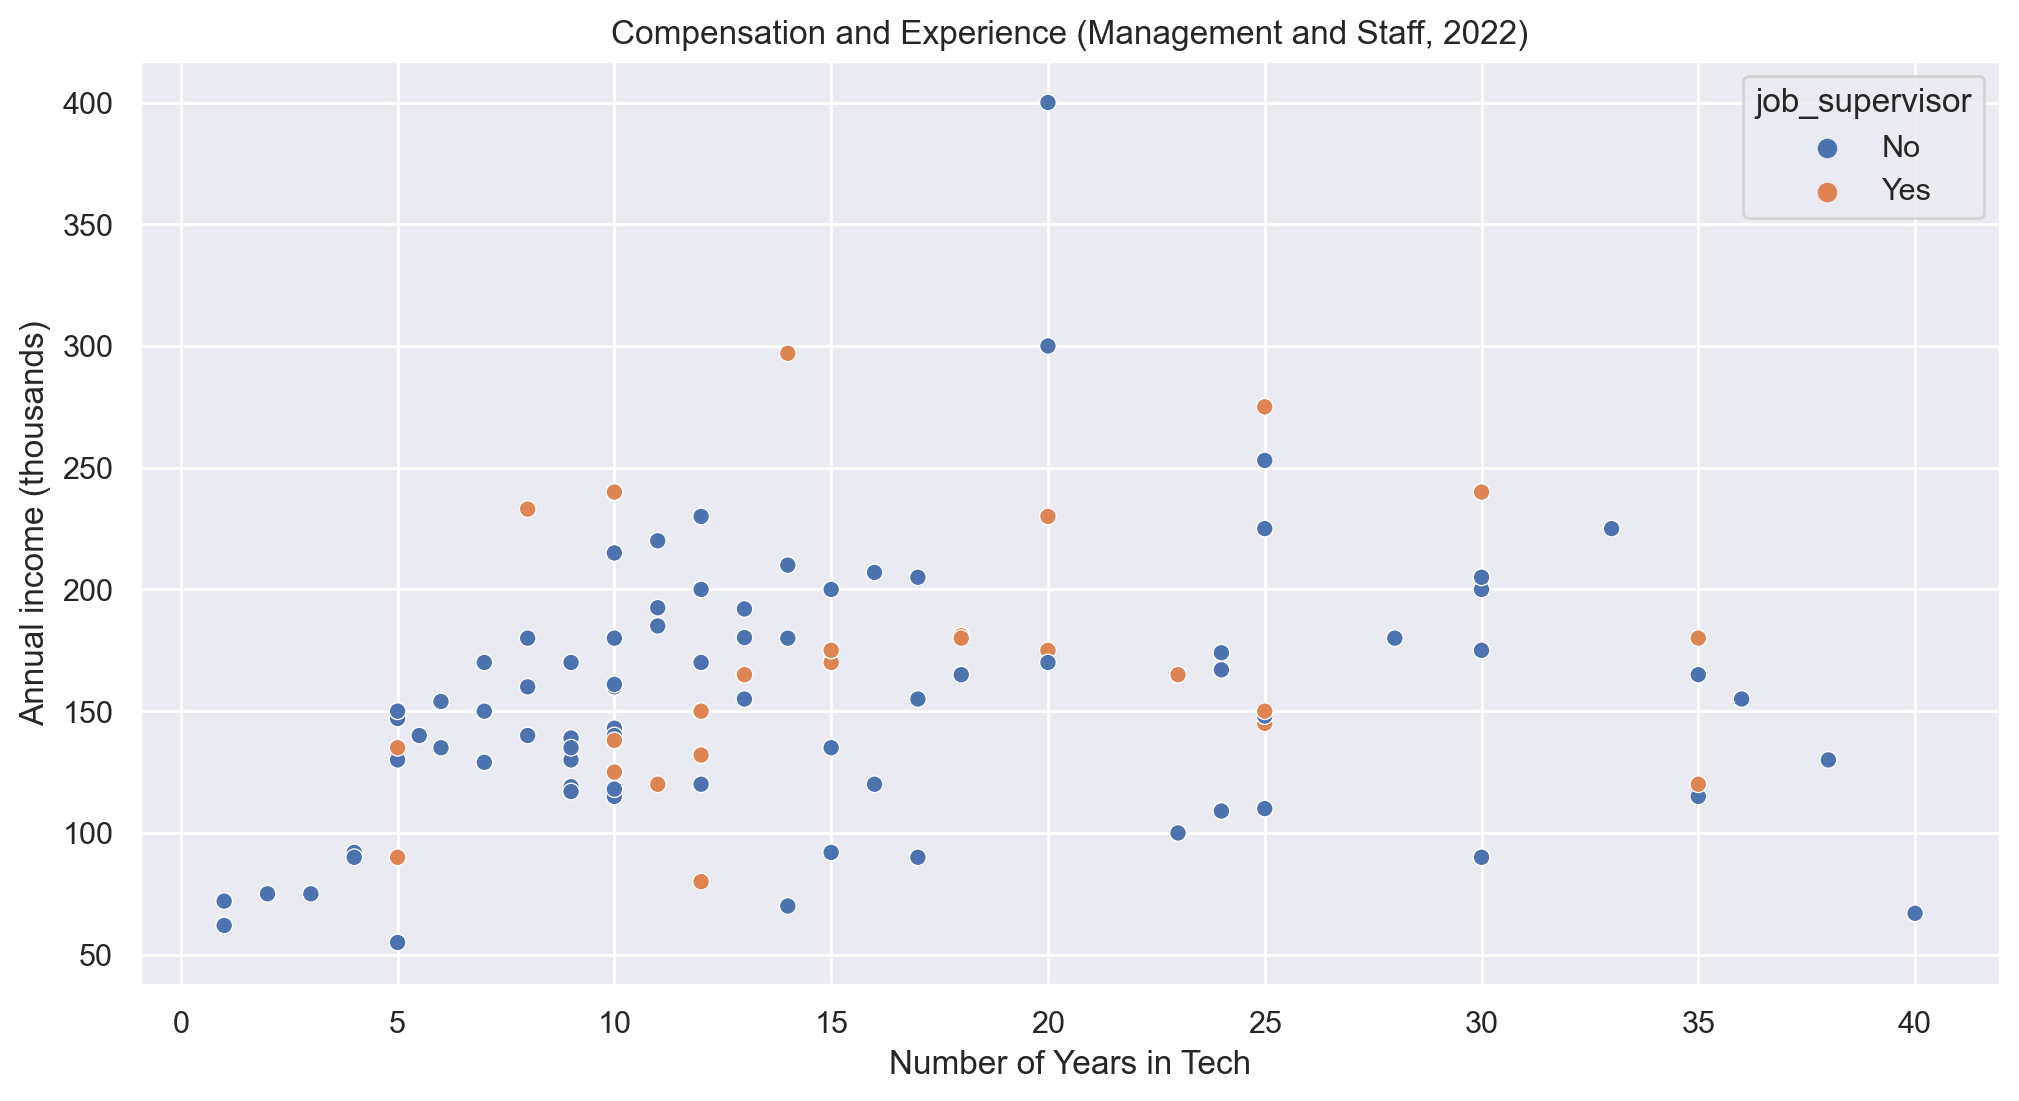

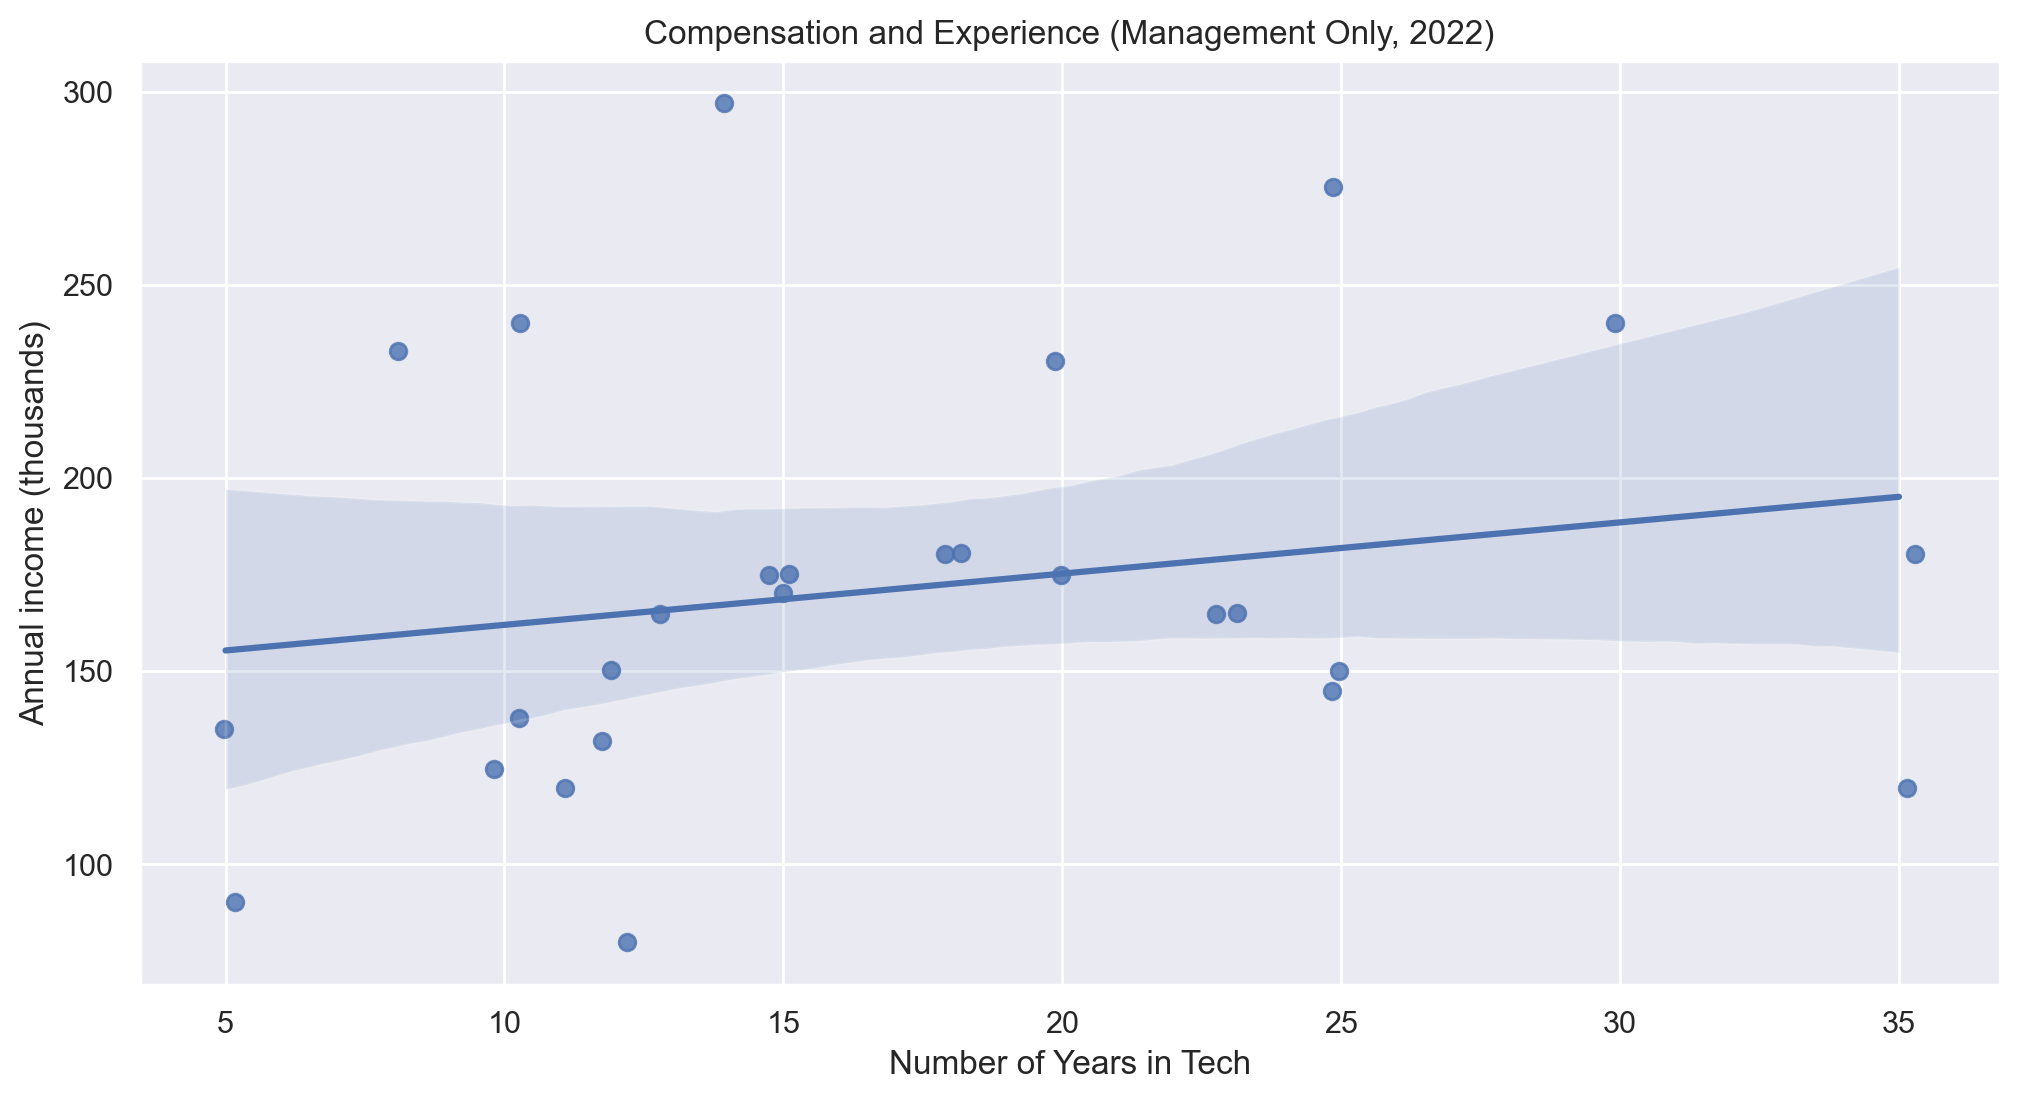

In [126]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.scatterplot(
    x = "tech_tenure",
    y = "job_pay",
    hue = "job_supervisor",
    x_jitter = .3,
    y_jitter = .3,
    data=data)
plot.set(
    xlabel="Number of Years in Tech",
    ylabel="Annual income (thousands)",
    title="Compensation and Experience (Management and Staff, 2022)"
)
plt.show()
plt.close('all')

sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "tech_tenure",
    y = "job_pay",
    x_jitter = .3,
    y_jitter = .3,
    data=data.loc[data['job_supervisor'] == "Yes"])
plot.set(
    xlabel="Number of Years in Tech",
    ylabel="Annual income (thousands)",
    title="Compensation and Experience (Management Only, 2022)"
)
plt.show()
plt.close('all')


Do people want more RocDev In-Person Events?

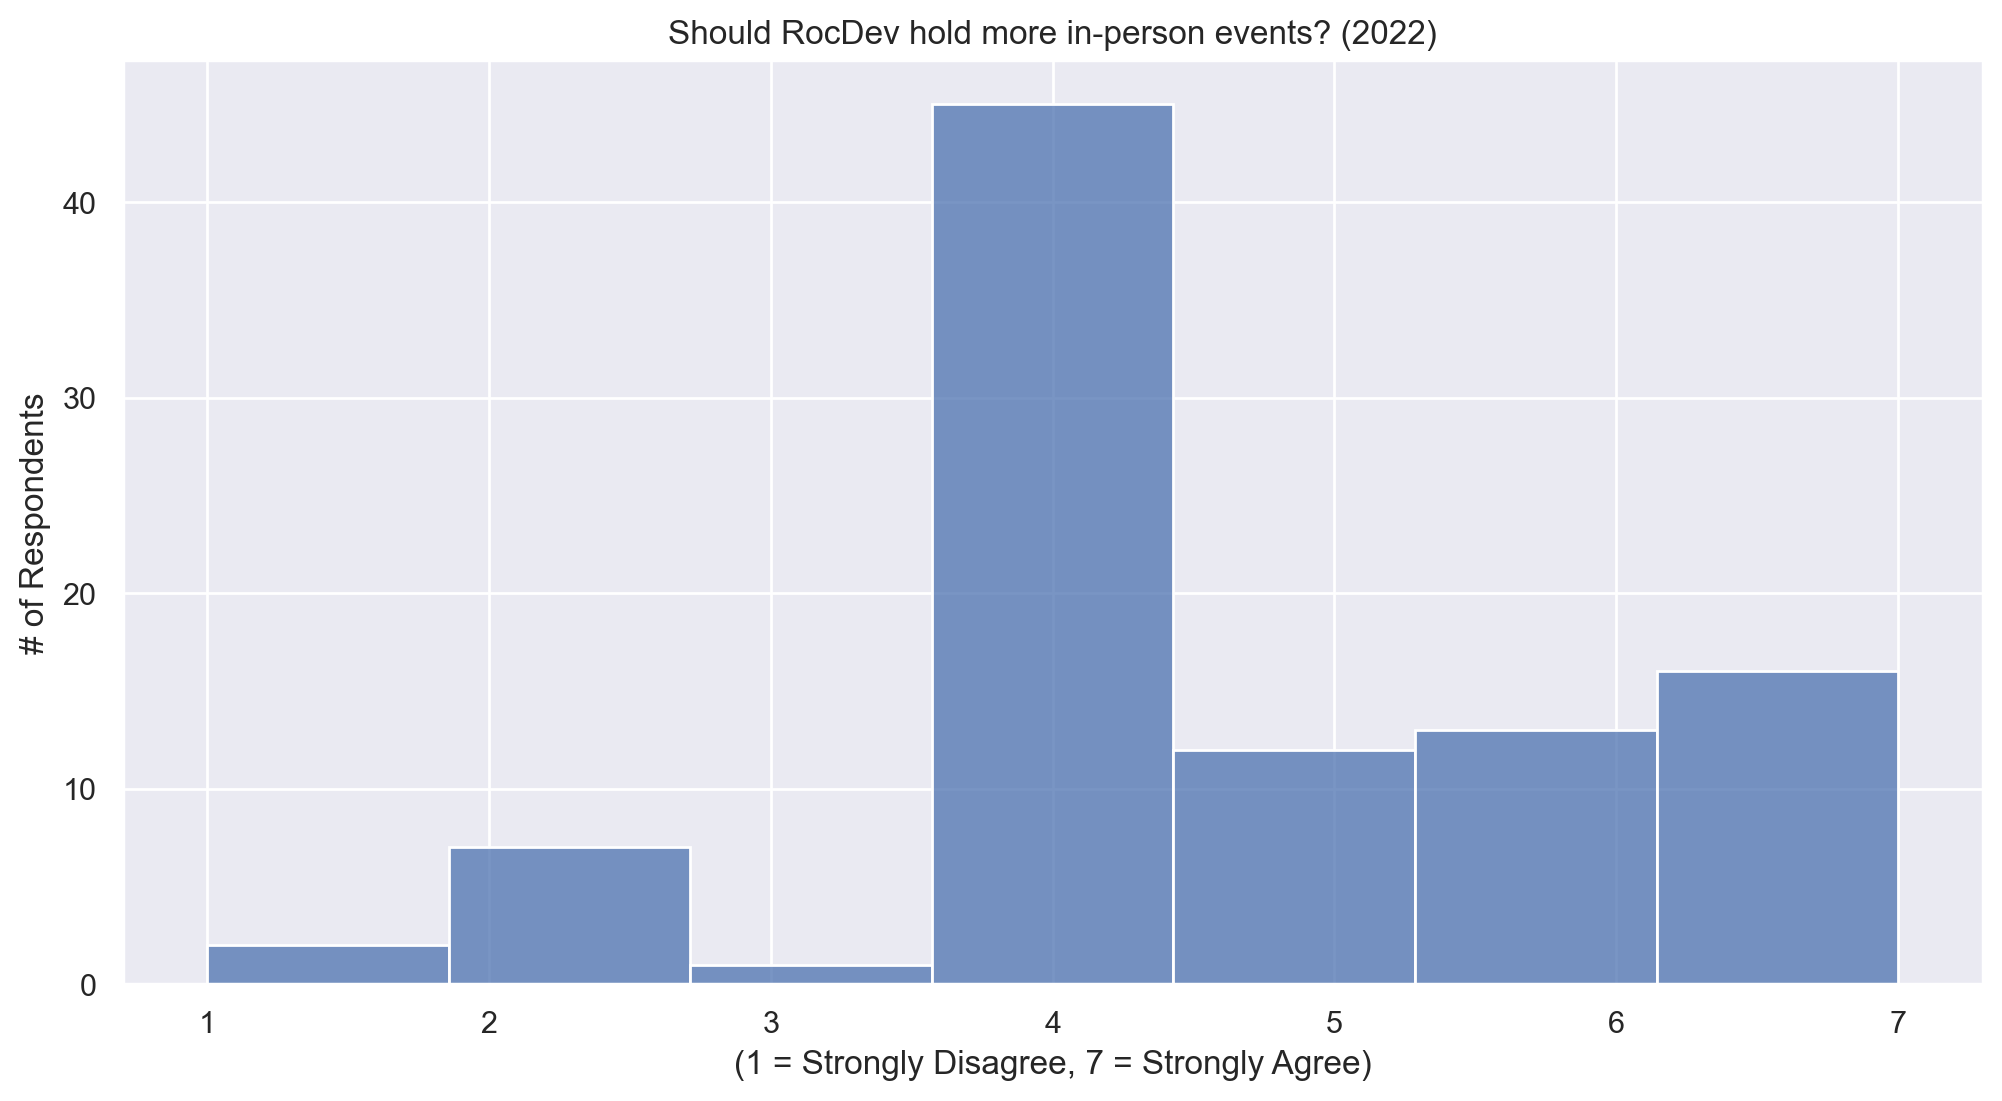

In [127]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "rocdev_irl", bins=7, data=data)
# plot = sns.kdeplot(data['job_hours'].dropna(), bw_adjust=0.3)
#sns.rugplot(data=data, x="remote_ly")

plot.set(
    xlabel="(1 = Strongly Disagree, 7 = Strongly Agree)",
    ylabel="# of Respondents",
    title="Should RocDev hold more in-person events? (2022)"
)
fn = "figures/rocdev_irl.svg"
plot.get_figure().savefig(fn)
plt.show()
plt.close('all')
# display(SVG(fn))

## Summary Statistics
Below are summary statistics for the entire data set.

In [128]:
print(data['consent'].count())
data.describe()

106


org_size  job_tenure      remote   remote_ly  tech_tenure  \
count      105.000000  104.000000  106.000000  106.000000   105.000000   
mean     25810.304762    3.178173    6.358491    6.500000    15.585714   
std     109715.757780    3.907508    1.401962    1.189237     9.254536   
min          1.000000    0.000000    1.000000    1.000000     1.000000   
25%         60.000000    1.000000    6.250000    7.000000     9.000000   
50%        225.000000    1.500000    7.000000    7.000000    13.000000   
75%       6000.000000    4.250000    7.000000    7.000000    23.000000   
max    1000000.000000   25.000000    7.000000    7.000000    40.000000   

        tech_jobs  tech_jobs_py     job_pay  job_when_negotiated   job_hours  \
count  104.000000    106.000000  106.000000           105.000000  104.000000   
mean     5.346154      1.141509  157.978774          1966.380952   40.673077   
std      3.007335      0.786053   55.347238           324.987881    7.063433   
min      1.000000      0.000000   55.000000             1.000000   20.000000   
25%      3.750000      1.000000  121.250000          2022.000000   40.000000   
50%      5.000000      1.000000  155.000000          2022.000000   40.000000   
75%      7.000000      1.750000  180.000000          2022.000000   41.250000   
max     20.000000      6.000000  400.000000          2023.000000   70.000000   

       ...  benefits_retirement_matching  benefits_tuition  benefits_vision  \
count  ...                    106.000000        106.000000       106.000000   
mean   ...                      0.849057          0.283019         0.933962   
std    ...                      0.359694          0.452606         0.249528   
min    ...                      0.000000          0.000000         0.000000   
25%    ...                      1.000000          0.000000         1.000000   
50%    ...                      1.000000          0.000000         1.000000   
75%    ...                      1.000000          1.000000         1.000000   
max    ...                      1.000000          1.000000         1.000000   

       misc_disability  misc_foreigner   misc_lgbt   misc_none  misc_parent  \
count       104.000000      104.000000  104.000000  104.000000   104.000000   
mean          0.067308        0.019231    0.105769    0.307692     0.567308   
std           0.251767        0.138000    0.309031    0.463774     0.497848   
min           0.000000        0.000000    0.000000    0.000000     0.000000   
25%           0.000000        0.000000    0.000000    0.000000     0.000000   
50%           0.000000        0.000000    0.000000    0.000000     1.000000   
75%           0.000000        0.000000    0.000000    1.000000     1.000000   
max           1.000000        1.000000    1.000000    1.000000     1.000000   

       job_avg_tenure  log_org_size  
count      104.000000    105.000000  
mean         3.290757      2.678386  
std          2.552617      1.284736  
min          0.500000      0.000000  
25%          1.825000      1.778151  
50%          2.757143      2.352183  
75%          4.062500      3.778151  
max         23.000000      6.000000  

[8 rows x 34 columns]